This notebook details price predictions on cryptocurrency Bitcoin. The data was collected from multiple sources and is contained in 3 CSV files named Project_Set_MarketData.csv, Project_Set_BlockchainData.csv, Project_Set_OHLC.csv. Some of its cleaning was conducted in excel. The structure of the notebook is as follows: Installs & Library Imports, Data Collection / Cleaning, Data Visualisation, Multicollinearity & Stationarity Testing, Data Re-Shaping (required for model inputs), Model Hyperparameter Tuning, Running Models on Test Data, Test Scores; Visualisation & Hypothesis Testing.

The below code cell installs our kraken API used to collect up-to-date data on their marketplace currencies.

https://pypi.org/project/pykrakenapi/

In [ ]:
!pip install krakenex
!pip install pykrakenapi
import krakenex
from pykrakenapi import KrakenAPI
api = krakenex.API()
k = KrakenAPI(api)

  Created wheel for krakenex: filename=krakenex-2.1.0-py3-none-any.whl size=22516 sha256=8607303f7246e9b57b20f63d44e9a2b68863b90b635357c7fd25ba0d2670f2a6
  Stored in directory: /root/.cache/pip/wheels/ff/81/24/87f129363e0c0d57de8ce01c69b8a4e29e6e46e1ebec4bfaad
Successfully built krakenex
  Created wheel for pykrakenapi: filename=pykrakenapi-0.3.0-py3-none-any.whl size=25401 sha256=787476994d96e567837ce86cbce1c9f74edc223a8a771d624a36db269cd0fe35
  Stored in directory: /root/.cache/pip/wheels/67/98/1f/35298e54a5750c05b3abee692f41571145b6c1addf8235b615
Successfully built pykrakenapi


The below cell is an install for ta-lib, a technical analysis library used to create indicators that will act as data features.

https://www.ta-lib.org/

In [ ]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Selecting previously unselected package libta-lib0.
(Reading database ... 155202 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 269 kB 8.3 MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.24-cp37-cp37m-linux_x86_64.whl size=1465729 sha256=7a2544e5a8d7c58ab4f21817e865246cc0f6d6471b46d966af20e3a8cb41b902
  Stored in directory: /root/.cache/pip/wheels/02/b1/a5/aca31e8cdd0137d7a83bf72237056b8705663dd1f9b5eac11e
Successfully built ta-lib


Diebold-Mariano-Test for our model predictions.

https://github.com/echosun1996/DieboldMarianoTest

In [ ]:
!pip install diebold-mariano-test

Install is for h5py. This will allow us to save models to file and return the weights for the model which had the best corresponding validation loss. Apparently this is pre installed for colab.

In [ ]:
# !sudo pip install h5py

Microsoft (Open Neural Network Exchance) Onnxruntime provides built in optimization to increase runtime. Although as we are using keras and not PyTorch, training it not optimized. However, it does provide optimized inferencing over Cuda. Given more time I think I would look into this further.

https://onnxruntime.ai/

In [ ]:
# !pip install onnxruntime-gpu==1.9.0
# import onnxruntime

Below are our library imports for our Deep-Learning task. 

In [ ]:
import pandas as pd
import numpy as np
import talib
import seaborn as sns
import math
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from google.colab import drive
pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
#from sklearn.pipeline import Pipeline #Pipelines can be used to evaluate different model depths, although I didn't implement it here
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV #didn't end up utilising randomized search although I would given more time
from statsmodels.tsa.stattools import pacf
from diebold_mariano_test import *
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from keras.backend import dropout
from keras import constraints
from keras.constraints import maxnorm
from keras.models import load_model

import patsy
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import random
random.seed(21) #random seed for reproducibility

Accessing through Google Drive so must be mounted.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


**PART 1**

**Data Collection**

Reading our csv files into pandas dataframes.

In [ ]:
dfx=pd.read_csv('/content/drive/My Drive/ProjectData/Project_Set_BlockchainData.csv', index_col='dtime',parse_dates=['dtime'])
dfy=pd.read_csv('/content/drive/My Drive/ProjectData/Project_Set_MarketData.csv', index_col='dtime',parse_dates=['dtime'])
dfz=pd.read_csv('/content/drive/My Drive/ProjectData/Project_Set_OHLC.csv', index_col='dtime',parse_dates=['dtime'])

del dfx['Market_Cap']
del dfx['Estimated_Transaction_Volume_USD'] #both are captured in our Net Value to Transactions = Market Cap / Transaction Volume

dfx.reset_index(inplace=True)
dfy.reset_index(inplace=True)
dfz.reset_index(inplace=True)

dfy.fillna(method='bfill',inplace=True) #markets: weekend data is missing so filled with prior day data


#print('Number of rows and columns for our blockchain data:', df1.shape)
#print('Number of rows and columns for our market data:', df2.shape)
#print('Number of rows and columns for our ohlcVT Kraken Data:', df3.shape)
#dfx.head(5)
#dfy.head(5)
#dfz.head(5)

The below code cells collect up-to-date Open High Low Close Volume Traded data from the Kraken Exchange for Bitcoin (BTC), Ethereum (ETH), Ripple (XRP). Much of this data was deleted as it contains information that was not available on Kraken website.

In [ ]:
ohlcBTC=k.get_ohlc_data("BTCUSD", interval=1440, ascending=False)
ohlcBTC=ohlcBTC[0].reset_index()
ohlcBTC.dtime = pd.to_datetime(ohlcBTC.dtime)
del ohlcBTC['time']
del ohlcBTC['vwap'] #this could have been an interesting feature, although the kraken website where we downloaded earlier data from did not contain volume weighted average price
#print(ohlcBTC)

In [ ]:
ohlcETH= k.get_ohlc_data("ETHUSD", interval=1440, ascending=False)
ohlcETH=ohlcETH[0].reset_index()
ohlcETH.dtime = pd.to_datetime(ohlcETH.dtime)
del ohlcETH['time']
del ohlcETH['vwap']
del ohlcETH['open']
del ohlcETH['high']
del ohlcETH['low']
del ohlcETH['count'] #were only interested in close and volume for ETH (Ethereum)
#print(ohlcETH)

public call frequency exceeded (seconds=0.143566) 
 sleeping for 5 seconds


In [ ]:
ohlcXRP= k.get_ohlc_data("XRPUSD", interval=1440, ascending=False)
ohlcXRP=ohlcXRP[0].reset_index()
ohlcXRP.dtime = pd.to_datetime(ohlcXRP.dtime)
del ohlcXRP['time']
del ohlcXRP['vwap']
del ohlcXRP['open']
del ohlcXRP['high']
del ohlcXRP['low']
del ohlcXRP['count'] #were only interested in close and volume for XRP (Ripple)
#print(ohlcXRP)

public call frequency exceeded (seconds=0.106044) 
 sleeping for 5 seconds


Here we have appended this up-to-date data with our OHLC Data which only goes up to 31/12/2021 as found on Kraken's website.

https://support.kraken.com/hc/en-us/articles/360047124832-Downloadable-historical-OHLCVT-Open-High-Low-Close-Volume-Trades-data

In [ ]:
selection_condition=pd.isna(dfz['BTC_Open'])
dfz['BTC_Open'].iloc[selection_condition]=ohlcBTC[selection_condition]['open']
selection_condition=pd.isna(dfz['BTC_High'])
dfz['BTC_High'].iloc[selection_condition]=ohlcBTC[selection_condition]['high']
selection_condition=pd.isna(dfz['BTC_Low'])
dfz['BTC_Low'].iloc[selection_condition]=ohlcBTC[selection_condition]['low']
selection_condition=pd.isna(dfz['BTC_Close'])
dfz['BTC_Close'].iloc[selection_condition]=ohlcBTC[selection_condition]['close']
selection_condition=pd.isna(dfz['BTC_Volume'])
dfz['BTC_Volume'].iloc[selection_condition]=ohlcBTC[selection_condition]['volume']
selection_condition=pd.isna(dfz['BTC_Traded'])
dfz['BTC_Traded'].iloc[selection_condition]=ohlcBTC[selection_condition]['count']

selection_condition=pd.isna(dfz['ETH_Close'])
dfz['ETH_Close'].iloc[selection_condition]=ohlcETH[selection_condition]['close']
selection_condition=pd.isna(dfz['ETH_Volume'])
dfz['ETH_Volume'].iloc[selection_condition]=ohlcETH[selection_condition]['volume']

selection_condition=pd.isna(dfz['XRP_Close'])
dfz['XRP_Close'].iloc[selection_condition]=ohlcXRP[selection_condition]['close']
selection_condition=pd.isna(dfz['XRP_Volume'])
dfz['XRP_Volume'].iloc[selection_condition]=ohlcXRP[selection_condition]['volume']

Create our technical indicators data

In [ ]:
import copy

dfy=dfy.iloc[::-1] #reverse the order of the rows so our index 0 is our start date 2014-02-16
dfx=dfx.iloc[::-1]
dfz=dfz.iloc[::-1] #dfz is our OHLC data, technical indicators are created from close price
data=dfz


tek_ind_1=copy.deepcopy(data)
tek_ind_2=copy.deepcopy(data)

tek_ind_1['daily_return']=tek_ind_1['BTC_Close'].pct_change().fillna(0) #daily return
tek_ind_1['cum_daily_return']=(1+tek_ind_1['daily_return']).cumprod() #cumulative returns
tek_ind_1['rsi']=talib.RSI(tek_ind_1['BTC_Close'].values,timeperiod=14) #relative strength index
tek_ind_1['Williams_PCT_R']=talib.WILLR(tek_ind_1['BTC_High'].values,tek_ind_1['BTC_Low'],tek_ind_1['BTC_Close'].values, 14) #Williams % Return
tek_ind_1['ma7']=tek_ind_1['BTC_Close'].rolling(window=7).mean().fillna(0) #7day moving average
tek_ind_1['ma21']=tek_ind_1['BTC_Close'].rolling(window=21).mean().fillna(0) #21 day moving average
tek_ind_1['ma50']=tek_ind_1['BTC_Close'].rolling(window=50).mean().fillna(0) #50 day moving average
tek_ind_1['ma200']=tek_ind_1['BTC_Close'].rolling(window=200).mean().fillna(0) #21 day moving average
tek_ind_1['ema_26']=tek_ind_1['BTC_Close'].ewm(span=26).mean().fillna(0) #exponential moving average 26 days
tek_ind_1['ema_12']=tek_ind_1['BTC_Close'].ewm(span=12).mean().fillna(0) #exponential moving average 12 days
tek_ind_1['MACD']=(tek_ind_1['ema_12']-tek_ind_1['ema_26']) #Moving Average Convergence Divergence
tek_ind_1['Ema']=tek_ind_1['BTC_Close'].ewm(com=0.5).mean() #exponential moving average 0.5 decay i.e., 1/(1+com)
tek_ind_1=tek_ind_1.fillna(0) #rsi and Williams% return NaN for past 2 weeks

#Bollinger Bands
window=21
no_of_std=2
rolling_mean=tek_ind_1['BTC_Close'].rolling(window).mean()
rolling_std=tek_ind_1['BTC_Close'].rolling(window).std()
tek_ind_1['bb_high']=(rolling_mean+(rolling_std*no_of_std)).fillna(0)
tek_ind_1['bb_low']=(rolling_mean-(rolling_std*no_of_std)).fillna(0)

del tek_ind_1['BTC_Open'] #get rid of unnecessary features
del tek_ind_1['BTC_High']
del tek_ind_1['BTC_Low']
del tek_ind_1['BTC_Close']
del tek_ind_1['BTC_Volume']
del tek_ind_1['BTC_Traded']
del tek_ind_1['ETH_Close']
del tek_ind_1['ETH_Volume']
del tek_ind_1['XRP_Close']
del tek_ind_1['XRP_Volume']
del tek_ind_1['ema_26']
del tek_ind_1['ema_12']

display(tek_ind_1)

dtime  daily_return  cum_daily_return     rsi  Williams_PCT_R  \
2934 2014-02-16        0.0000            1.0000  0.0000          0.0000   
2933 2014-02-17       -0.0697            0.9303  0.0000          0.0000   
2932 2014-02-18       -0.0208            0.9110  0.0000          0.0000   
2931 2014-02-19       -0.0147            0.8976  0.0000          0.0000   
2930 2014-02-20        0.0017            0.8992  0.0000          0.0000   
...         ...           ...               ...     ...             ...   
4    2022-02-24       -0.0573           49.6629 35.9859        -91.4797   
3    2022-02-25        0.0296           51.1327 41.7862        -70.1042   
2    2022-02-26        0.0128           51.7878 44.2128        -60.5760   
1    2022-02-27       -0.0290           50.2854 40.0861        -82.4271   
0    2022-02-28        0.0003           50.3000 40.1445        -82.2149   

            ma7       ma21       ma50      ma200       MACD        Ema  \
2934     0.0000     0.0000     0.0000     0.0000     0.0000   767.6088   
2933     0.0000     0.0000     0.0000     0.0000    -1.2000   727.4938   
2932     0.0000     0.0000     0.0000     0.0000    -1.9886   707.9768   
2931     0.0000     0.0000     0.0000     0.0000    -2.6705   695.1674   
2930     0.0000     0.0000     0.0000     0.0000    -2.9371   691.8421   
...         ...        ...        ...        ...        ...        ...   
4    39861.9429 40788.4381 42044.2960 49552.6505 -1082.1318 38792.6741   
3    39559.0857 40601.3190 42054.2420 49517.3645 -1073.7457 39097.4914   
2    39454.6143 40424.3190 42009.9920 49488.1530 -1014.8215 39534.3638   
1    39295.1286 40248.9333 41993.2660 49453.2920 -1049.0921 38911.1213   
0    39177.2857 40051.1571 41990.8380 49424.3400 -1063.0934 38710.8404   

        bb_high     bb_low  
2934     0.0000     0.0000  
2933     0.0000     0.0000  
2932     0.0000     0.0000  
2931     0.0000     0.0000  
2930     0.0000     0.0000  
...         ...        ...  
4    43551.3620 38025.5142  
3    43212.2138 37990.4242  
2    42701.0602 38147.5779  
1    42491.6346 38006.2321  
0    42085.1369 38017.1774  

[2935 rows x 13 columns]

In [ ]:
#Calculation of Stochastic Oscillator (%K and %D)
def stok(df,n):
  tek_ind_2['stok']=((tek_ind_2['BTC_Close']-tek_ind_2['BTC_Low'].rolling(window=n,center=False).mean()) / (tek_ind_2['BTC_High'].rolling(window=n,center=False).max() - tek_ind_2['BTC_Low'].rolling(window=n,center=False).min())) * 100
  tek_ind_2['stod']=tek_ind_2['stok'].rolling(window=n,center=False).mean()

stok(tek_ind_2,14)
tek_ind_2=tek_ind_2.fillna(0)

#Calculation of Price Rate of Change indicator & Momentum
tek_ind_2['ROC']=((tek_ind_2['BTC_Close']-tek_ind_2['BTC_Close'].shift(12)) / (tek_ind_2['BTC_Close'].shift(12)))*100 #ROC = [(Close - Close n periods ago) / (Close n period ago) * 100]
tek_ind_2['Momentum']=tek_ind_2['BTC_Close']-tek_ind_2['BTC_Close'].shift(3) #momentum 4days
tek_ind_2=tek_ind_2.fillna(0)

#Calculation of Commodity Channel Index
tp=(tek_ind_2['BTC_High']+tek_ind_2['BTC_Low']+tek_ind_2['BTC_Close'])/3
ma=tp/20
md=(tp-ma)/20
tek_ind_2['CCI']=(tp-ma)/(0.015*md)
tek_ind_2=tek_ind_2.fillna(0)

#Triple Exponential Moving Average
tek_ind_2['ema']=tek_ind_2['BTC_Close'].ewm(span=3,min_periods=0,adjust=True,ignore_na=False).mean()
tek_ind_2=tek_ind_2.fillna(0)
tek_ind_2['tema']=(3*tek_ind_2['ema']-3*tek_ind_2['ema']*tek_ind_2['ema'])+(tek_ind_2['ema']*tek_ind_2['ema']*tek_ind_2['ema'])

#Turning Line
high=tek_ind_2['BTC_High'].rolling(window=9,center=False).max()
low=tek_ind_2['BTC_Low'].rolling(window=9,center=False).max()
tek_ind_2['turning_line']=(high+low)/2

#Standard Line
p26_high=tek_ind_2['BTC_High'].rolling(window=26,center=False).max()
p26_low=tek_ind_2['BTC_Low'].rolling(window=26,center=False).max()
tek_ind_2['standard_line']=(p26_high+p26_low)/2

#Leading Span 1
tek_ind_2['ichimoku_span1']=((tek_ind_2['turning_line']+tek_ind_2['standard_line'])/2).shift(26)

#Leading Span 2
p52_high=tek_ind_2['BTC_High'].rolling(window=52,center=False).max()
p52_low=tek_ind_2['BTC_Low'].rolling(window=52,center=False).min()
tek_ind_2['ichimoku_span2']=((p52_high+p52_low)/2).shift(26)
tek_ind_2=tek_ind_2.fillna(0)

del tek_ind_2['BTC_Open'] #get rid of unnecessary features
del tek_ind_2['BTC_High']
del tek_ind_2['BTC_Low']
del tek_ind_2['BTC_Close']
del tek_ind_2['BTC_Volume']
del tek_ind_2['BTC_Traded']
del tek_ind_2['ETH_Close']
del tek_ind_2['ETH_Volume']
del tek_ind_2['XRP_Close']
del tek_ind_2['XRP_Volume']
del tek_ind_2['ema']

#display(tek_ind_2)

Here we wrap all of our dataframes into one using a lambda function.

In [ ]:
from functools import reduce

dfs=[dfz,dfy,dfx,tek_ind_1,tek_ind_2]
df=reduce(lambda left,right: pd.merge(left,right,on='dtime'), dfs)
df=df.dropna(axis=0,how='any')
df.set_index('dtime')
df=df.iloc[1188:] #2017-05-19

#data for XRP starts 2017-05-19, this improves results across all models presumably as starting at 2014 feeds 
#our model years of 0 value data for this and our Ethereum price / volume

#df.describe()

**PART 2**

**Data Visualisation**

This first cell here conducts a statistical test on our target feature Bitcoin close price to see whether it is normally distributed. It is not.

In [ ]:
stat, p = stats.normaltest(df['BTC_Close']) #test the null hypothesis that a sample comes from a normal distribution. based on D’Agostino and Pearson’s. test combines skewness and kurtosis.
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=313.194, p=0.000
Data does not look Gaussian (reject H0)


Now we visualise the distribution and look at its Kurtosis and Skewness. value above 1+ shows nonormality (too peaked) i.e., narrow distribution. As we have value 0.23 it suggests that the distribution is not narrow, this is a change from our original data 2014-02-16/2022-02-28 which did have a narrow distribution with many more values spread around 10,000 price. skewness value above 1+ suggests substantially skewed distrubution. As we can see our distribution is heavily skewed by values < 15,000.

Kurtosis of normal distribution: 0.23654378022311562
Skewness of normal distribution: 1.315507241488313


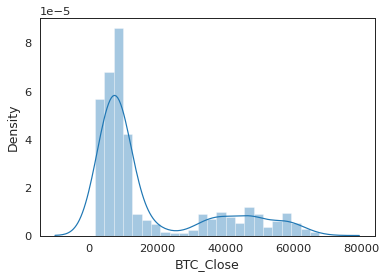

In [ ]:
sns.distplot(df['BTC_Close']);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df['BTC_Close'])))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df['BTC_Close'])))

Here we have a Seaborn graph of our target feature Bitcoin Close Price for our entire time period: 2017-05-19 up to 2022-02-28

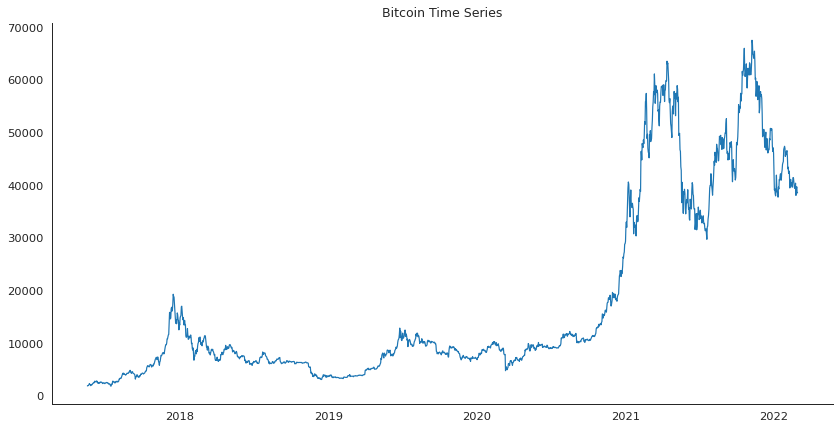

In [ ]:
dfplot=df[['dtime','BTC_Close']]
dfplot=dfplot.reset_index()
del dfplot['index']
dfplot=pd.DataFrame(dfplot)

start_date=pd.to_datetime('2017-05-19')
end_date=pd.to_datetime('2022-02-28')
dfplot['dtime']=pd.to_datetime(dfplot['dtime'])
new_df=(dfplot['dtime']>=start_date)&(dfplot['dtime']<=end_date)
dfwrap=dfplot.loc[new_df]
plot_data=dfwrap.set_index('dtime')
plot=plt.figure(figsize=(14,7))
plot=plt.plot(plot_data.index, plot_data['BTC_Close'])
plt.title('Bitcoin Time Series')
sns.despine(top=True)
plt.show();

Finally, this cell creates a plot of Bitcoin Close Price against its 30 day rolling mean & standard deviation. It uses https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html to perform an audmented dickey fuller test for a unit root. Using AIC - Akaike Information Criterion, it estimes the number of lags chosen to minimize the corresponding information criterion. We produce a test statistic weighted against our test statistic. Null H0 is that there is a unit root with our alternative H1 being that no unit root exists. Our test statistic value is larger than our critical value for all significance levels therefore we accept a unit root in our time series.

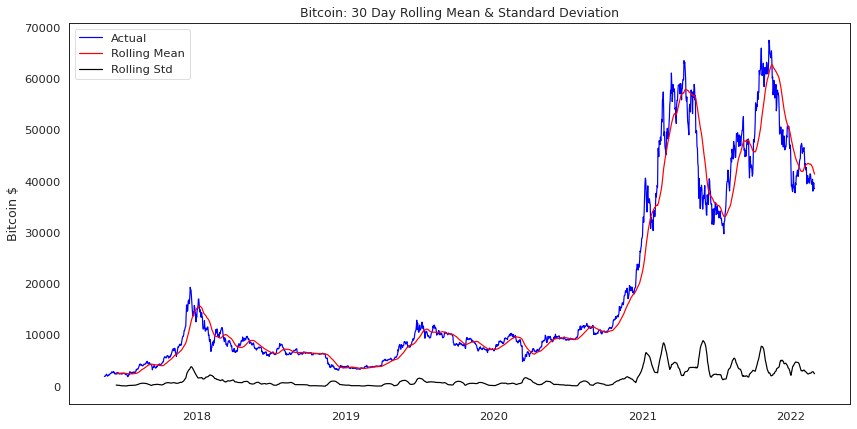

<Results of Dickey-Fuller Test>
Test Statistic                  -1.0216
p-value                          0.7453
#Lags Used                      21.0000
Number of Observations Used   1725.0000
Critical Value (1%)             -3.4341
Critical Value (5%)             -2.8632
Critical Value (10%)            -2.5677
dtype: float64


In [ ]:
dfs=[dfz,dfy,dfx,tek_ind_1,tek_ind_2]
df=reduce(lambda left,right: pd.merge(left,right,on='dtime'), dfs)
df=df.iloc[1188:]
df=df.set_index('dtime')

df1=df.loc[:,['BTC_Close']]
df2=df1.resample('D').agg(np.mean)

# df=df.set_index('dtime') #we can look at other features in our data too
# df1=df.loc[:,['NASDAQ']]
# df2=df1.resample('D').agg(np.mean)

def test_stationarity(timeseries):
    rolmean=timeseries.rolling(window=30).mean()
    rolstd=timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,7))
    sns.despine(left=True)
    orig=plt.plot(timeseries,color='blue',label='Actual')
    mean=plt.plot(rolmean,color='red',label='Rolling Mean')
    std=plt.plot(rolstd,color='black',label='Rolling Std')

    plt.ylabel('Bitcoin $')
    plt.legend(loc='best');plt.title('Bitcoin: 30 Day Rolling Mean & Standard Deviation')
    plt.show()
    
    print('<Results of Dickey-Fuller Test>')
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)

test_stationarity(df1['BTC_Close'].dropna())

We have accepted that there is a unit root in our series (it is non-stationary). If we look at our data and relate it to our previous distribution plots we see that there is a dramatic rise in price mid-way through 2020. 2021 onwards shows extremely volatile price behaviour. 2021 - 2022 rolling standard deviation is visibly frenetic. This is where our test data is, if our models aren't given volatile price behaviour to learn on it is hard to assume they will be able to predict this periods' volatile behaviour well, but lets see.

**VIF Feature Selection**

The following cells explore the multicollinearity of our data using VIF. Data is split into groups which are assumed to have influence over each other. Features are eliminated one by one based on VIF scores over 10. The largest score each time gets removed and then the data set is retested. The data is then wrapped into one and further reduction takes place.

In [ ]:
df=df.rename(columns={"Gtrend_bitcoin(Worldwide)":"Gtrend_bitcoin","Gtrend_buy_bitcoin(Worldwide)":"Gtrend_buy_bitcoin","Gtrend_bitcoin_ban(Worldwide)":"Gtrend_bitcoin_ban","Hash-Rate":"HashRate","Kraken_Bid-Ask_Spread":"Kraken_Bid_Ask_Spread"})

#Online sentiment analysis set
a=df[['BTC_Close','Gtrend_buy_bitcoin','Gtrend_bitcoin_ban']].fillna(0)

#Technical indicators set
b=df[['BTC_Close','daily_return','rsi','Williams_PCT_R','MACD','stod','ROC','Momentum','tema']]

#Market Data set
c=df[['BTC_Close','Crude_Oil_Brent','VIX','US_Bond_Price_2_yr','FTSE100','USD_EURO_XRATE']]

#Blockchain Data set
d=df[['BTC_Close','HashRate','Output_Value_Per_Day','Net_Value_to_Transactions']]

#Kraken Data set
e=df[['BTC_Close','BTC_Trading_Volume_Kraken_Euro','Kraken_BTC_Volatility','Kraken_Bid_Ask_Spread','BTC_Volume','ETH_Volume','XRP_Close','XRP_Volume']]

In [ ]:
# sns.pairplot(a)
# sns.pairplot(b)
# sns.pairplot(c)
# sns.pairplot(d)
# sns.pairplot(e)

In [ ]:
y,X=dmatrices(""" BTC_Close ~ Gtrend_buy_bitcoin+Gtrend_bitcoin_ban""",data=a,return_type="dataframe")
vif=pd.DataFrame([variance_inflation_factor(X.values,i) for i in range(X.shape[1])],index=X.columns,columns=['VIF_Score'])
#vif #uncomment to print scores

In [ ]:
y,X=dmatrices(""" BTC_Close ~ daily_return+rsi+Williams_PCT_R+MACD+stod+ROC+Momentum+tema""",data=b,return_type="dataframe")
vif=pd.DataFrame([variance_inflation_factor(X.values,i) for i in range(X.shape[1])],index=X.columns,columns=['VIF_Score'])
#vif

In [ ]:
y,X=dmatrices(""" BTC_Close ~ Crude_Oil_Brent+VIX+US_Bond_Price_2_yr+FTSE100+USD_EURO_XRATE""",data=c,return_type="dataframe")
vif=pd.DataFrame([variance_inflation_factor(X.values,i) for i in range(X.shape[1])],index=X.columns,columns=['VIF_Score'])
#vif

In [ ]:
y,X=dmatrices(""" BTC_Close ~ HashRate+Output_Value_Per_Day+Net_Value_to_Transactions""",data=d,return_type="dataframe")
vif=pd.DataFrame([variance_inflation_factor(X.values,i) for i in range(X.shape[1])],index=X.columns,columns=['VIF_Score'])
#vif

In [ ]:
y,X=dmatrices(""" BTC_Close ~ BTC_Trading_Volume_Kraken_Euro+Kraken_BTC_Volatility+Kraken_Bid_Ask_Spread+BTC_Volume+ETH_Volume+XRP_Close+XRP_Volume""",data=e,return_type="dataframe")
vif=pd.DataFrame([variance_inflation_factor(X.values,i) for i in range(X.shape[1])],index=X.columns,columns=['VIF_Score'])
#vif

In [ ]:
del b['BTC_Close']
del c['BTC_Close']
del d['BTC_Close']
del e['BTC_Close']

In [ ]:
dfs=[a,b,c,d,e]
dfvif=reduce(lambda left,right: pd.merge(left,right,on='dtime'), dfs) #we return back to dfvif later as our data set containing 26 features
y,X=dmatrices(""" BTC_Close ~ Gtrend_buy_bitcoin+Gtrend_bitcoin_ban+daily_return+rsi+Williams_PCT_R+MACD+stod+ROC+Momentum+tema+Crude_Oil_Brent+VIX+US_Bond_Price_2_yr+FTSE100+USD_EURO_XRATE+HashRate+Output_Value_Per_Day+Net_Value_to_Transactions+BTC_Trading_Volume_Kraken_Euro+Kraken_BTC_Volatility+Kraken_Bid_Ask_Spread+BTC_Volume+ETH_Volume+XRP_Close+XRP_Volume""",data=dfvif,return_type="dataframe")
vif=pd.DataFrame([variance_inflation_factor(X.values,i) for i in range(X.shape[1])],index=X.columns,columns=['VIF_Score'])
#vif

**PART 3**

**Base Model Testing**

Here we use Base Model LSTM with one layer, 32 Neurons (default for keras), adam optimisation, learning rate = 0.001 (default for keras), batch size = 32 (default for keras), epochs = 100 (with early stoppage), Glorot_uniform initializer (keras default weight initialization), 0.1 dropout (intended to avoid overfitting), no decay, no weight constraint. We will use different feature sets and test their loss scores. There are three feature groups: 1 feature, 58 features, VIF reduced 26 features. We build Base Model LSTMs each feature group, the first three cases here specify 'ReLU' activation, the second three cases specify 'TanH' activation. Plotting these results may give us some visual insight into how different feature sets affect performance and also how relu/tanh activation functions work and which one is better. Statistically testing whether the loss scores from forecasts are expected to be different will validate our results.

**Case 1: Base LSTM 1 feature ReLU activation**

In [ ]:
def create_dataset_onefeature(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0] #line takes only the first column
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

As we are inspecting the effectiveness of adding more data into our model we will first use only Bitcoin price to predict future values. Here I have chosen to use a 90% and 10% train test split. This gives our model at least some of the recent 2 year, high volatility data to train on.

Of course if we fit_transform on both testing and training we are introducing large bias into our model. Therefore we fit_transform on training and transform on test. Introducing our model to data that has been transformed on testing data could ultimately lead to biased (underfitted) results. This is not transferable to real world situations as we will be predicting data that we have not seen before.

In [ ]:
dataset1 = df['BTC_Close'].values #numpy.ndarray, only close price
dataset1 = dataset1.astype('float32')
dataset1 = np.reshape(dataset1, (-1, 1))
scaler1 = MinMaxScaler(feature_range=(0, 1))
train_size = int(len(dataset1) * 0.9) #90% train
test_size = len(dataset1) - train_size #10% test
train1, test1 = dataset1[0:train_size,:], dataset1[train_size:len(dataset1),:]
train1 = scaler1.fit_transform(train1)
test1 = scaler1.transform(test1)

look_back = 30
X_train1, y_train1 = create_dataset_onefeature(train1, look_back)
X_test1, y_test1 = create_dataset_onefeature(test1, look_back)

# reshape input to be [samples, time steps, features]
X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], 1))
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], 1))

es = EarlyStopping(monitor='val_loss', mode='min',verbose=0,patience=20) #20 epoch leeway, follow validation loss
mc = ModelCheckpoint('best_model1.h5', monitor='val_loss', mode='min', save_best_only=True) #save the weights from our models best epoch to best_model1.h5

X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((1541, 30, 1), (144, 30, 1), (1541,), (144,))

During training we further split training into training (90% of our new train) and validation (10%) for a total split of: train - 81%, val - 9%, and test - 10%. The weights that were used from our model epochs that resulted in the best validation loss are saved and used at test time. As we saw previously our final period is much more volatile so hopefully saving the weights from the lowest loss on this volatile validation period should provide better results on our test data.

In [ ]:
def create_model():
  model=Sequential()
  model.add(LSTM(units=32,activation='relu',input_shape=(X_train1.shape[1],X_train1.shape[2]))) #look_back=30, features=1, #return_sequences=True if we use more layers
  model.add(Dropout(0.1)) #one layer + dropout
  model.add(Dense(units=1)) #output
  optimizer=tf.keras.optimizers.Adam()
  model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
  return model
model1=create_model()
history1=model1.fit(X_train1, y_train1, validation_split=0.1, epochs=100, batch_size=32, callbacks=[es, mc]) #callback to model checkpoint

#model1.summary()

Epoch 1/100
44/44 [==============================] - 10s 125ms/step - loss: 0.0230 - mse: 0.0230 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 2/100
44/44 [==============================] - 5s 120ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0169 - val_mse: 0.0169
Epoch 3/100
44/44 [==============================] - 4s 99ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 4/100
44/44 [==============================] - 4s 93ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 5/100
44/44 [==============================] - 2s 47ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 6/100
44/44 [==============================] - 2s 47ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 7/100
44/44 [==============================] - 2s 48ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 8/100
44/44 [==============================] - 2s 47ms/step - loss:

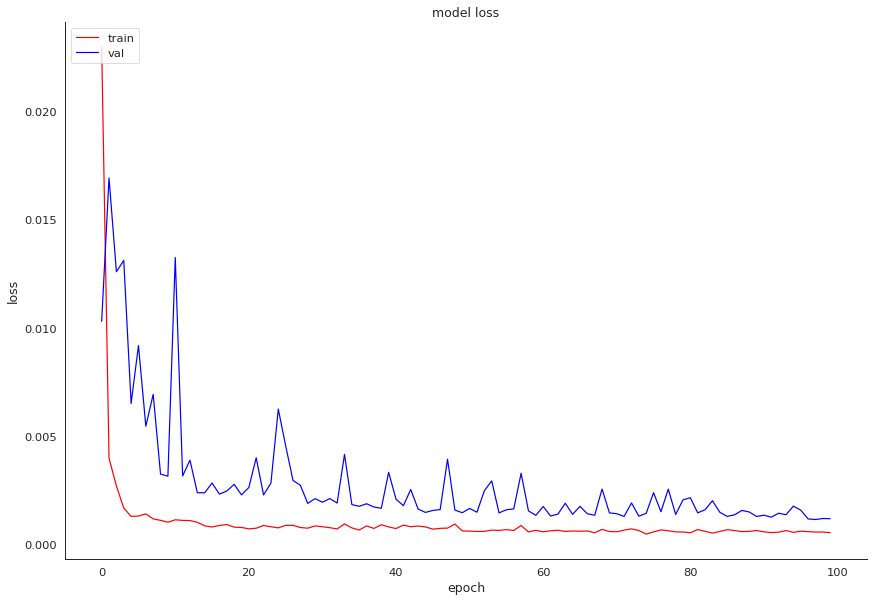

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history1.history['loss'], 'r')
plt.plot(history1.history['val_loss'], 'b')
plt.tight_layout()
sns.despine(top=True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

In [ ]:
saved_model1 = load_model('best_model1.h5') #get back our best model, i.e., the weights from the epoch used in training that had the lowest validation loss
train_predict1 = saved_model1.predict(X_train1) #use the saved model which is our best val loss
test_predict1 = saved_model1.predict(X_test1)
# invert predictions
train_predict1 = scaler1.inverse_transform(train_predict1)
#y_train=y_train.reshape(1541,1)
y_train1 = scaler1.inverse_transform([y_train1])
test_predict1 = scaler1.inverse_transform(test_predict1)
#y_test=y_test.reshape(144,1)
y_test1 = scaler1.inverse_transform([y_test1])

print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train1.transpose(), train_predict1[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test1.transpose(), test_predict1[:,0])))

Train Root Mean Squared Error: 1051.1418422412087
Test Root Mean Squared Error: 1988.395335942453


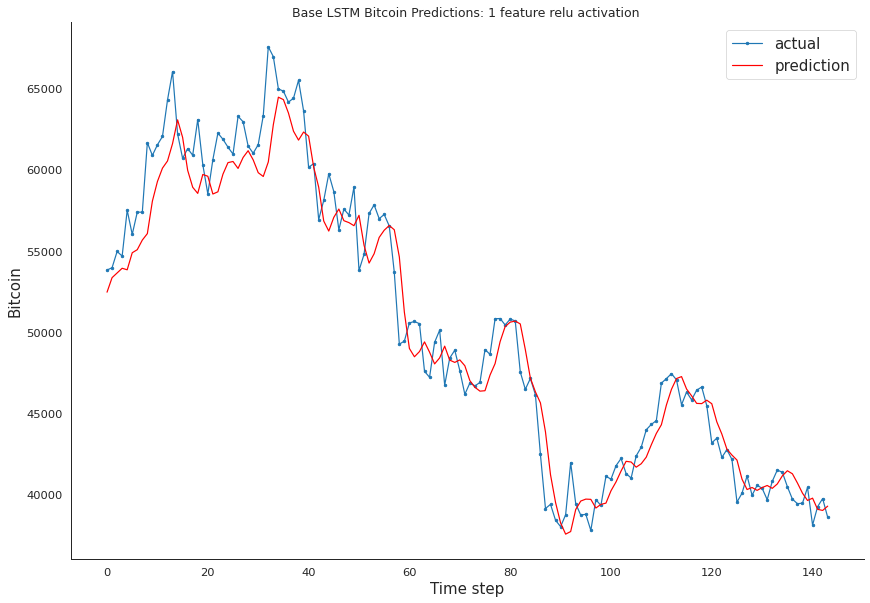

In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test1[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict1[:,0][:144], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Base LSTM Bitcoin Predictions: 1 feature relu activation ')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
'''The trading strategy utilised below is a heuristic. The logic of the strategy is buy / sell and assumes a selling of all 
   assets at the end of the day with subsequent re-evaluation of buying / selling positions once the next prediction
   is returned. Ultimately, the summed value of our output array - wrapped, indicates whether the strategy was profitable or not.
   These are simple returns and do not account for compound profits (holding an asset for more than one day if there were two 
   subsequent days of buying (positive) / selling (negative) forecasts). It also fails to account for any transaction fees.
   Close price 'bought' is taken to be the strike price that the exchange offers, in reality this may not be the case.'''

def totalbuysellpercentage(price,prediction,wrapper):
  
  for i in range(1,len(price)):
    if price[i-1] > price[i] and prediction[i-1] > prediction[i]: #if the price goes down and is predicted to go down
      wrapper.append(0) #we correctly decided not to buy, no profits no loss

    elif price[i-1] > price[i] and prediction[i-1] < prediction[i]: #if the price goes down but we predicted it to go up
      x=float(((price[i] - price[i-1]) / price[i-1]) * 100) #we could further multiply here to include transaction fees
      wrapper.append(x) #we incorrectly bought, take the difference of the actual prices, here it will be negative

    elif price[i-1] < price[i] and prediction[i-1] < prediction[i]: #if the price goes up and we predicted it to go up
      z=float(((price[i] - price[i-1]) / price[i-1]) * 100) #we could further multiply here to include transaction fees
      wrapper.append(z) #we correctly bought, take the difference of the actual prices, here it will be positive

    elif price[i-1] < price[i] and prediction[i-1] > prediction[i]: #if the price goes up and we predicted it to go down
      wrapper.append(0) #we incorrectly sold, no profits no loss

    else:
      wrapper.append(0) #there was no change in price
  
  return wrapper


def buyselldollar(price,prediction,wrapper):
  
  for i in range(1,len(price)):
    if price[i-1] > price[i] and prediction[i-1] > prediction[i]: #following our forecasting sequence
      wrapper.append(0)

    elif price[i-1] > price[i] and prediction[i-1] < prediction[i]:
      x=float(price[i] - price[i-1])
      wrapper.append(x)

    elif price[i-1] < price[i] and prediction[i-1] < prediction[i]:
      z=float(price[i] - price[i-1])
      wrapper.append(z)

    elif price[i-1] < price[i] and prediction[i-1] > prediction[i]:
      wrapper.append(0)

    else:
      wrapper.append(0)

  return wrapper


"""Placeing trades following the actual price performs far better for 
   1 feature forecasts which follow the close price more closely"""

def buyselldollaractual(price,prediction,wrapper):
  
  for i in range(1,len(price)):
    if price[i-1] > price[i] and price[i-1] > prediction[i]: #prediction against actual price
      wrapper.append(0)

    elif price[i-1] > price[i] and price[i-1] < prediction[i]:
      x=float(price[i] - price[i-1])
      wrapper.append(x)

    elif price[i-1] < price[i] and price[i-1] < prediction[i]:
      z=float(price[i] - price[i-1])
      wrapper.append(z)

    elif price[i-1] < price[i] and price[i-1] > prediction[i]:
      wrapper.append(0)

    else:
      wrapper.append(0)

  return wrapper

'''The trading strategy utilised below is a heuristic. The logic of the strategy is long / short and assumes a selling of all 
   assets at the end of the day with subsequent re-evaluation of buying / selling positions once the next prediction
   is returned. Ultimately, the summed value of our output array - wrapped, indicates whether the strategy was profitable or not.
   These are simple returns and do not account for compound profits (holding an asset for more than one day if there were two 
   subsequent days of buying (positive) / selling (negative) forecasts). It also fails to account for any transaction fees.
   Close price 'bought' is taken to be the strike price that the exchange offers, in reality this may not be the case.'''

def longshortdollar(price,prediction,wrapper):
  
  for i in range(1,len(price)):
    if price[i-1] > price[i] and prediction[i-1] > prediction[i]: #forecasting sequence
      p=float(abs(price[i-1] - price[i])) #it went down as we predicted so we need profit hence absolute
      wrapper.append(p)

    elif price[i-1] > price[i] and prediction[i-1] < prediction[i]:
      x=float(price[i]-price[i-1]) #went down predicted up return the loss
      wrapper.append(x)

    elif price[i-1] < price[i] and prediction[i-1] < prediction[i]:
      z=float(price[i]-price[i-1]) #take profit
      wrapper.append(z)

    elif price[i-1] < price[i] and prediction[i-1] > prediction[i]:
      y=float(-(price[i-1]-price[i])) #went up predicted down return the loss
      wrapper.append(y)

    else:
      wrapper.append(0)

  return wrapper

def longshortdollaractual(price,prediction,wrapper):
  
  for i in range(1,len(price)):
    if price[i-1] > price[i] and price[i-1] > prediction[i]: #actual sequence
      p=float(abs(price[i-1] - price[i]))
      wrapper.append(p)

    elif price[i-1] > price[i] and price[i-1] < prediction[i]:
      x=float(price[i]-price[i-1])
      wrapper.append(x)

    elif price[i-1] < price[i] and price[i-1] < prediction[i]:
      z=float(price[i]-price[i-1])
      wrapper.append(z)

    elif price[i-1] < price[i] and price[i-1] > prediction[i]:
      y=float(-(price[i-1]-price[i]))
      wrapper.append(y)

    else:
      wrapper.append(0)

  return wrapper

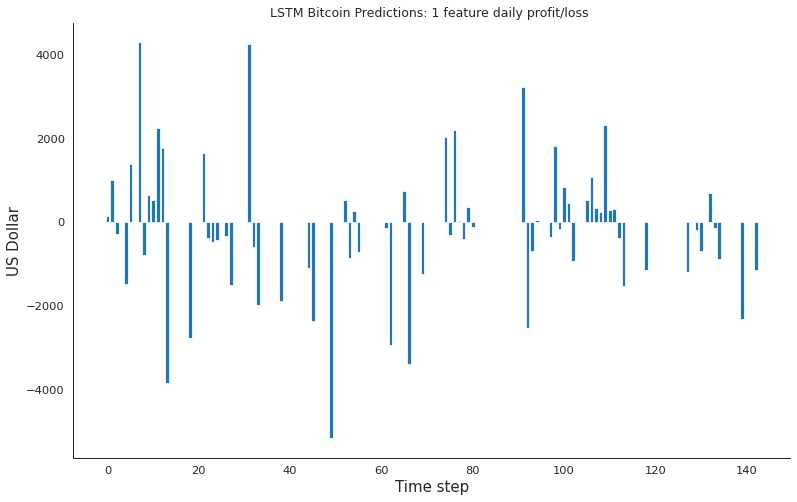

LSTM 1 feature ReLU: total return for 143 day period starting 2021-10-08 is $ -13701.31479928617


In [ ]:
y_testplot=y_test1.reshape(144,1) #reshape to plot

dollarprofits1=[] #create array for the daily profit/loss of our tradeds
buyselldollar(y_testplot,test_predict1,dollarprofits1)
dollarprofits1=np.array(dollarprofits1)

totalpercentageprofits1=[] #daily % profit/loss, didn't continue with this
totalbuysellpercentage(y_testplot,test_predict1,totalpercentageprofits1)
totalpercentageprofits1=np.array(totalpercentageprofits1)

aa=[x for x in range(143)]

plt.figure(figsize=(12,8))
plt.tight_layout()
plt.bar(aa,dollarprofits1)
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 1 feature daily profit/loss ')
plt.ylabel('US Dollar', size=15)
plt.xlabel('Time step', size=15)
plt.show()

print('LSTM 1 feature ReLU: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits1))
#print('this amounts to daily % profit / loss of', totalpercentageprofits1)

**Case 2: Base LSTM 58 features ReLU activation**

We redefine our create_dataset here to account for all columns in our dataset and continue with our feature exploration.

In [ ]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :] #line now takes all columns
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
dataset2 = df.values
dataset2 = dataset2.astype('float32')
train_size = int(len(dataset2) * 0.9)
test_size = len(dataset2) - train_size
train2, test2 = dataset2[0:train_size, :], dataset2[train_size:len(dataset2), :]

scaler2 = MinMaxScaler(feature_range=(0, 1))
train2 = scaler2.fit_transform(train2)
test2 = scaler2.transform(test2)
scaler2.min_,scaler2.scale_,scaler2.data_min_,scaler2.data_max_
#sklearn MinMaxScaler functionality allows us to get min and scale values for our columns to be used later for inverse scaling
#this is useful as inverse_transform expects the same number of features as it took as input.
#using this we can create an empty scaler and transfer just the close values

look_back = 30
X_train2, y_train2 = create_dataset(train2, look_back)  
X_test2, y_test2 = create_dataset(test2, look_back)

X_train2 = np.reshape(X_train2, (X_train2.shape[0], X_train2.shape[1], 58))
X_test2 = np.reshape(X_test2, (X_test2.shape[0], X_train2.shape[1], 58))

es = EarlyStopping(monitor='val_loss', mode='min',verbose=0,patience=20) #20 epoch leeway, verbose=1 prints loss for each epoch as they run through batches, please specify 0 if you don't wish to view this
mc = ModelCheckpoint('best_model2.h5', monitor='val_loss', mode='min', save_best_only=True) #save the weights from our models best epoch to best_model2.h5

In [ ]:
def create_model():
  model=Sequential()
  model.add(LSTM(units=32,activation='relu',input_shape=(X_train2.shape[1],X_train2.shape[2]))) #look_back=30, features=58
  model.add(Dropout(0.1))
  model.add(Dense(units=1))
  optimizer=tf.keras.optimizers.Adam()
  model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
  return model
model2=create_model()
history2=model2.fit(X_train2, y_train2, validation_split=0.1, epochs=100, batch_size=32, callbacks=[es, mc])

Epoch 1/100
44/44 [==============================] - 4s 55ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0393 - val_mse: 0.0393
Epoch 2/100
44/44 [==============================] - 2s 47ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 3/100
44/44 [==============================] - 2s 47ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 4/100
44/44 [==============================] - 2s 52ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0196 - val_mse: 0.0196
Epoch 5/100
44/44 [==============================] - 2s 49ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 6/100
44/44 [==============================] - 2s 49ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 7/100
44/44 [==============================] - 2s 47ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 8/100
44/44 [==============================] - 2s 49ms/step - loss: 0.

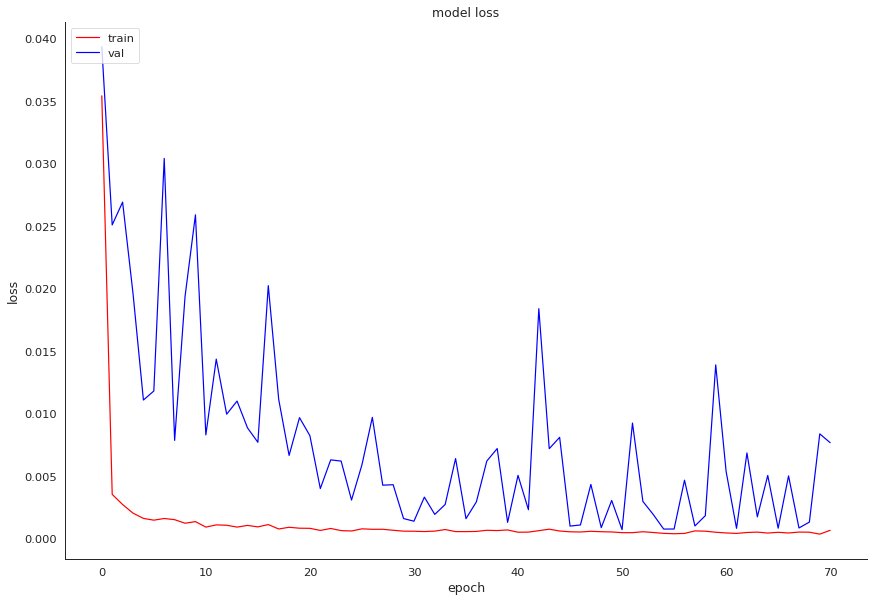

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history2.history['loss'], 'r')
plt.plot(history2.history['val_loss'], 'b')
plt.tight_layout()
sns.despine(top=True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

The validation loss is quite noisy. This could be because our validation set is the final 10% of our train data which if we refer back to our timeseries graph of BTC Close price is a very volatile period. Our model is predicting this volatile period using many features, which are fed to neurons which it then has to decide the optimal weights for. We could try smoothing our data by for instance, taking logs. This may have the effect of smoothing the volatility that the model is shown. It also could be because we have many more features which adds complexity to the model, finding optimal weights is now harder, multicollinearity is present in our 58 feature set.

In [ ]:
saved_model2 = load_model('best_model2.h5')
train_predict2=saved_model2.predict(X_train2)
test_predict2=saved_model2.predict(X_test2)

scale2=MinMaxScaler() #create new MinMaxScaler and use the values of scaler for our bitcoin close price column
scale2.min_,scale2.scale_,scale2.data_min_,scale2.data_max_=scaler2.min_[0],scaler2.scale_[0],scaler2.data_min_[0],scaler2.data_max_[0]

train_predict2=scale2.inverse_transform(train_predict2)
y_train2=scale2.inverse_transform([y_train2])
test_predict2=scale2.inverse_transform(test_predict2)
y_test2=scale2.inverse_transform([y_test2])

print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train2.transpose(), train_predict2[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test2.transpose(), test_predict2[:,0])))

Train Root Mean Squared Error: 989.1621609471532
Test Root Mean Squared Error: 3549.8430038782058


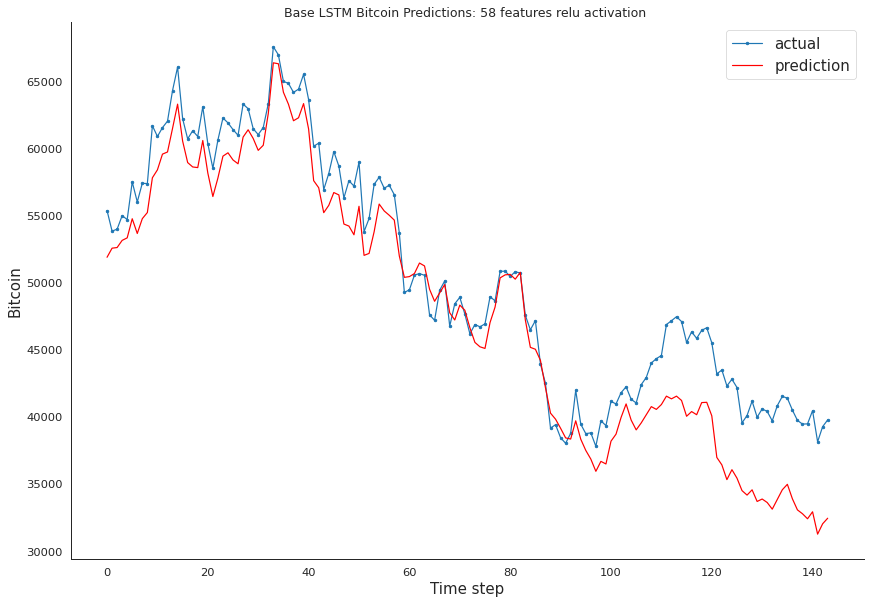

In [ ]:
aa=[x for x in range(144)] #print graph for our test predictions
plt.figure(figsize=(12,8))
plt.plot(aa, y_test2[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict2[:,0][:144], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Base LSTM Bitcoin Predictions: 58 features relu activation ')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
dollarprofits2=[] #array containing profit / loss of each days trade
buyselldollar(y_testplot,test_predict2,dollarprofits2)
dollarprofits2=np.array(dollarprofits2)

totalpercentageprofits2=[]
totalbuysellpercentage(y_testplot,test_predict2,totalpercentageprofits2)
totalpercentageprofits2=np.array(totalpercentageprofits2)

print('LSTM ReLU 58 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits2))
#print('this amounts to daily % profit / loss of', totalpercentageprofits2)

LSTM ReLU 58 features: total return for 143 day period starting 2021-10-08 is $ -3963.885376905193


**Case 3: Base LSTM 26 features ReLU activation**

In [ ]:
dataset3=dfvif.values
train_size = int(len(dataset3) * 0.9) 
test_size = len(dataset3) - train_size
train3, test3 = dataset3[0:train_size, :], dataset3[train_size:len(dataset3), :]

scaler3 = MinMaxScaler(feature_range=(0, 1))
train3 = scaler3.fit_transform(train3)
test3 = scaler3.transform(test3)
scaler3.min_,scaler3.scale_,scaler3.data_min_,scaler3.data_max_

look_back = 30
X_train3, y_train3 = create_dataset(train3, look_back)  
X_test3, y_test3 = create_dataset(test3, look_back)

X_train3 = np.reshape(X_train3, (X_train3.shape[0], X_train3.shape[1], 26))
X_test3 = np.reshape(X_test3, (X_test3.shape[0], X_test3.shape[1], 26))

es = EarlyStopping(monitor='val_loss', mode='min',verbose=0,patience=20) #20 epoch leeway
mc = ModelCheckpoint('best_model3.h5', monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
def create_model():
  model=Sequential()
  model.add(LSTM(units=32,activation='relu',input_shape=(X_train3.shape[1],X_train3.shape[2]))) #look_back=30, features=26
  model.add(Dropout(0.1))
  model.add(Dense(units=1))
  optimizer=tf.keras.optimizers.Adam()
  model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
  return model
model3=create_model()
history3=model3.fit(X_train3, y_train3, validation_split=0.1, epochs=100, batch_size=32, callbacks=[es,mc])

Epoch 1/100
44/44 [==============================] - 4s 54ms/step - loss: 0.0716 - mse: 0.0716 - val_loss: 0.1301 - val_mse: 0.1301
Epoch 2/100
44/44 [==============================] - 2s 50ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0273 - val_mse: 0.0273
Epoch 3/100
44/44 [==============================] - 2s 50ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 4/100
44/44 [==============================] - 2s 50ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0240 - val_mse: 0.0240
Epoch 5/100
44/44 [==============================] - 2s 47ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 6/100
44/44 [==============================] - 2s 52ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 7/100
44/44 [==============================] - 2s 47ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0264 - val_mse: 0.0264
Epoch 8/100
44/44 [==============================] - 2s 51ms/step - loss: 0.

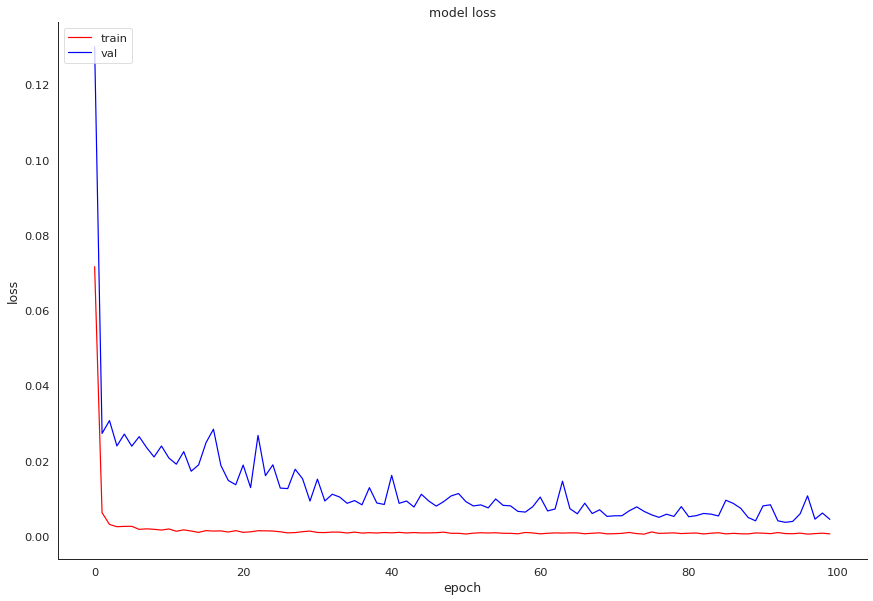

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history3.history['loss'], 'r')
plt.plot(history3.history['val_loss'], 'b')
plt.tight_layout()
sns.despine(top=True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

VIF feature set validation loss is much less noisy i.e., the curve jumps back and forth less. This is an interesting sign. Could it be to do with the reduced multicollinearity of features?

In [ ]:
saved_model3 = load_model('best_model3.h5')
train_predict3=saved_model3.predict(X_train3)
test_predict3=saved_model3.predict(X_test3)

scale3=MinMaxScaler() #create new MinMaxScaler and use the values of scaler for our bitcoin close price column
scale3.min_,scale3.scale_,scale3.data_min_,scale3.data_max_=scaler3.min_[0],scaler3.scale_[0],scaler3.data_min_[0],scaler3.data_max_[0]

train_predict3=scale3.inverse_transform(train_predict3)
y_train3=scale3.inverse_transform([y_train3])
test_predict3=scale3.inverse_transform(test_predict3)
y_test3=scale3.inverse_transform([y_test3])

print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train3.transpose(), train_predict3[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test3.transpose(), test_predict3[:,0])))

Train Root Mean Squared Error: 1387.6342298270242
Test Root Mean Squared Error: 2705.594649350563


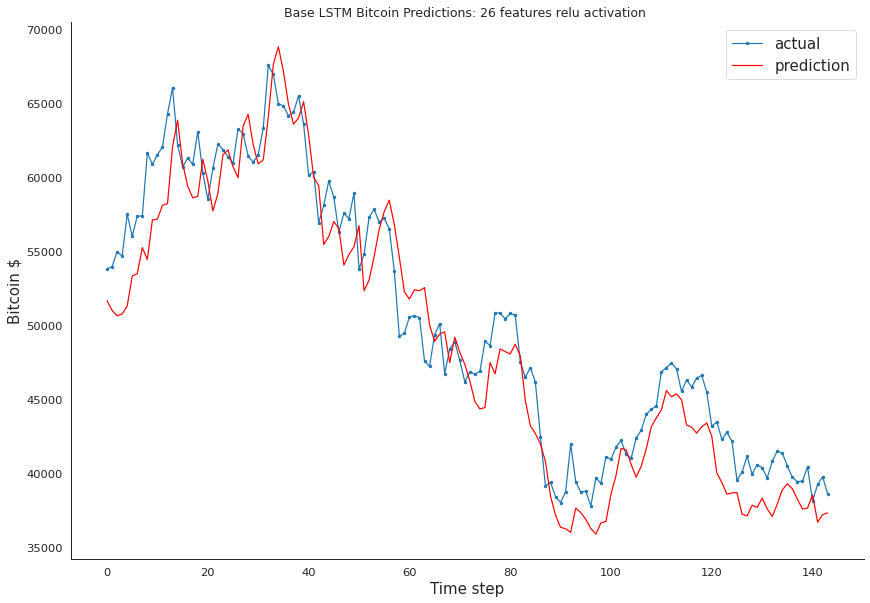

In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test3[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict3[:,0][:144], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Base LSTM Bitcoin Predictions: 26 features relu activation ')
plt.ylabel('Bitcoin $', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
dollarprofits3=[]
buyselldollar(y_testplot,test_predict3,dollarprofits3)
dollarprofits3=np.array(dollarprofits3)

totalpercentageprofits3=[]
totalbuysellpercentage(y_testplot,test_predict3,totalpercentageprofits3)
totalpercentageprofits3=np.array(totalpercentageprofits3)

print('LSTM ReLU 26 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits3))
#print('this amounts to daily % profit / loss of', totalpercentageprofits3)

LSTM ReLU 26 features: total return for 143 day period starting 2021-10-08 is $ -4387.183779986153


**Case 4: Base LSTM 1 feature with TanH activation**

Now lets look at which feature set appears the best for our LSTM with 'tanh' activation function. This section runs a lot faster as tanh activation is supported for CuDNN.

In [ ]:
dfs=[dfz,dfy,dfx,tek_ind_1,tek_ind_2]
df=reduce(lambda left,right: pd.merge(left,right,on='dtime'), dfs)
df=df.dropna(axis=0,how='any')
df.set_index('dtime')
df=df.iloc[1188:]

dataset4 = df['BTC_Close'].values #numpy.ndarray
dataset4 = dataset4.astype('float32')
dataset4 = np.reshape(dataset4, (-1, 1))
scaler4 = MinMaxScaler(feature_range=(0, 1))
train_size = int(len(dataset4) * 0.9)
test_size = len(dataset4) - train_size
train4, test4 = dataset4[0:train_size,:], dataset4[train_size:len(dataset4),:]
train4 = scaler4.fit_transform(train4)
test4 = scaler4.transform(test4)
    
look_back = 30
X_train4, y_train4 = create_dataset_onefeature(train4, look_back)
X_test4, y_test4 = create_dataset_onefeature(test4, look_back)

# reshape input to be [samples, time steps, features]
X_train4 = np.reshape(X_train4, (X_train4.shape[0], X_train4.shape[1], 1))
X_test4 = np.reshape(X_test4, (X_test4.shape[0], X_test4.shape[1], 1))

es = EarlyStopping(monitor='val_loss', mode='min',verbose=0,patience=20) #20 epoch leeway
mc = ModelCheckpoint('best_model4.h5', monitor='val_loss', mode='min', save_best_only=True)

X_train4.shape, X_test4.shape, y_train4.shape, y_test4.shape

((1541, 30, 1), (144, 30, 1), (1541,), (144,))

In [ ]:
def create_model():
  model=Sequential()
  model.add(LSTM(units=32,input_shape=(X_train4.shape[1],X_train4.shape[2]))) #look_back=30, features=58
  model.add(Dropout(0.1))
  model.add(Dense(units=1))
  optimizer=tf.keras.optimizers.Adam()
  model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
  return model
model4=create_model()
history4=model4.fit(X_train4, y_train4, validation_split=0.1, epochs=100, batch_size=32, callbacks=[es,mc])

Epoch 1/100
44/44 [==============================] - 4s 15ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0170 - val_mse: 0.0170
Epoch 2/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 3/100
44/44 [==============================] - 0s 4ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 4/100
44/44 [==============================] - 0s 5ms/step - loss: 8.3868e-04 - mse: 8.3868e-04 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 5/100
44/44 [==============================] - 0s 5ms/step - loss: 9.7987e-04 - mse: 9.7987e-04 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 6/100
44/44 [==============================] - 0s 5ms/step - loss: 7.8395e-04 - mse: 7.8395e-04 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 7/100
44/44 [==============================] - 0s 5ms/step - loss: 7.8978e-04 - mse: 7.8978e-04 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 8/100
44/44 [==============================]

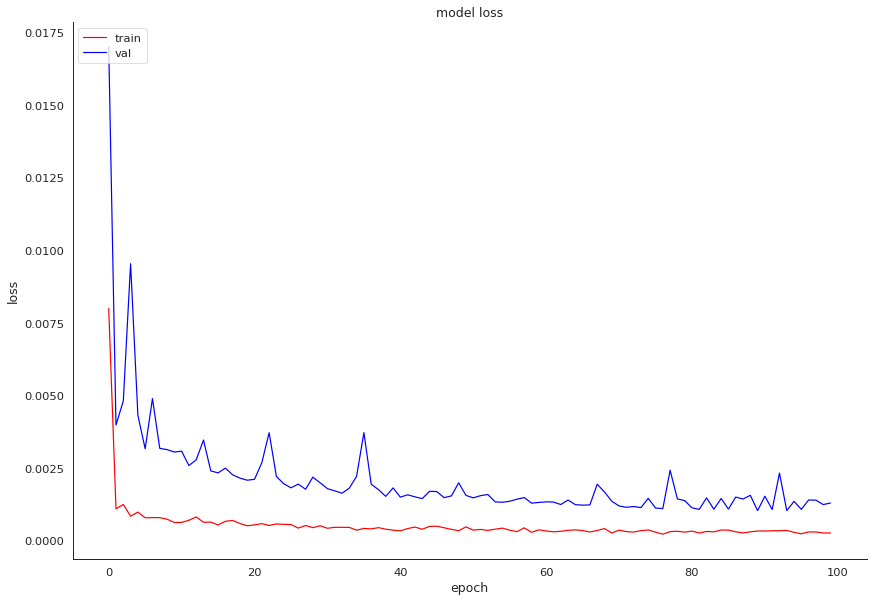

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history4.history['loss'], 'r')
plt.plot(history4.history['val_loss'], 'b')
plt.tight_layout()
sns.despine(top=True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

In [ ]:
saved_model4 = load_model('best_model4.h5')
train_predict4 = saved_model4.predict(X_train4)
test_predict4 = saved_model4.predict(X_test4)
# invert predictions
train_predict4 = scaler4.inverse_transform(train_predict4)
y_train4 = scaler4.inverse_transform([y_train4])
test_predict4 = scaler4.inverse_transform(test_predict4)
y_test4 = scaler4.inverse_transform([y_test4])

print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train4.transpose(), train_predict4[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test4.transpose(), test_predict4[:,0])))

Train Root Mean Squared Error: 986.5972345351222
Test Root Mean Squared Error: 1776.6675181139979


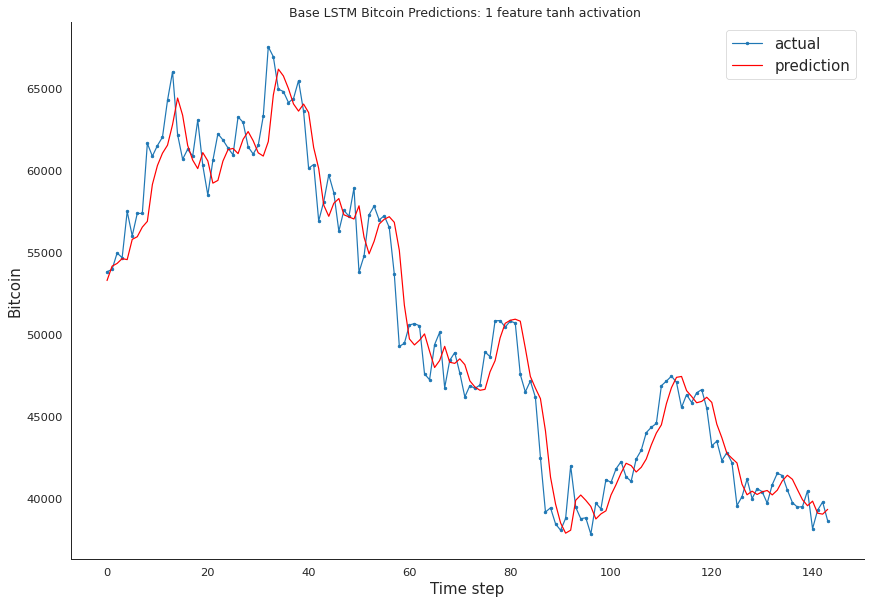

In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test4[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict4[:,0][:144], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Base LSTM Bitcoin Predictions: 1 feature tanh activation ')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
dollarprofits4=[]
buyselldollar(y_testplot,test_predict4,dollarprofits4)
dollarprofits4=np.array(dollarprofits4)

totalpercentageprofits4=[]
totalbuysellpercentage(y_testplot,test_predict4,totalpercentageprofits4)
totalpercentageprofits4=np.array(totalpercentageprofits4)

print('LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits4))
#print('this amounts to daily % profit / loss of', totalpercentageprofits4)

LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $ -13560.511895495118


**Case 5: Base LSTM 58 features TanH activation**

In [ ]:
dfwrap = df.drop(['dtime'],axis=1)
dataset5=dfwrap.values
dataset5 = dataset5.astype('float32')
train_size = int(len(dataset5) * 0.9)
test_size = len(dataset5) - train_size
train5, test5 = dataset5[0:train_size, :], dataset5[train_size:len(dataset5), :]

scaler5 = MinMaxScaler(feature_range=(0, 1))
train5 = scaler5.fit_transform(train5)
test5 = scaler5.transform(test5)
scaler5.min_,scaler5.scale_,scaler5.data_min_,scaler5.data_max_

look_back = 30
X_train5, y_train5 = create_dataset(train5, look_back)  
X_test5, y_test5 = create_dataset(test5, look_back)

X_train5 = np.reshape(X_train5, (X_train5.shape[0], X_train5.shape[1], 58))
X_test5 = np.reshape(X_test5, (X_test5.shape[0], X_train5.shape[1], 58))

es = EarlyStopping(monitor='val_loss', mode='min',verbose=0,patience=20) #20 epoch leeway
mc = ModelCheckpoint('best_model5.h5', monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
def create_model():
  model=Sequential()
  model.add(LSTM(units=32,input_shape=(X_train5.shape[1],X_train5.shape[2]))) #look_back=30, features=58
  model.add(Dropout(0.1))
  model.add(Dense(units=1))
  optimizer=tf.keras.optimizers.Adam()
  model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
  return model
model5=create_model()
history5=model5.fit(X_train5, y_train5, validation_split=0.1, epochs=100, batch_size=32, callbacks=[es,mc])

Epoch 1/100
44/44 [==============================] - 2s 14ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 2/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 3/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 4/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 5/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 6/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 7/100
44/44 [==============================] - 0s 5ms/step - loss: 9.0992e-04 - mse: 9.0992e-04 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 8/100
44/44 [==============================] - 0s 5ms/step - loss: 7

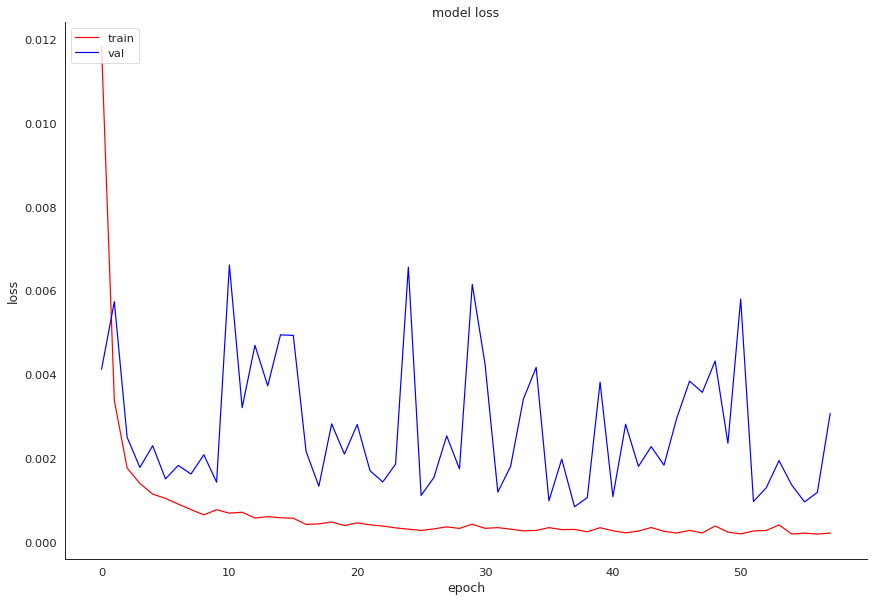

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history5.history['loss'], 'r')
plt.plot(history5.history['val_loss'], 'b')
plt.tight_layout()
sns.despine(top=True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

Again the validation loss is very noisy on our 58 features set, maybe LSTM cannot handle so many features given the base model parameters provided.

In [ ]:
saved_model5=load_model('best_model5.h5')
train_predict5=model5.predict(X_train5)
test_predict5=model5.predict(X_test5)

scale5=MinMaxScaler() #create new MinMaxScaler and use the values of scaler for our bitcoin close price column
scale5.min_,scale5.scale_,scale5.data_min_,scale5.data_max_=scaler5.min_[0],scaler5.scale_[0],scaler5.data_min_[0],scaler5.data_max_[0]

train_predict5=scale5.inverse_transform(train_predict5)
y_train5=scale5.inverse_transform([y_train5])
test_predict5=scale5.inverse_transform(test_predict5)
y_test5=scale5.inverse_transform([y_test5])

print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train5.transpose(), train_predict5[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test5.transpose(), test_predict5[:,0])))

Train Root Mean Squared Error: 1216.309184289273
Test Root Mean Squared Error: 8141.6648736824745


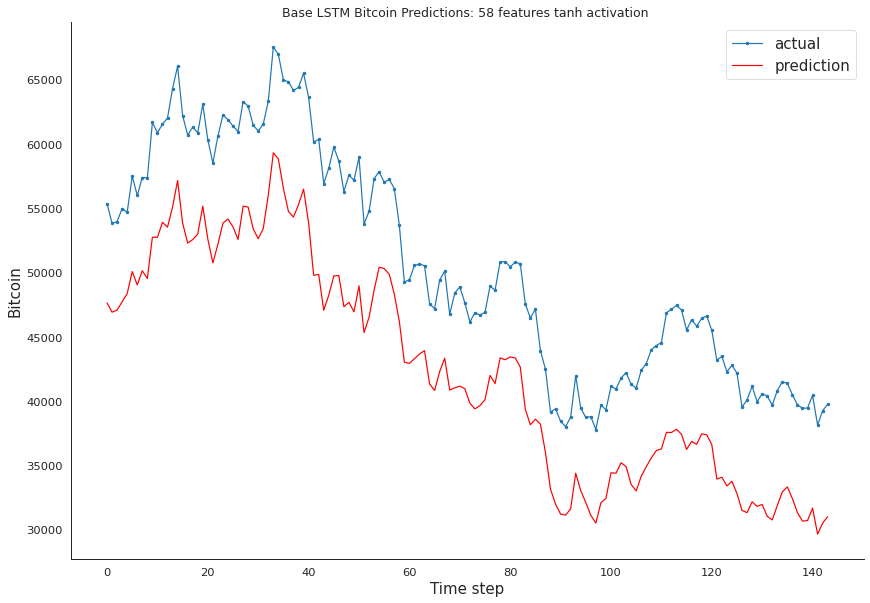

In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test5[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict5[:,0][:144], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Base LSTM Bitcoin Predictions: 58 features tanh activation ')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
dollarprofits5=[]
buyselldollar(y_testplot,test_predict5,dollarprofits5)
dollarprofits5=np.array(dollarprofits5)

totalpercentageprofits5=[]
totalbuysellpercentage(y_testplot,test_predict5,totalpercentageprofits5)
totalpercentageprofits5=np.array(totalpercentageprofits5)

print('LSTM TanH 58 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits5))
#print('this amounts to daily % profit / loss of', totalpercentageprofits5)

LSTM TanH 58 features: total return for 143 day period starting 2021-10-08 is $ -8892.464943154082


**Case 6: Base LSTM 26 features TanH activation**

In [ ]:
dataset6=dfvif.values
train_size = int(len(dataset6) * 0.9) 
test_size = len(dataset6) - train_size
train6, test6 = dataset6[0:train_size, :], dataset6[train_size:len(dataset6), :]

scaler6 = MinMaxScaler(feature_range=(0, 1))
train6 = scaler6.fit_transform(train6)
test6 = scaler6.transform(test6)
scaler6.min_,scaler6.scale_,scaler6.data_min_,scaler6.data_max_

look_back = 30
X_train6, y_train6 = create_dataset(train6, look_back)  
X_test6, y_test6 = create_dataset(test6, look_back)

X_train6 = np.reshape(X_train6, (X_train6.shape[0], X_train6.shape[1], 26))
X_test6 = np.reshape(X_test6, (X_test6.shape[0], X_test6.shape[1], 26))

es = EarlyStopping(monitor='val_loss', mode='min',verbose=0,patience=20) #20 epoch leeway
mc = ModelCheckpoint('best_model6.h5', monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
def create_model():
  model=Sequential()
  model.add(LSTM(units=32,input_shape=(X_train6.shape[1],X_train6.shape[2]))) #look_back=30, features=26
  model.add(Dropout(0.1))
  model.add(Dense(units=1))
  optimizer=tf.keras.optimizers.Adam()
  model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
  return model
model6=create_model()
history6=model6.fit(X_train6, y_train6, validation_split=0.1, epochs=100, batch_size=32, callbacks=[es,mc])

Epoch 1/100
44/44 [==============================] - 2s 14ms/step - loss: 0.0394 - mse: 0.0394 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 2/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0102 - val_mse: 0.0102
Epoch 3/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 4/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 5/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 6/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 7/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 8/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0025 - 

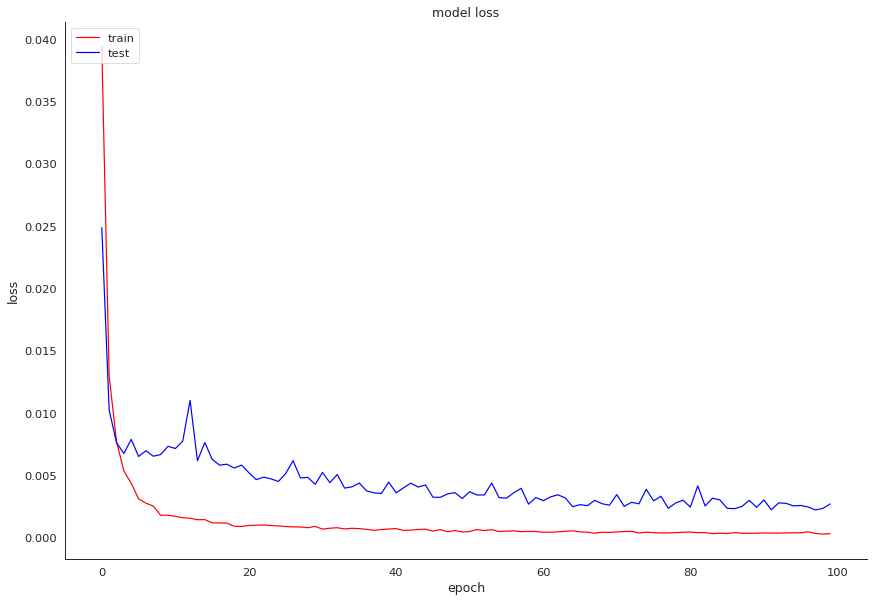

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history6.history['loss'], 'r')
plt.plot(history6.history['val_loss'], 'b')
plt.tight_layout()
sns.despine(top=True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show();

In [ ]:
saved_model6=load_model('best_model6.h5')
train_predict6=model6.predict(X_train6)
test_predict6=model6.predict(X_test6)

scale6=MinMaxScaler() #create new MinMaxScaler and use the values of scaler for our bitcoin close price column
scale6.min_,scale6.scale_,scale6.data_min_,scale6.data_max_=scaler6.min_[0],scaler6.scale_[0],scaler6.data_min_[0],scaler6.data_max_[0]

train_predict6=scale6.inverse_transform(train_predict6)

y_train6=scale6.inverse_transform([y_train6])
test_predict6=scale6.inverse_transform(test_predict6)
y_test6=scale6.inverse_transform([y_test6])

print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train6.transpose(), train_predict6[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test6.transpose(), test_predict6[:,0])))

Train Root Mean Squared Error: 1331.8290244115356
Test Root Mean Squared Error: 2912.5302207675873


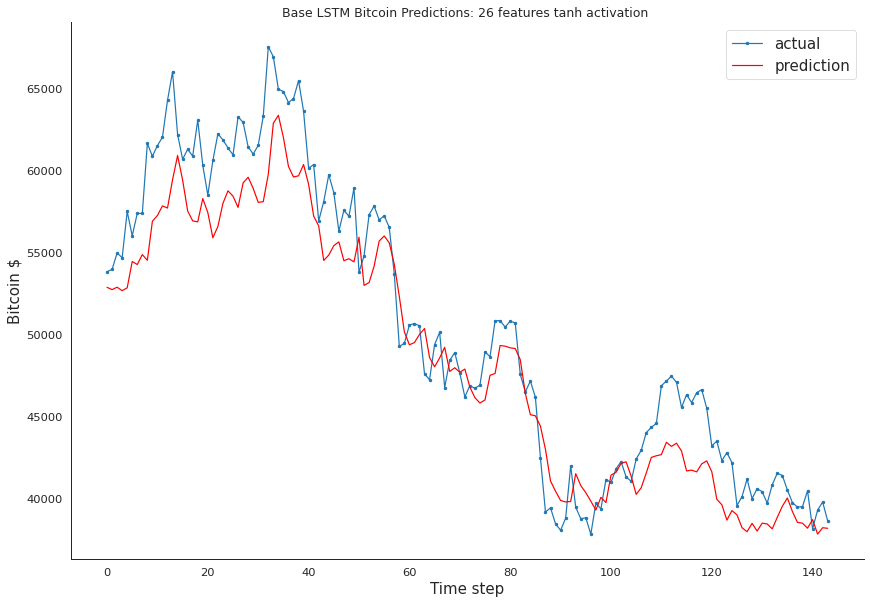

In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test6[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict6[:,0][:144], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Base LSTM Bitcoin Predictions: 26 features tanh activation ')
plt.ylabel('Bitcoin $', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
dollarprofits6=[]
buyselldollar(y_testplot,test_predict6,dollarprofits6)
dollarprofits6=np.array(dollarprofits6)

totalpercentageprofits6=[]
totalbuysellpercentage(y_testplot,test_predict6,totalpercentageprofits6)
totalpercentageprofits6=np.array(totalpercentageprofits6)

print('LSTM TanH 26 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits6))
#print('this amounts to daily % profit / loss of', totalpercentageprofits6)

LSTM TanH 26 features: total return for 143 day period starting 2021-10-08 is $ -8774.970491542852


Graph: Base Model ReLU predictions

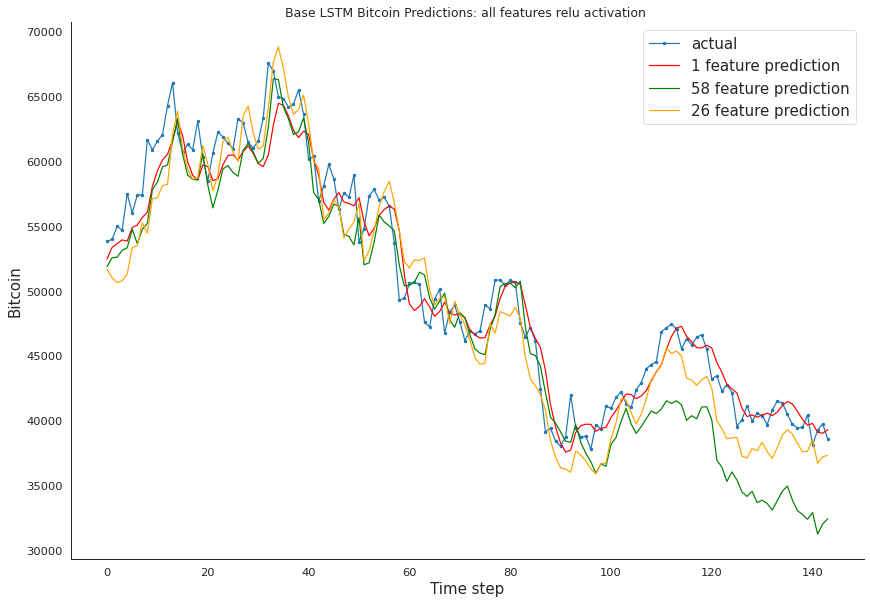

In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test3[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict1[:,0][:144], 'r', label="1 feature prediction")
plt.plot(aa, test_predict2[:,0][:144], 'g', label="58 feature prediction")
plt.plot(aa, test_predict3[:,0][:144], 'orange', label="26 feature prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Base LSTM Bitcoin Predictions: all features relu activation ')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

Graph: Base Model TanH predictions

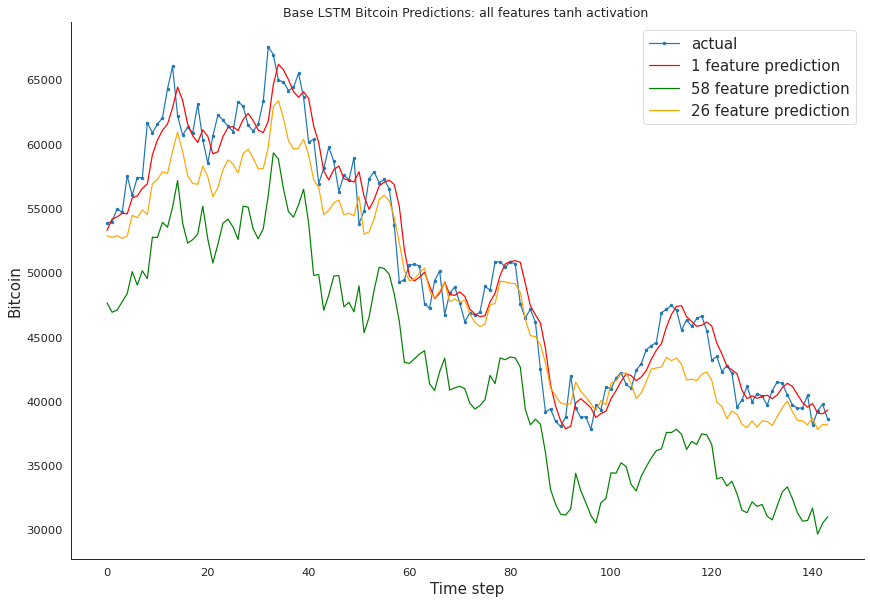

In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test4[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict4[:,0][:144], 'r', label="1 feature prediction")
plt.plot(aa, test_predict5[:,0][:144], 'g', label="58 feature prediction")
plt.plot(aa, test_predict6[:,0][:144], 'orange', label="26 feature prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Base LSTM Bitcoin Predictions: all features tanh activation ')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

Graph: base model all predictions

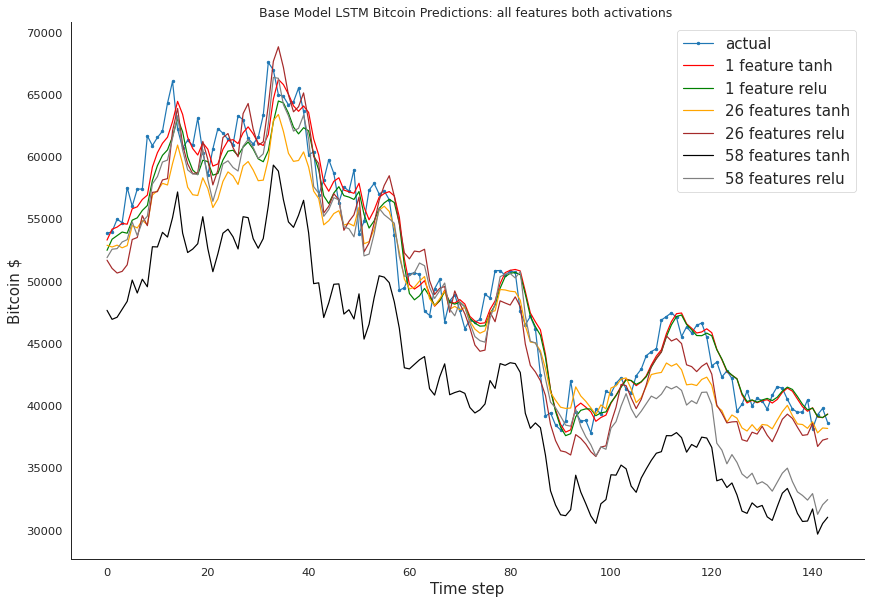

In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test3[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict4[:,0][:144], 'r', label="1 feature tanh")
plt.plot(aa, test_predict1[:,0][:144], 'g', label="1 feature relu")
plt.plot(aa, test_predict6[:,0][:144], 'orange', label="26 features tanh")
plt.plot(aa, test_predict3[:,0][:144], 'brown', label="26 features relu")
plt.plot(aa, test_predict5[:,0][:144], 'black', label="58 features tanh")
plt.plot(aa, test_predict2[:,0][:144], 'grey', label="58 features relu")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Base Model LSTM Bitcoin Predictions: all features both activations ')
plt.ylabel('Bitcoin $', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

**Hypothesis Testing for Base Model Forecasting**

Diebold-Mariano-Test: Test compares the forecast accuracy (loss) of two forecast methods. Follows a student T distribution with (T - 1) degrees of freedom. The null hypothesis H0 is that the forecast errors coming from the two forecasts bring about the same loss i.e., they are no different. Our Alternative Hypothesis H1 is that our two forecasts have different loss. Here we will reject H0 when the absolute value our DM statistic is greater than 2.58. 

We use two tailed Z-scores as critical values and weight these against the absolute value of our DM test statistic to prove within some confidence interval whether or not our forecast MSE losses are significantly different.

Z-score 5% = 1.96 (95% confidence in our result),


Z-score 1% = 2.58 (99% confidence in our result)

Rejecting our null hypothesis here means that we have shown that 1 feature predictions are expected to be different based on our test statistic mean squared error. This can be seen visually on the graphs above. However, be wary of generalising these test results to the performance of models. All base model predictions exhibited lagged behaviour, lowest RMSE does not necessarily infer the best predictions as we are attempting to action these results by, for instance buying / selling bitcoin. In this sense our models ability predict changes in price behaviour may be more important than RMSE for a buy sell strategy.

First I gather back the testing scores to see which is best

In [ ]:
print('Base LSTM 1 feature ReLU')
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train1.transpose(), train_predict1[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test1.transpose(), test_predict1[:,0])))

print('\nBase LSTM 58 features ReLU')
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train2.transpose(), train_predict2[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test2.transpose(), test_predict2[:,0])))

print('\nBase LSTM 26 features ReLU')
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train3.transpose(), train_predict3[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test3.transpose(), test_predict3[:,0])))

print('\nBase LSTM 1 feature TanH')
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train4.transpose(), train_predict4[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test4.transpose(), test_predict4[:,0])))

print('\nBase LSTM 58 features TanH')
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train5.transpose(), train_predict5[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test5.transpose(), test_predict5[:,0])))

print('\nBase LSTM 26 features TanH')
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train6.transpose(), train_predict6[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test6.transpose(), test_predict6[:,0])))

Base LSTM 1 feature ReLU
Train Root Mean Squared Error: 1051.1418422412087
Test Root Mean Squared Error: 1988.395335942453

Base LSTM 58 features ReLU
Train Root Mean Squared Error: 989.1621609471532
Test Root Mean Squared Error: 3549.8430038782058

Base LSTM 26 features ReLU
Train Root Mean Squared Error: 1387.6342298270242
Test Root Mean Squared Error: 2705.594649350563

Base LSTM 1 feature TanH
Train Root Mean Squared Error: 986.5972345351222
Test Root Mean Squared Error: 1776.6675181139979

Base LSTM 58 features TanH
Train Root Mean Squared Error: 1216.309184289273
Test Root Mean Squared Error: 8141.6648736824745

Base LSTM 26 features TanH
Train Root Mean Squared Error: 1331.8290244115356
Test Root Mean Squared Error: 2912.5302207675873


And also re-print all the profit / loss from buy / sell.

In [ ]:
print('Base LSTM ReLU 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits1))

print('\nBase LSTM ReLU 58 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits2))

print('\nBase LSTM ReLU 26 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits3))

print('\nBase LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits4))

print('\nBase LSTM TanH 58 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits5))

print('\nBase LSTM TanH 26 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits6))

Base LSTM ReLU 1 feature: total return for 143 day period starting 2021-10-08 is $ -13701.31479928617

Base LSTM ReLU 58 features: total return for 143 day period starting 2021-10-08 is $ -3963.885376905193

Base LSTM ReLU 26 features: total return for 143 day period starting 2021-10-08 is $ -4387.183779986153

Base LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $ -13560.511895495118

Base LSTM TanH 58 features: total return for 143 day period starting 2021-10-08 is $ -8892.464943154082

Base LSTM TanH 26 features: total return for 143 day period starting 2021-10-08 is $ -8774.970491542852


1 feature TanH had the best test RMSE scores of all base models so I test its forecasts against each other model.

**Test 1:** 1 feature TanH vs. 58 features ReLU

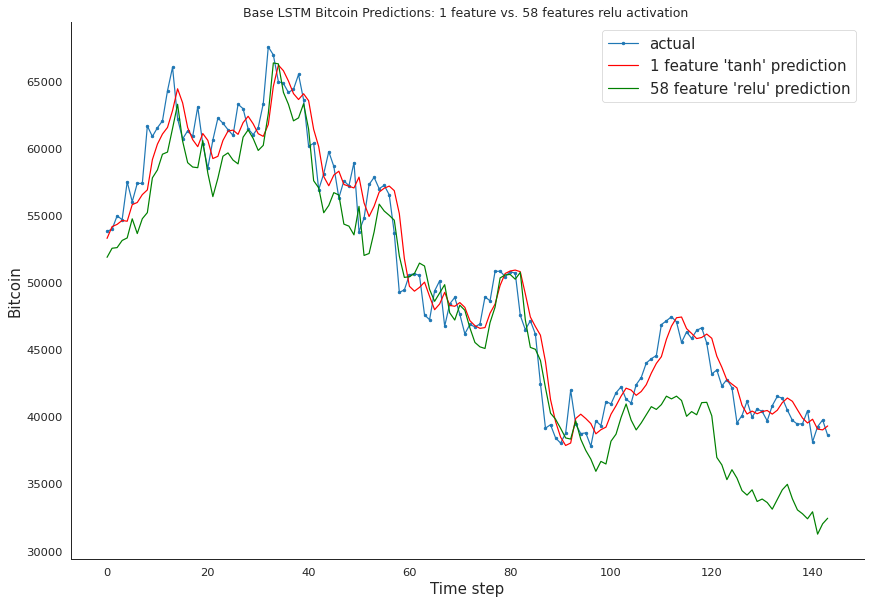

Test Root Mean Squared Error for: LSTM 1 feature TanH: 1776.6675181139979
Test Root Mean Squared Error for: LSTM 58 feature ReLU: 3549.8430038782058

 the value of our DM test statistic is [-7.57908073]
 our p value for our DM test is [3.48011922e-14]

 Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test4[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict4[:,0][:144], 'r', label="1 feature 'tanh' prediction")
plt.plot(aa, test_predict2[:,0][:144], 'g', label="58 feature 'relu' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Base LSTM Bitcoin Predictions: 1 feature tanh vs. 58 features relu activation ')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

y_teststat=y_test1.transpose() #re-transpose back from graph plotting format

print('Test Root Mean Squared Error for: LSTM 1 feature TanH:',np.sqrt(mean_squared_error(y_test4.transpose(), test_predict4[:,0])))
print('Test Root Mean Squared Error for: LSTM 58 feature ReLU:',np.sqrt(mean_squared_error(y_test2.transpose(), test_predict2[:,0])))

d_t_list1 = cul_d_t(MSE, y_teststat, test_predict4, test_predict2)
#print(d_t_list1)
print('\n the value of our DM test statistic is', cul_DM(d_t_list1))
print(' our p value for our DM test is', cul_P(d_t_list1))
if abs(cul_DM(d_t_list1)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Test 2:** 1 feature TanH vs. 26 features ReLU

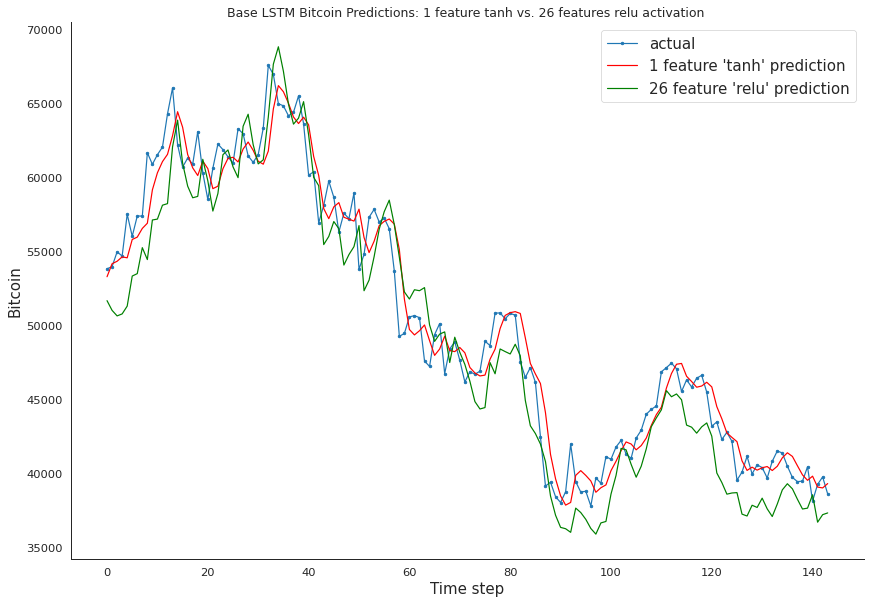

Test Root Mean Squared Error for: LSTM 1 feature ReLU: 1776.6675181139979
Test Root Mean Squared Error for: LSTM 26 feature ReLU: 2705.594649350563

 the value of our DM test statistic is [-6.43204932]
 the p value for our DM test is [1.25894869e-10]

 Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test4[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict4[:,0][:144], 'r', label="1 feature 'tanh' prediction")
plt.plot(aa, test_predict3[:,0][:144], 'g', label="26 feature 'relu' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Base LSTM Bitcoin Predictions: 1 feature tanh vs. 26 features relu activation ')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for: LSTM 1 feature ReLU:',np.sqrt(mean_squared_error(y_test1.transpose(), test_predict4[:,0])))
print('Test Root Mean Squared Error for: LSTM 26 feature ReLU:',np.sqrt(mean_squared_error(y_test3.transpose(), test_predict3[:,0])))

d_t_list2 = cul_d_t(MSE, y_teststat, test_predict4, test_predict3)
#print(d_t_list2)
print('\n the value of our DM test statistic is', cul_DM(d_t_list2))
print(' the p value for our DM test is', cul_P(d_t_list2))
if abs(cul_DM(d_t_list2)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Test 3:** Base LSTM 1 feature vs. 58 features forecast predictions with TanH

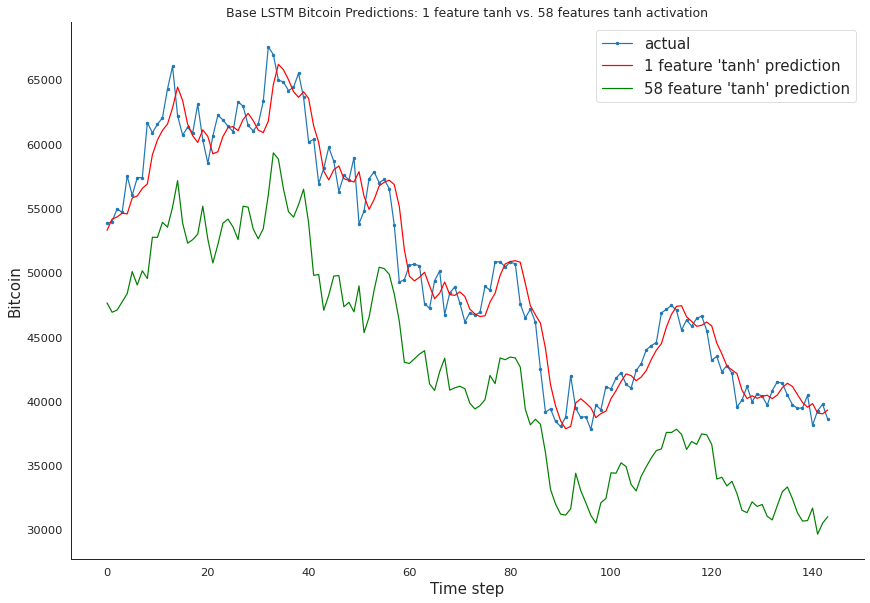

Test Root Mean Squared Error for 1 feature TanH: 1776.6675181139979
Test Root Mean Squared Error for 58 features TanH: 8141.6648736824745

 the value of our DM test statistic is [-26.71882023]
 our p value for our DM test is [2.84518147e-157]

 Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test4[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict4[:,0][:144], 'r', label="1 feature 'tanh' prediction")
plt.plot(aa, test_predict5[:,0][:144], 'g', label="58 feature 'tanh' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Base LSTM Bitcoin Predictions: 1 feature tanh vs. 58 features tanh activation')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for 1 feature TanH:',np.sqrt(mean_squared_error(y_test4.transpose(), test_predict4[:,0])))
print('Test Root Mean Squared Error for 58 features TanH:',np.sqrt(mean_squared_error(y_test5.transpose(), test_predict5[:,0])))

d_t_list3 = cul_d_t(MSE, y_teststat, test_predict4, test_predict5)
#print(d_t_list3)
print('\n the value of our DM test statistic is', cul_DM(d_t_list3))
print(' our p value for our DM test is', cul_P(d_t_list3))
if abs(cul_DM(d_t_list3)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Test 4:** LSTM 1 feature vs. 26 features forecast predictions with TanH

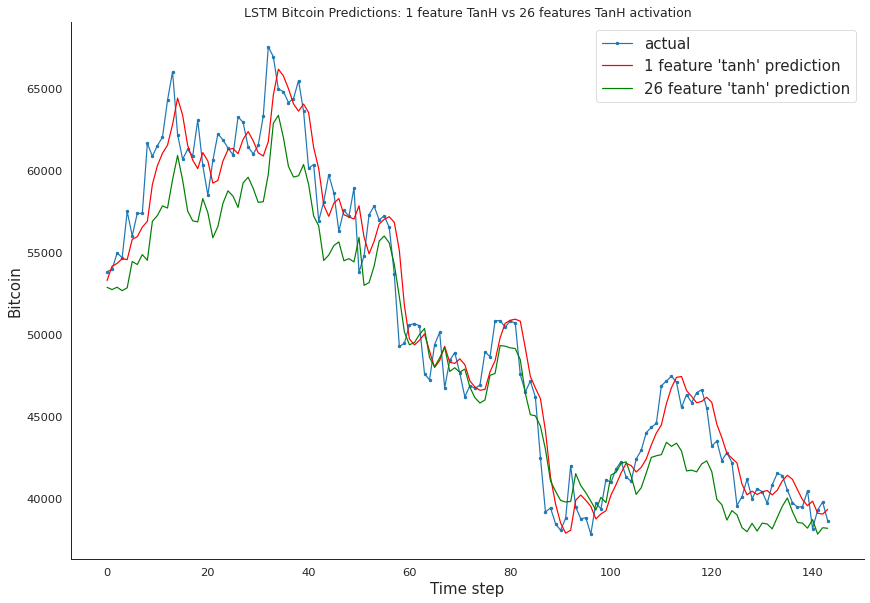

Test Root Mean Squared Error for 1 feature ReLU: 1776.6675181139979
Test Root Mean Squared Error for 26 features TanH: 2912.5302207675873

 the value of our DM test statistic is [-6.62927876]
 our p value for our DM test is [3.37331022e-11]

 Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test4[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict4[:,0][:144], 'r', label="1 feature 'tanh' prediction")
plt.plot(aa, test_predict6[:,0][:144], 'g', label="26 feature 'tanh' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 1 feature TanH vs 26 features TanH activation')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for 1 feature ReLU:',np.sqrt(mean_squared_error(y_test1.transpose(), test_predict4[:,0])))
print('Test Root Mean Squared Error for 26 features TanH:',np.sqrt(mean_squared_error(y_test6.transpose(), test_predict6[:,0])))

d_t_list4 = cul_d_t(MSE, y_teststat, test_predict4, test_predict6)
#print(d_t_list4)
print('\n the value of our DM test statistic is', cul_DM(d_t_list4))
print(' our p value for our DM test is', cul_P(d_t_list4))
if abs(cul_DM(d_t_list4)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

p-value is extremely small suggesting there is a very small chance that we have rejected the null when it is infact correct (type 1 error)

**Test 5:** LSTM 1 feature TanH vs. 1 feature ReLU

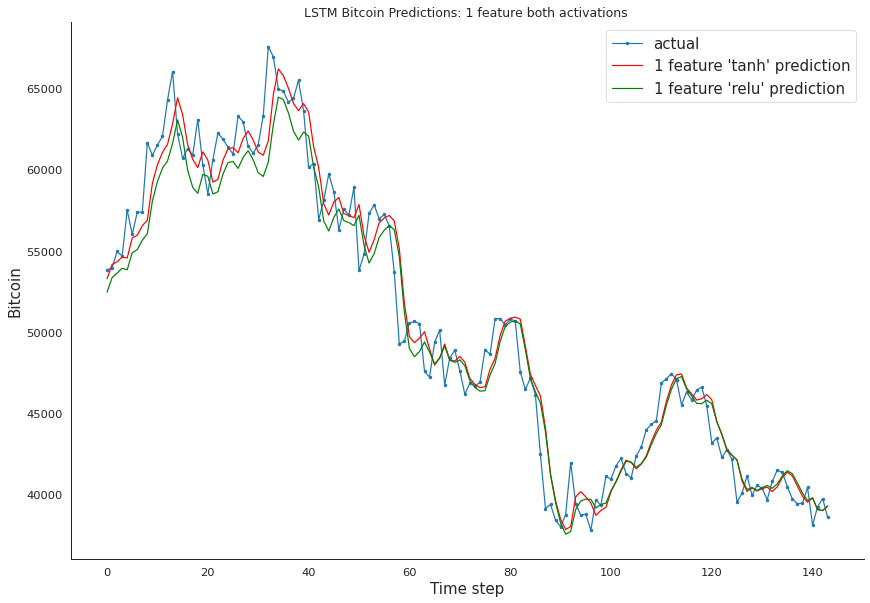

Test Root Mean Squared Error for 1 feature ReLU: 1776.6675181139979
Test Root Mean Squared Error for 1 feature TanH: 1988.395335942453

 the value of our DM test statistic is [-3.0141311]
 our p value for our DM test is [0.00257716]

 Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test4[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict4[:,0][:144], 'r', label="1 feature 'tanh' prediction")
plt.plot(aa, test_predict1[:,0][:144], 'g', label="1 feature 'relu' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 1 feature both activations ')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for 1 feature ReLU:',np.sqrt(mean_squared_error(y_test1.transpose(), test_predict4[:,0])))
print('Test Root Mean Squared Error for 1 feature TanH:',np.sqrt(mean_squared_error(y_test4.transpose(), test_predict1[:,0])))

d_t_list5 = cul_d_t(MSE, y_teststat, test_predict4, test_predict1)
#print(d_t_list5)
print('\n the value of our DM test statistic is', cul_DM(d_t_list5))
print(' our p value for our DM test is', cul_P(d_t_list5))
if abs(cul_DM(d_t_list5)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Test 6:** LSTM 58 Feature TanH vs. 58 feature ReLU

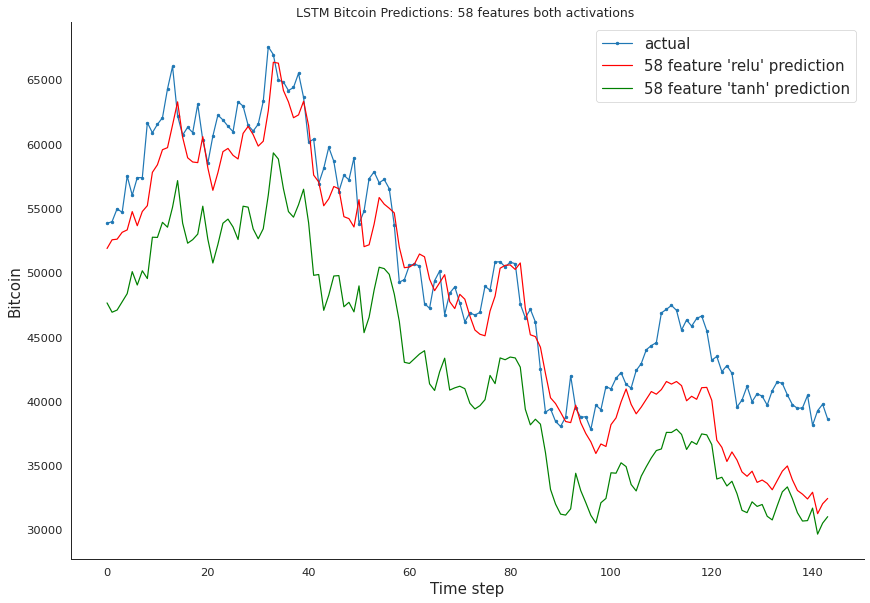

Test Root Mean Squared Error for 58 features ReLU: 3549.8430038782058
Test Root Mean Squared Error for 58 features TanH: 8141.6648736824745

 the value of our DM test statistic is [-26.02781731]
 our p value for our DM test is [2.39914838e-149]

 Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test4[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict2[:,0][:144], 'r', label="58 feature 'relu' prediction")
plt.plot(aa, test_predict5[:,0][:144], 'g', label="58 feature 'tanh' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 58 features both activations ')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for 58 features ReLU:',np.sqrt(mean_squared_error(y_test2.transpose(), test_predict2[:,0])))
print('Test Root Mean Squared Error for 58 features TanH:',np.sqrt(mean_squared_error(y_test5.transpose(), test_predict5[:,0])))

d_t_list6 = cul_d_t(MSE, y_teststat, test_predict2, test_predict5)
#print(d_t_list6)
print('\n the value of our DM test statistic is', cul_DM(d_t_list6))
print(' our p value for our DM test is', cul_P(d_t_list6))
if abs(cul_DM(d_t_list6)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

p-value is extremely small suggesting there is a very small chance that we have rejected the null when it is infact correct (type 1 error)

**Test 7:** LSTM 26 Features ReLU vs. 26 Features TanH

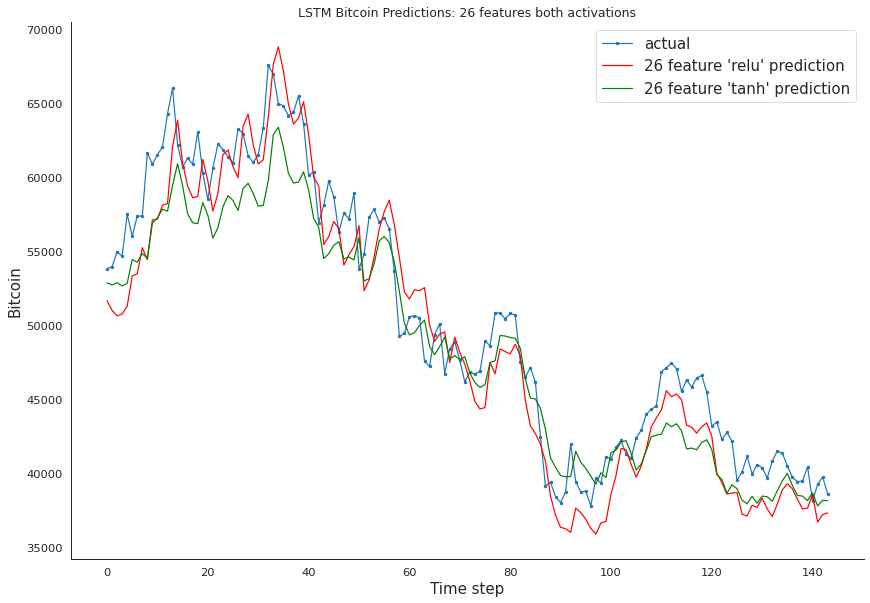

Test Root Mean Squared Error for 26 Features ReLU: 2705.594649350563
Test Root Mean Squared Error for 26 Features TanH: 2912.5302207675873

 the value of our DM test statistic is [-1.43686854]
 our p value for our DM test is [0.15075535]

 Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test4[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict3[:,0][:144], 'r', label="26 feature 'relu' prediction")
plt.plot(aa, test_predict6[:,0][:144], 'g', label="26 feature 'tanh' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 26 features both activations')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for 26 Features ReLU:',np.sqrt(mean_squared_error(y_test3.transpose(), test_predict3[:,0])))
print('Test Root Mean Squared Error for 26 Features TanH:',np.sqrt(mean_squared_error(y_test6.transpose(), test_predict6[:,0])))

d_t_list7 = cul_d_t(MSE, y_teststat, test_predict3, test_predict6)
#print(d_t_list7)
print('\n the value of our DM test statistic is', cul_DM(d_t_list7))
print(' our p value for our DM test is', cul_P(d_t_list7))
if abs(cul_DM(d_t_list7)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

p-value is extremely small suggesting there is a very small chance that we have rejected the null when it is infact correct (type 1 error).


What's interesting about this case is that the models forecasts start to converge after roughly timestep 70.

**PART 4**

**TUNING HYPERPARAMETERS**

We must gather our data back.

In [ ]:
# dataset = df['BTC_Close'].values #numpy.ndarray
# dataset = dataset.astype('float32')
# dataset = np.reshape(dataset, (-1, 1))
# scaler = MinMaxScaler(feature_range=(0, 1))
# train_size = int(len(dataset) * 0.9)
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# train = scaler.fit_transform(train)
# test = scaler.transform(test)
    
# look_back = 30
# X_train, y_train = create_dataset_onefeature(train, look_back)
# X_test, y_test = create_dataset_onefeature(test, look_back)

# # reshape input to be [samples, time steps, features]
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

**LSTM 1 feature TanH**

First we will look at **batch size** and **number of epochs**

https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

In [ ]:
# def create_model():
#   model=Sequential()
#   model.add(LSTM(units=32,input_shape=(X_train.shape[1],X_train.shape[2])))
#   #model.add(Dropout(0.1))
#   #model.add(LSTM(units=30,return_sequences=True))
#   #model.add(Dropout(0.1))
#   #model.add(LSTM(units=30,return_sequences=False))
#   #model.add(Dropout(0.1))
#   #model.add(Dense(units=25))
#   model.add(Dense(units=1))
#   model.compile(loss='mse',optimizer='adam',metrics=['mse'])
#   return model

# model=KerasRegressor(build_fn=create_model, verbose=0)

# batch_size=[8,16,32,64] #test a range of batch sizes
# epochs=[40,60,80] #test a range of epoch sizes
# param_grid=dict(batch_size=batch_size,epochs=epochs) #our arrays become a dictionary, values are ready to be fed to our model
# grid=GridSearchCV(estimator=model,param_grid=param_grid,n_jobs=-1,cv=5) #n_jobs=-1 attempts to perform our grid search in parallel
# grid_result=grid.fit(X_train,y_train) #fit the data to our model

# print("Best: %f using %s"%(grid_result.best_score_,grid_result.best_params_))
# means=grid_result.cv_results_['mean_test_score']
# stds=grid_result.cv_results_['std_test_score']
# params=grid_result.cv_results_['params']
# for mean, stdev, param in zip(means,stds,params):
#   print("%f (%f) with: %r"%(mean,stdev,param))

Now we consider **learning rate** and **decay** for our optimizer 'adam'

https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

In [ ]:
# def create_model(learn_rate=0.01,decay=0):
#   model=Sequential()
#   model.add(LSTM(units=32,input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dense(units=1))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model=KerasRegressor(build_fn=create_model, epochs=80, batch_size=8, verbose=0)

# learn_rate = [0.0001, 0.0005, 0.001, 0.005, 0.01]
# decay = [0.0, 0.01, 0.05]
# param_grid = dict(learn_rate=learn_rate, decay=decay)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Next we consider **network weight initialization** method, keras has a range to try from. **Default** is **Glorot (Xavier) Uniform.**

https://keras.io/api/layers/initializers/

In [ ]:
# def create_model(init_mode='uniform',learn_rate=0.0005,decay=0.0):
#   model=Sequential()
#   model.add(LSTM(units=32,kernel_initializer=init_mode,input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=80, batch_size=8, verbose=0)
# # define the grid search parameters
# init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
# param_grid = dict(init_mode=init_mode)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Now we consider our **Dropout Regularization**

https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

In [ ]:
# def create_model(init_mode='glorot_normal',learn_rate=0.0005,decay=0.0,dropout_rate=0.0,weight_constraint=1):
#   model=Sequential()
#   model.add(LSTM(units=32,kernel_initializer=init_mode,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dropout(dropout_rate))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=80, batch_size=8, verbose=0)
# # define the grid search parameters
# weight_constraint = [1, 2, 3, 4, 5]
# dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4]
# param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5) #n_jobs=-1 attempts to perform our grid search in parallel
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Finally we consider the **number of Neurons** in our Hidden Layer

https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/

In [ ]:
# def create_model(init_mode='glorot_normal',learn_rate=0.0005,decay=0.0,dropout_rate=0.0,weight_constraint=1,neurons=1):
#   model=Sequential()
  
#   model.add(LSTM(units=neurons,kernel_initializer=init_mode,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dropout(dropout_rate))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer, metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=80, batch_size=8, verbose=0)
# # define the grid search parameters
# neurons = [10, 20, 30, 40, 50, 60, 75, 100]
# param_grid = dict(neurons=neurons)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

**LSTM 1 feature ReLU**

In [ ]:
# dataset = df['BTC_Close'].values #numpy.ndarray
# dataset = dataset.astype('float32')
# dataset = np.reshape(dataset, (-1, 1))
# scaler = MinMaxScaler(feature_range=(0, 1))
# train_size = int(len(dataset) * 0.9)
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# train = scaler.fit_transform(train)
# test = scaler.transform(test)
    
# look_back = 30
# X_train, y_train = create_dataset_onefeature(train, look_back)
# X_test, y_test = create_dataset_onefeature(test, look_back)

# # reshape input to be [samples, time steps, features]
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# def create_model():
#   model=Sequential()
#   model.add(LSTM(units=32,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dense(units=1))
#   model.compile(loss='mse',optimizer='adam',metrics=['mse'])
#   return model

# model=KerasRegressor(build_fn=create_model, verbose=0)

# batch_size=[8,16,32,64] #test a range of batch sizes
# epochs=[40,60,80] #test a range of epoch sizes
# param_grid=dict(batch_size=batch_size,epochs=epochs) #our arrays become a dictionary, values are ready to be fed to our model
# grid=GridSearchCV(estimator=model,param_grid=param_grid,n_jobs=-1,cv=5) #n_jobs=-1 attempts to perform our grid search in parallel
# grid_result=grid.fit(X_train,y_train) #fit the data to our model

# print("Best: %f using %s"%(grid_result.best_score_,grid_result.best_params_))
# means=grid_result.cv_results_['mean_test_score']
# stds=grid_result.cv_results_['std_test_score']
# params=grid_result.cv_results_['params']
# for mean, stdev, param in zip(means,stds,params):
#   print("%f (%f) with: %r"%(mean,stdev,param))

In [ ]:
# def create_model(learn_rate=0.01,decay=0):
#   model=Sequential()
#   model.add(LSTM(units=32,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dense(units=1))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model=KerasRegressor(build_fn=create_model, epochs=40, batch_size=32, verbose=0)

# learn_rate = [0.0001, 0.0005, 0.001, 0.005, 0.01]
# decay = [0.0, 0.01]
# param_grid = dict(learn_rate=learn_rate, decay=decay)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# def create_model(init_mode='uniform',learn_rate=0.01,decay=0.01):
#   model=Sequential()
#   model.add(LSTM(units=32,activation='relu',kernel_initializer=init_mode,input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=40, batch_size=32, verbose=0)
# # define the grid search parameters
# init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
# param_grid = dict(init_mode=init_mode)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# def create_model(init_mode='glorot_uniform',learn_rate=0.01,decay=0.01,dropout_rate=0.0,weight_constraint=1):
#   model=Sequential()
#   model.add(LSTM(units=32,kernel_initializer=init_mode,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dropout(dropout_rate))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=40, batch_size=32, verbose=0)
# # define the grid search parameters
# weight_constraint = [1, 2, 3, 4]
# dropout_rate = [0.0, 0.1, 0.2, 0.3]
# param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5) #n_jobs=-1 attempts to perform our grid search in parallel
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# def create_model(init_mode='glorot_uniform',learn_rate=0.01,decay=0.01,dropout_rate=0.0,weight_constraint=2,neurons=1):
#   model=Sequential()
  
#   model.add(LSTM(units=neurons,activation='relu',kernel_initializer=init_mode,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dropout(dropout_rate))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer, metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=40, batch_size=32, verbose=0)
# # define the grid search parameters
# neurons = [10, 20, 30, 40, 50, 60, 75, 100]
# param_grid = dict(neurons=neurons)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

**LSTM 26 features TanH**

In [ ]:
# dataset=dfvif.values
# train_size = int(len(dataset) * 0.9) 
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# scaler = MinMaxScaler(feature_range=(0, 1))
# train = scaler.fit_transform(train)
# test = scaler.transform(test)
# scaler.min_,scaler.scale_,scaler.data_min_,scaler.data_max_

# look_back = 30
# X_train, y_train = create_dataset(train, look_back)  
# X_test, y_test = create_dataset(test, look_back)

# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 26))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 26))

In [ ]:
# def create_model():
#   model=Sequential()
#   model.add(LSTM(units=32,input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dense(units=1))
#   model.compile(loss='mse',optimizer='adam',metrics=['mse'])
#   return model

# model=KerasRegressor(build_fn=create_model, verbose=0)

# batch_size=[8,16,32,64] #test a range of batch sizes
# epochs=[40,60,80] #test a range of epoch sizes
# param_grid=dict(batch_size=batch_size,epochs=epochs) #our arrays become a dictionary, values are ready to be fed to our model
# grid=GridSearchCV(estimator=model,param_grid=param_grid,n_jobs=-1,cv=5) #n_jobs=-1 attempts to perform our grid search in parallel
# grid_result=grid.fit(X_train,y_train) #fit the data to our model

# print("Best: %f using %s"%(grid_result.best_score_,grid_result.best_params_))
# means=grid_result.cv_results_['mean_test_score']
# stds=grid_result.cv_results_['std_test_score']
# params=grid_result.cv_results_['params']
# for mean, stdev, param in zip(means,stds,params):
#   print("%f (%f) with: %r"%(mean,stdev,param))

In [ ]:
# def create_model(learn_rate=0.01,decay=0):
#   model=Sequential()
#   model.add(LSTM(units=32,input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dense(units=1))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model=KerasRegressor(build_fn=create_model, epochs=80, batch_size=8, verbose=0)

# learn_rate = [0.0001, 0.0005, 0.001, 0.005, 0.01]
# decay = [0.0, 0.01, 0.05]
# param_grid = dict(learn_rate=learn_rate, decay=decay)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# def create_model(init_mode='uniform',learn_rate=0.005,decay=0.01):
#   model=Sequential()
#   model.add(LSTM(units=32,kernel_initializer=init_mode,input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=80, batch_size=8, verbose=0)
# # define the grid search parameters
# init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
# param_grid = dict(init_mode=init_mode)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# def create_model(init_mode='lecun_uniform',learn_rate=0.005,decay=0.01,dropout_rate=0.0,weight_constraint=1):
#   model=Sequential()
#   model.add(LSTM(units=32,kernel_initializer=init_mode,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dropout(dropout_rate))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=80, batch_size=8, verbose=0)
# # define the grid search parameters
# weight_constraint = [1, 2, 3, 4, 5]
# dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4]
# param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5) #n_jobs=-1 attempts to perform our grid search in parallel
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# def create_model(init_mode='glorot_uniform',learn_rate=0.005,decay=0.01,dropout_rate=0.0,weight_constraint=2,neurons=1):
#   model=Sequential()
  
#   model.add(LSTM(units=neurons,kernel_initializer=init_mode,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dropout(dropout_rate))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer, metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=80, batch_size=8, verbose=0)
# # define the grid search parameters
# neurons = [10, 20, 30, 40, 50, 60, 75, 100]
# param_grid = dict(neurons=neurons)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

**LSTM 26 features** with **ReLU** activation function.

ReLU isn't supported by CuDNN kernel so it takes considerably more time to run our models.

In [ ]:
# dataset=dfvif.values
# train_size = int(len(dataset) * 0.9) 
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# scaler = MinMaxScaler(feature_range=(0, 1))
# train = scaler.fit_transform(train)
# test = scaler.transform(test)
# scaler.min_,scaler.scale_,scaler.data_min_,scaler.data_max_

# look_back = 30
# X_train, y_train = create_dataset(train, look_back)  
# X_test, y_test = create_dataset(test, look_back)

# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 26))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 26))

In [ ]:
# def create_model():
#   model=Sequential()
#   model.add(LSTM(units=32,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
#   #model.add(Dropout(0.2))
#   #model.add(LSTM(units=30,return_sequences=True))
#   #model.add(Dropout(0.2))
#   #model.add(LSTM(units=30,return_sequences=True))
#   #model.add(Dropout(0.2))
#   model.add(Dense(units=1))
#   model.compile(loss='mse',optimizer='adam',metrics=['mse'])
#   return model

# model=KerasRegressor(build_fn=create_model, verbose=0)

# batch_size=[8,16,32] #test a range of batch sizes
# epochs=[40,60,80] #test a range of epoch sizes
# param_grid=dict(batch_size=batch_size,epochs=epochs)
# grid=GridSearchCV(estimator=model,param_grid=param_grid,n_jobs=-1,cv=5)
# grid_result=grid.fit(X_train,y_train)

# print("Best: %f using %s"%(grid_result.best_score_,grid_result.best_params_))
# means=grid_result.cv_results_['mean_test_score']
# stds=grid_result.cv_results_['std_test_score']
# params=grid_result.cv_results_['params']
# for mean, stdev, param in zip(means,stds,params):
#   print("%f (%f) with: %r"%(mean,stdev,param))

In [ ]:
# def create_model(learn_rate=0.001,decay=0):
#   model=Sequential()
#   model.add(LSTM(units=32,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dense(units=1))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model=KerasRegressor(build_fn=create_model, epochs=80, batch_size=8, verbose=0) #specify the results from the last tuning test

# learn_rate = [0.0001, 0.0005, 0.001, 0.005] #default is 0.001
# decay = [0.0, 0.01]
# param_grid = dict(learn_rate=learn_rate, decay=decay)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# def create_model(init_mode='uniform',learn_rate=0.001,decay=0.0):
#   model=Sequential()
#   model.add(LSTM(units=32,activation='relu',kernel_initializer=init_mode,input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=80, batch_size=8, verbose=0)
# # define the grid search parameters
# init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
# param_grid = dict(init_mode=init_mode)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# def create_model(init_mode='glorot_uniform',learn_rate=0.001,decay=0.0,dropout_rate=0.0,weight_constraint=1):
#   model=Sequential()
#   model.add(LSTM(units=32,activation='relu',kernel_initializer=init_mode,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dropout(dropout_rate))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=80, batch_size=8, verbose=0)
# # define the grid search parameters
# weight_constraint = [1, 2, 3, 4]
# dropout_rate = [0.0, 0.1]
# param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# def create_model(init_mode='glorot_uniform',learn_rate=0.001,decay=0.0,dropout_rate=0.0,weight_constraint=3,neurons=10):
#   model=Sequential()
  
#   model.add(LSTM(units=neurons,activation='relu',kernel_initializer=init_mode,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dropout(dropout_rate))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer, metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=80, batch_size=8, verbose=0)
# # define the grid search parameters
# neurons = [10, 20, 30, 40, 50, 60, 75, 100]
# param_grid = dict(neurons=neurons)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

**TUNING HYPERPARAMETERS**

**LSTM 58** features **TanH**

Again, we start with **batch size** and **number of epochs**

In [ ]:
# dataset58feat = df.drop(['dtime'],axis=1)
# dataset58feat = dataset58feat.values
# dataset58feat = dataset58feat.astype('float32')
# train_size = int(len(dataset58feat) * 0.9)
# test_size = len(dataset58feat) - train_size
# train, test = dataset58feat[0:train_size, :], dataset58feat[train_size:len(dataset58feat), :]

# scaler = MinMaxScaler(feature_range=(0, 1))
# train = scaler.fit_transform(train)
# test = scaler.transform(test)
# scaler.min_,scaler.scale_,scaler.data_min_,scaler.data_max_
# #sklearn MinMaxScaler functionality allows us to get min and scale values for our columns to be used later for inverse scaling
# #this is useful as inverse_transform expects the same number of features as it took as input.
# #using this we can create an empty scaler and transfer the values above to inverse_scale only price

# look_back = 30
# X_train, y_train = create_dataset(train, look_back)  
# X_test, y_test = create_dataset(test, look_back)

# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 58))
# X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 58))

In [ ]:
# def create_model():
#   model=Sequential()
#   model.add(LSTM(units=32,input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dense(units=1))
#   model.compile(loss='mse',optimizer='adam',metrics=['mse'])
#   return model

# model=KerasRegressor(build_fn=create_model, verbose=0)

# batch_size=[8,16,32,64]
# epochs=[40,60,80]
# param_grid=dict(batch_size=batch_size,epochs=epochs)
# grid=GridSearchCV(estimator=model,param_grid=param_grid,n_jobs=-1,cv=5)
# grid_result=grid.fit(X_train,y_train)

# print("Best: %f using %s"%(grid_result.best_score_,grid_result.best_params_))
# means=grid_result.cv_results_['mean_test_score']
# stds=grid_result.cv_results_['std_test_score']
# params=grid_result.cv_results_['params']
# for mean, stdev, param in zip(means,stds,params):
#   print("%f (%f) with: %r"%(mean,stdev,param))

Next we consider our **learning rate** and **decay** parameters for our optimizer 'adam'

In [ ]:
# def create_model(learn_rate=0.01,decay=0):
#   model=Sequential()
#   model.add(LSTM(units=32,input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dense(units=1))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model=KerasRegressor(build_fn=create_model, epochs=80, batch_size=16, verbose=0)

# learn_rate = [0.0001, 0.0005, 0.001, 0.005, 0.01]
# decay = [0.0, 0.01, 0.005]
# param_grid = dict(learn_rate=learn_rate, decay=decay)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Now we consider our **network weight initialization** technique

In [ ]:
# def create_model(init_mode='uniform',learn_rate=0.001,decay=0.0):
#   model=Sequential()
#   model.add(LSTM(units=32,kernel_initializer=init_mode,input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=80, batch_size=16, verbose=0)
# # define the grid search parameters
# init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
# param_grid = dict(init_mode=init_mode)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Now we look at **dropout** rates

In [ ]:
# from keras.backend import dropout
# def create_model(init_mode='lecun_uniform',learn_rate=0.001,decay=0.0,dropout_rate=0.0,weight_constraint=1):
#   model=Sequential()
#   model.add(LSTM(units=32,kernel_initializer=init_mode,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dropout(dropout_rate))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=80, batch_size=16, verbose=0)
# # define the grid search parameters
# weight_constraint = [1, 2, 3, 4, 5]
# dropout_rate = [0.0, 0.1, 0.2, 0.3]
# param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5) #n_jobs=-1 attempts to perform our grid search in parallel
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Finally we consider the **number of Neurons** in our Hidden Layer

In [ ]:
# def create_model(init_mode='he_uniform',learn_rate=0.001,decay=0.0,dropout_rate=0.0,weight_constraint=2,neurons=1):
#   model=Sequential()
  
#   model.add(LSTM(units=neurons,kernel_initializer=init_mode,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dropout(dropout_rate))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=80, batch_size=16, verbose=0)
# # define the grid search parameters
# neurons = [10, 20, 30, 40, 50, 60, 75, 100]
# param_grid = dict(neurons=neurons)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

**TUNING HYPERPARAMETERS**

**LSTM: 58 features ReLU**

Again we start with **Batch Size** and number of **Epochs**....

In [ ]:
# dataset58feat = df.drop(['dtime'],axis=1)
# dataset58feat = dataset58feat.values
# dataset58feat = dataset58feat.astype('float32')
# train_size = int(len(dataset58feat) * 0.9)
# test_size = len(dataset58feat) - train_size
# train, test = dataset58feat[0:train_size, :], dataset58feat[train_size:len(dataset58feat), :]

# scaler = MinMaxScaler(feature_range=(0, 1))
# train = scaler.fit_transform(train)
# test = scaler.transform(test)
# scaler.min_,scaler.scale_,scaler.data_min_,scaler.data_max_

# look_back = 30
# X_train, y_train = create_dataset(train, look_back)
# X_test, y_test = create_dataset(test, look_back)

# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 58))
# X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 58))

In [ ]:
# def create_model():
#   model=Sequential()
#   model.add(LSTM(units=32,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dense(units=1))
#   model.compile(loss='mse',optimizer='adam',metrics=['mse'])
#   return model

# model=KerasRegressor(build_fn=create_model, verbose=0)

# batch_size=[8,16,32,64]
# epochs=[40,60,80]
# param_grid=dict(batch_size=batch_size,epochs=epochs)
# grid=GridSearchCV(estimator=model,param_grid=param_grid,n_jobs=-1,cv=5)
# grid_result=grid.fit(X_train,y_train)

# print("Best: %f using %s"%(grid_result.best_score_,grid_result.best_params_))
# means=grid_result.cv_results_['mean_test_score']
# stds=grid_result.cv_results_['std_test_score']
# params=grid_result.cv_results_['params']
# for mean, stdev, param in zip(means,stds,params):
#   print("%f (%f) with: %r"%(mean,stdev,param))

In [ ]:
# def create_model(learn_rate=0.001,decay=0):
#   model=Sequential()
#   model.add(LSTM(units=32,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dense(units=1))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model=KerasRegressor(build_fn=create_model, epochs=60, batch_size=16, verbose=0)

# learn_rate = [0.0001, 0.0005, 0.001, 0.005]
# decay = [0.0, 0.01]
# param_grid = dict(learn_rate=learn_rate, decay=decay)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# def create_model(init_mode='uniform',learn_rate=0.005,decay=0.0):
#   model=Sequential()
#   model.add(LSTM(units=32,activation='relu',kernel_initializer=init_mode,input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=60, batch_size=16, verbose=0)
# # define the grid search parameters
# init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
# param_grid = dict(init_mode=init_mode)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# def create_model(init_mode='normal',learn_rate=0.005,decay=0.0,dropout_rate=0.0,weight_constraint=1):
#   model=Sequential()
#   model.add(LSTM(units=32,activation='relu',kernel_initializer=init_mode,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dropout(dropout_rate))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=60, batch_size=16, verbose=0)
# # define the grid search parameters
# weight_constraint = [1, 2, 3, 4, 5]
# dropout_rate = [0.0, 0.1]
# param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5) #n_jobs=-1 attempts to perform our grid search in parallel
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# def create_model(init_mode='normal',learn_rate=0.005,decay=0.0,dropout_rate=0.0,weight_constraint=1,neurons=1):
#   model=Sequential()
  
#   model.add(LSTM(units=neurons,activation='relu',kernel_initializer=init_mode,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
#   model.add(Dropout(dropout_rate))
#   model.add(Dense(units=1,kernel_initializer=init_mode))
#   optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
#   model.compile(loss='mae',optimizer=optimizer)
#   return model

# model = KerasRegressor(build_fn=create_model, epochs=60, batch_size=16, verbose=0)
# # define the grid search parameters
# neurons = [10, 20, 30, 40, 50, 75, 100]
# param_grid = dict(neurons=neurons)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
# grid_result = grid.fit(X_train, y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

**TUNED MODEL PREDICTIONS**

Now we use the hyperparameter values found to **re-forecast** our bitcoin price.

**Case: Tuned LSTM 1 Feature TanH**

In [ ]:
dataset = df['BTC_Close'].values #numpy.ndarray just bitcoin price
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train = scaler.fit_transform(train)
test = scaler.transform(test)
    
look_back = 30
X_train, y_train = create_dataset_onefeature(train, look_back)
X_test, y_test = create_dataset_onefeature(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min',verbose=0,patience=20) #20 epoch leeway
mc = ModelCheckpoint('best_model_1TanH.h5', monitor='val_loss', mode='min', save_best_only=True)

def create_model(init_mode='glorot_normal',learn_rate=0.0005,decay=0.0,dropout_rate=0.0,weight_constraint=1,neurons=100):
  model=Sequential()
  
  model.add(LSTM(units=neurons,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
  model.add(Dropout(dropout_rate))
  model.add(Dense(units=1,kernel_initializer=init_mode))
  optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
  model.compile(loss='mse',optimizer=optimizer, metrics=['mse'])
  return model

model1TanH=create_model()
history1TanH=model1TanH.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=8, callbacks=[es,mc]) #we include more epochs than our tuning showed was optimal as we are utilising early stopping and model checkpoints

Epoch 1/100
174/174 [==============================] - 5s 10ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 2/100
174/174 [==============================] - 1s 6ms/step - loss: 5.6793e-04 - mse: 5.6793e-04 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 3/100
174/174 [==============================] - 1s 7ms/step - loss: 4.6778e-04 - mse: 4.6778e-04 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/100
174/174 [==============================] - 1s 6ms/step - loss: 4.4908e-04 - mse: 4.4908e-04 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 5/100
174/174 [==============================] - 1s 6ms/step - loss: 3.7832e-04 - mse: 3.7832e-04 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 6/100
174/174 [==============================] - 1s 6ms/step - loss: 3.5097e-04 - mse: 3.5097e-04 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 7/100
174/174 [==============================] - 1s 6ms/step - loss: 3.3199e-04 - mse: 3.3199e-04 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 8/100
174/174 

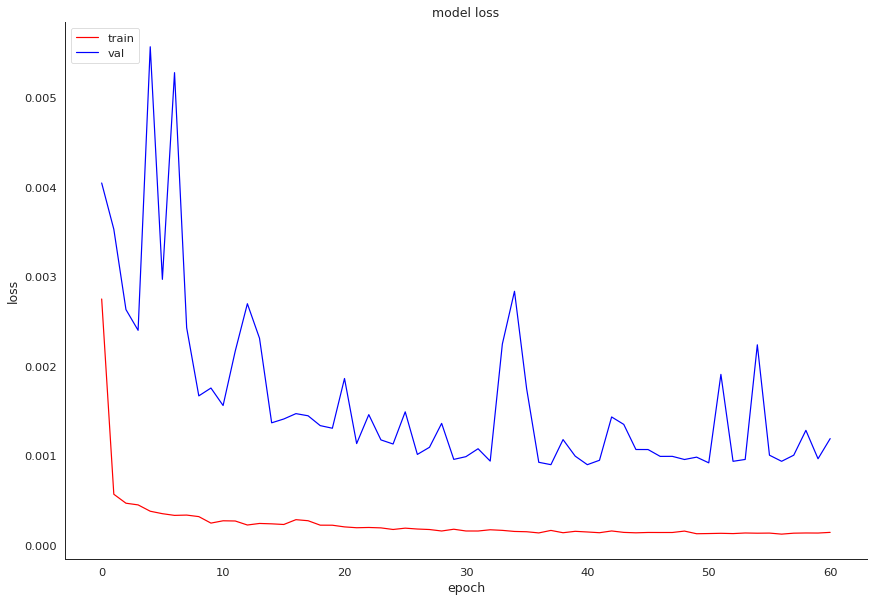

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history1TanH.history['loss'], 'r')
plt.plot(history1TanH.history['val_loss'], 'b')
plt.tight_layout()
sns.despine(top=True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

In [ ]:
saved_model_1TanH=load_model('best_model_1TanH.h5')
train_predict_1TanH=saved_model_1TanH.predict(X_train)
test_predict_1TanH=saved_model_1TanH.predict(X_test)

scale=MinMaxScaler() #create new MinMaxScaler and use the values of scaler for our bitcoin close price column
scale.min_,scale.scale_,scale.data_min_,scale.data_max_=scaler.min_[0],scaler.scale_[0],scaler.data_min_[0],scaler.data_max_[0]

train_predict_1TanH=scale.inverse_transform(train_predict_1TanH)

y_train=scale.inverse_transform([y_train])
test_predict_1TanH=scale.inverse_transform(test_predict_1TanH)
y_test=scale.inverse_transform([y_test])

print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train.transpose(), train_predict_1TanH[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_1TanH[:,0])))

Train Root Mean Squared Error: 887.3094645555319
Test Root Mean Squared Error: 1733.1608465162412


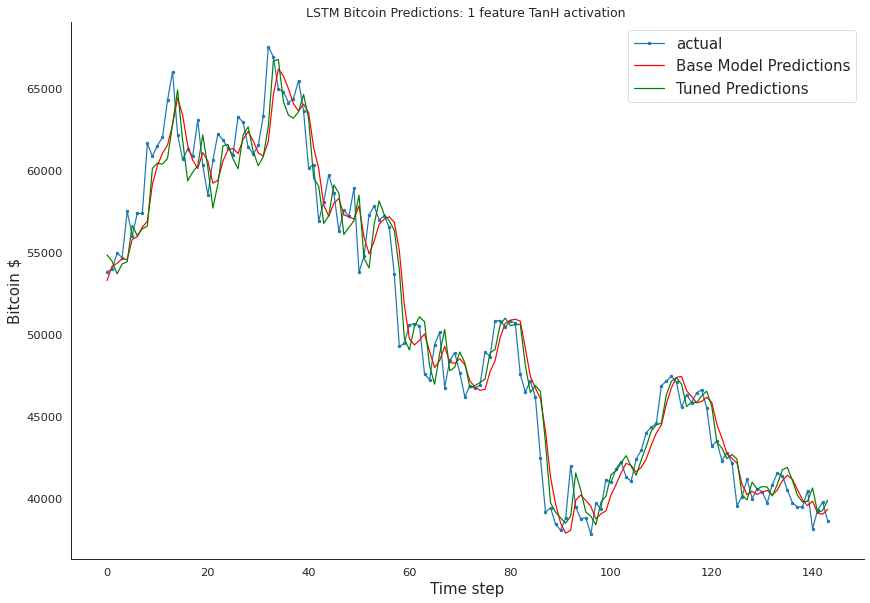

Tuned LSTM TanH 26 features: total return for 143 day period starting 2021-10-08 is $ -493.5766951740079

compared with

Base Model LSTM TanH 26 features: total return for 143 day period starting 2021-10-08 is $ -13560.511895495118

Test Root Mean Squared Error for: Tuned LSTM 1 feature TanH: 1733.1608465162412
Test Root Mean Squared Error for: Base LSTM 1 feature TanH: 1776.6675181139979


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict4[:,0][:144], 'r', label="Base Model Predictions")
plt.plot(aa, test_predict_1TanH[:,0][:144], 'g', label="Tuned Predictions")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 1 feature TanH activation ')
plt.ylabel('Bitcoin $', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

dollarprofits1TanH=[]
buyselldollar(y_testplot,test_predict_1TanH,dollarprofits1TanH)
dollarprofits1TanH=np.array(dollarprofits1TanH)

totalpercentageprofits1TanH=[]
totalbuysellpercentage(y_testplot,test_predict_1TanH,totalpercentageprofits1TanH)
totalpercentageprofits1TanH=np.array(totalpercentageprofits1TanH)

print('Tuned LSTM TanH 26 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits1TanH))
# print('this is a daily % profit / loss of', totalpercentageprofits1TanH)
print('\ncompared with')
print('\nBase Model LSTM TanH 26 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits4))
# print('with daily % profit / loss of', totalpercentageprofits4)

print('\nTest Root Mean Squared Error for: Tuned LSTM 1 feature TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_1TanH[:,0])))
print('Test Root Mean Squared Error for: Base LSTM 1 feature TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict4[:,0])))

**Case: Tuned LSTM 1 feature ReLU**

In [ ]:
dataset = df['BTC_Close'].values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train = scaler.fit_transform(train)
test = scaler.transform(test)
    
look_back = 30
X_train, y_train = create_dataset_onefeature(train, look_back)
X_test, y_test = create_dataset_onefeature(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min',verbose=0,patience=20) #20 epoch leeway
mc = ModelCheckpoint('best_model_1ReLU.h5', monitor='val_loss', mode='min', save_best_only=True)

def create_model(init_mode='glorot_uniform',learn_rate=0.01,decay=0.01,dropout_rate=0.0,weight_constraint=2,neurons=30):
  model=Sequential()
  
  model.add(LSTM(units=neurons,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
  model.add(Dropout(dropout_rate))
  model.add(Dense(units=1,kernel_initializer=init_mode))
  optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
  model.compile(loss='mse',optimizer=optimizer, metrics=['mse'])
  return model

model1ReLU=create_model()
history1ReLU=model1ReLU.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32, callbacks=[es,mc]) #we include more epochs than our tuning showed was optimal as we are utilising early stopping and model checkpoints

Epoch 1/100
44/44 [==============================] - 4s 23ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 2/100
44/44 [==============================] - 0s 7ms/step - loss: 3.7228e-04 - mse: 3.7228e-04 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 3/100
44/44 [==============================] - 0s 8ms/step - loss: 3.3930e-04 - mse: 3.3930e-04 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 4/100
44/44 [==============================] - 0s 7ms/step - loss: 2.6970e-04 - mse: 2.6970e-04 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 5/100
44/44 [==============================] - 0s 7ms/step - loss: 2.6180e-04 - mse: 2.6180e-04 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 6/100
44/44 [==============================] - 0s 7ms/step - loss: 2.6987e-04 - mse: 2.6987e-04 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 7/100
44/44 [==============================] - 0s 7ms/step - loss: 2.4753e-04 - mse: 2.4753e-04 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 8/100
44/44 [===============

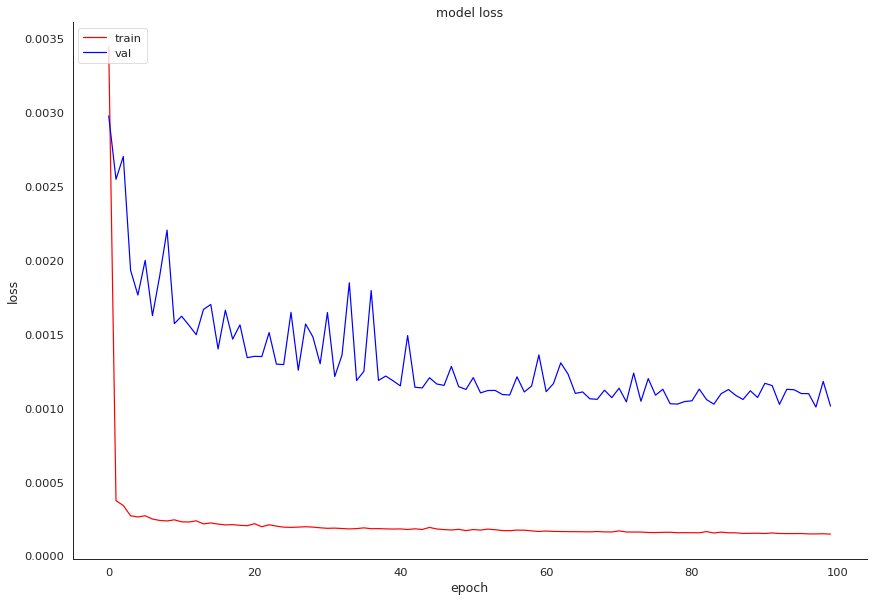

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history1ReLU.history['loss'], 'r')
plt.plot(history1ReLU.history['val_loss'], 'b')
plt.tight_layout()
sns.despine(top=True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

In [ ]:
saved_model_1ReLU=load_model('best_model_1ReLU.h5')
train_predict_1ReLU=saved_model_1ReLU.predict(X_train)
test_predict_1ReLU=saved_model_1ReLU.predict(X_test)

scale=MinMaxScaler() #create new MinMaxScaler and use the values of scaler for our bitcoin close price column
scale.min_,scale.scale_,scale.data_min_,scale.data_max_=scaler.min_[0],scaler.scale_[0],scaler.data_min_[0],scaler.data_max_[0]

train_predict_1ReLU=scale.inverse_transform(train_predict_1ReLU)

y_train=scale.inverse_transform([y_train])
test_predict_1ReLU=scale.inverse_transform(test_predict_1ReLU)
y_test=scale.inverse_transform([y_test])

print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train.transpose(), train_predict_1ReLU[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_1ReLU[:,0])))

Train Root Mean Squared Error: 941.9307293286635
Test Root Mean Squared Error: 1830.0265495050137


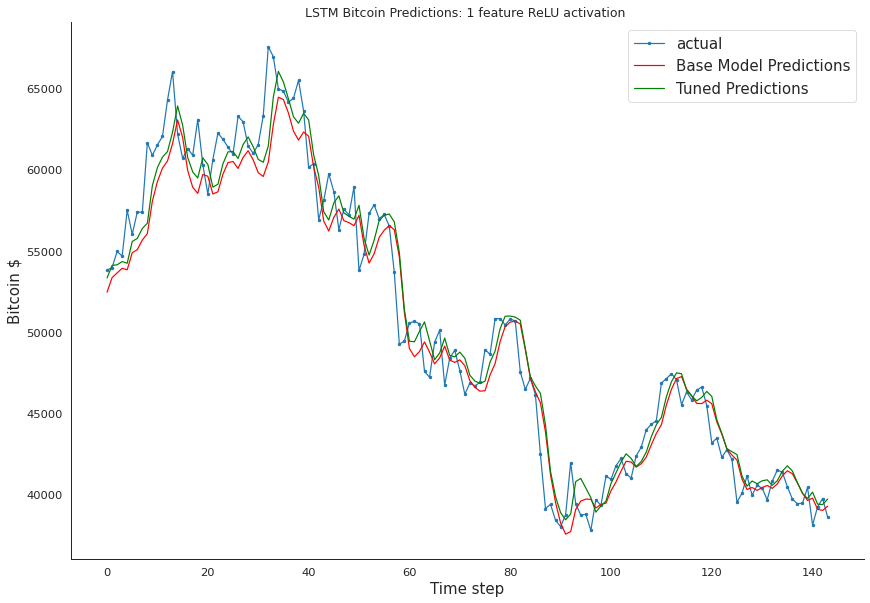

Tuned LSTM TanH 26 features: total return for 143 day period starting 2021-10-08 is $ -11915.607954998057
compared with
Base Model LSTM TanH 26 features: total return for 143 day period starting 2021-10-08 is $ -13701.31479928617
Test Root Mean Squared Error for: Tuned LSTM 1 feature ReLU: 1830.0265495050137
Test Root Mean Squared Error for: Base LSTM 1 feature ReLU: 1988.395335942453


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict1[:,0][:144], 'r', label="Base Model Predictions")
plt.plot(aa, test_predict_1ReLU[:,0][:144], 'g', label="Tuned Predictions")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 1 feature ReLU activation ')
plt.ylabel('Bitcoin $', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

dollarprofits1ReLU=[]
buyselldollar(y_testplot,test_predict_1ReLU,dollarprofits1ReLU)
dollarprofits1ReLU=np.array(dollarprofits1ReLU)

totalpercentageprofits1ReLU=[]
totalbuysellpercentage(y_testplot,test_predict_1ReLU,totalpercentageprofits1ReLU)
totalpercentageprofits1ReLU=np.array(totalpercentageprofits1ReLU)

print('Tuned LSTM TanH 1 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits1ReLU))
# print('this is a daily % profit / loss of', totalpercentageprofits1ReLU)
print('compared with')
print('Base Model LSTM TanH 1 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits1))
# print('with daily % profit / loss of', totalpercentageprofits1)

print('Test Root Mean Squared Error for: Tuned LSTM 1 feature ReLU:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_1ReLU[:,0])))
print('Test Root Mean Squared Error for: Base LSTM 1 feature ReLU:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict1[:,0])))

**Case: Tuned LSTM 26 Features TanH**

In [ ]:
dataset=dfvif.values
train_size = int(len(dataset) * 0.9) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.transform(test)
scaler.min_,scaler.scale_,scaler.data_min_,scaler.data_max_

look_back = 30
X_train, y_train = create_dataset(train, look_back)  
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 26))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 26))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min',verbose=0,patience=20) #20 epoch leeway
mc = ModelCheckpoint('best_model_26TanH.h5', monitor='val_loss', mode='min', save_best_only=True)

def create_model(init_mode='glorot_uniform',learn_rate=0.005,decay=0.01,dropout_rate=0.0,weight_constraint=2,neurons=40):
  model=Sequential()
  
  model.add(LSTM(units=neurons,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
  model.add(Dropout(dropout_rate))
  model.add(Dense(units=1,kernel_initializer=init_mode))
  optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
  model.compile(loss='mse',optimizer=optimizer, metrics=['mse'])
  return model

model26TanH=create_model()
history26TanH=model26TanH.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=8, callbacks=[es,mc]) #we include more epochs than our tuning showed was optimal as we are utilising early stopping and model checkpoints

Epoch 1/100
174/174 [==============================] - 4s 11ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 2/100
174/174 [==============================] - 1s 7ms/step - loss: 7.0959e-04 - mse: 7.0959e-04 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 3/100
174/174 [==============================] - 1s 6ms/step - loss: 5.7077e-04 - mse: 5.7077e-04 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 4/100
174/174 [==============================] - 1s 7ms/step - loss: 4.8650e-04 - mse: 4.8650e-04 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 5/100
174/174 [==============================] - 1s 6ms/step - loss: 4.2884e-04 - mse: 4.2884e-04 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 6/100
174/174 [==============================] - 1s 7ms/step - loss: 3.9191e-04 - mse: 3.9191e-04 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 7/100
174/174 [==============================] - 1s 8ms/step - loss: 3.5089e-04 - mse: 3.5089e-04 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 8/100
174/174 

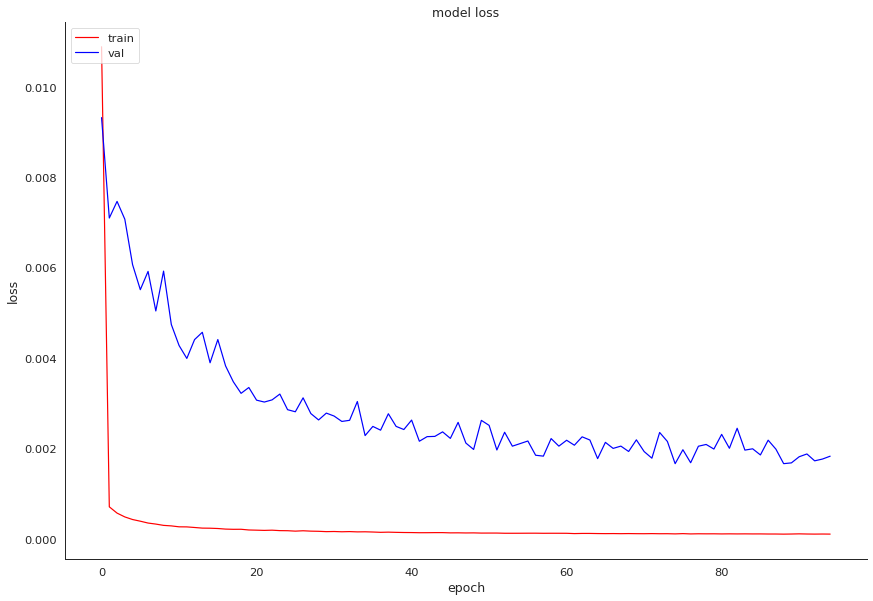

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history26TanH.history['loss'], 'r')
plt.plot(history26TanH.history['val_loss'], 'b')
plt.tight_layout()
sns.despine(top=True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

In [ ]:
saved_model_26TanH=load_model('best_model_26TanH.h5')
train_predict_26TanH=saved_model_26TanH.predict(X_train)
test_predict_26TanH=saved_model_26TanH.predict(X_test)

scale=MinMaxScaler() #create new MinMaxScaler and use the values of scaler for our bitcoin close price column
scale.min_,scale.scale_,scale.data_min_,scale.data_max_=scaler.min_[0],scaler.scale_[0],scaler.data_min_[0],scaler.data_max_[0]

train_predict_26TanH=scale.inverse_transform(train_predict_26TanH)

y_train=scale.inverse_transform([y_train])
test_predict_26TanH=scale.inverse_transform(test_predict_26TanH)
y_test=scale.inverse_transform([y_test])

print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train.transpose(), train_predict_26TanH[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_26TanH[:,0])))

Train Root Mean Squared Error: 1012.5386706392914
Test Root Mean Squared Error: 2172.5265699282522


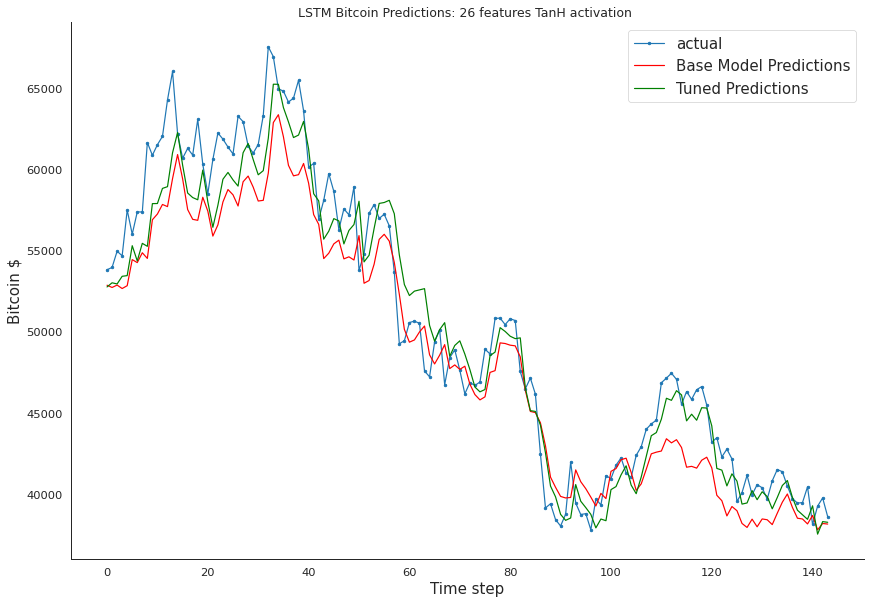

In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict6[:,0][:144], 'r', label="Base Model Predictions")
plt.plot(aa, test_predict_26TanH[:,0][:144], 'g', label="Tuned Predictions")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 26 features TanH activation ')
plt.ylabel('Bitcoin $', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
dollarprofits26TanH=[]
buyselldollar(y_testplot,test_predict_26TanH,dollarprofits26TanH)
dollarprofits26TanH=np.array(dollarprofits26TanH)

totalpercentageprofits26TanH=[]
totalbuysellpercentage(y_testplot,test_predict_26TanH,totalpercentageprofits26TanH)
totalpercentageprofits26TanH=np.array(totalpercentageprofits26TanH)

print('Tuned LSTM TanH 26 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits26TanH))
# print('this is a daily % profit / loss of', totalpercentageprofits26TanH)
print('compared with')
print('Base Model LSTM TanH 26 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits6))
# print('with daily % profit / loss of', totalpercentageprofits6)

Tuned LSTM TanH 26 features: total return for 143 day period starting 2021-10-08 is $ -3035.1795847835747
compared with
Base Model LSTM TanH 26 features: total return for 143 day period starting 2021-10-08 is $ -8774.970491542852


**Case: Tuned LSTM 26 features ReLU**

In [ ]:
dataset=dfvif.values
train_size = int(len(dataset) * 0.9) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.transform(test)
scaler.min_,scaler.scale_,scaler.data_min_,scaler.data_max_

look_back = 30
X_train, y_train = create_dataset(train, look_back)  
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 26))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 26))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min',verbose=0,patience=20) #20 epoch leeway
mc = ModelCheckpoint('best_model_26ReLU.h5', monitor='val_loss', mode='min', save_best_only=True)

def create_model(init_mode='glorot_uniform',activation='relu',learn_rate=0.001,decay=0.0,dropout_rate=0.0,weight_constraint=3,neurons=60):
  model=Sequential()
  
  model.add(LSTM(units=neurons,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
  model.add(Dropout(dropout_rate))
  model.add(Dense(units=1,kernel_initializer=init_mode))
  optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
  model.compile(loss='mse',optimizer=optimizer, metrics=['mse'])
  return model

model26ReLU=create_model()
history26ReLU=model26ReLU.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=8, callbacks=[es,mc])

Epoch 1/100
174/174 [==============================] - 5s 12ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 2/100
174/174 [==============================] - 1s 4ms/step - loss: 5.7359e-04 - mse: 5.7359e-04 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 3/100
174/174 [==============================] - 1s 5ms/step - loss: 4.5539e-04 - mse: 4.5539e-04 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 4/100
174/174 [==============================] - 1s 4ms/step - loss: 4.2777e-04 - mse: 4.2777e-04 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 5/100
174/174 [==============================] - 1s 5ms/step - loss: 3.2313e-04 - mse: 3.2313e-04 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 6/100
174/174 [==============================] - 1s 5ms/step - loss: 2.9771e-04 - mse: 2.9771e-04 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 7/100
174/174 [==============================] - 1s 5ms/step - loss: 3.0450e-04 - mse: 3.0450e-04 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 8/100
174/174 

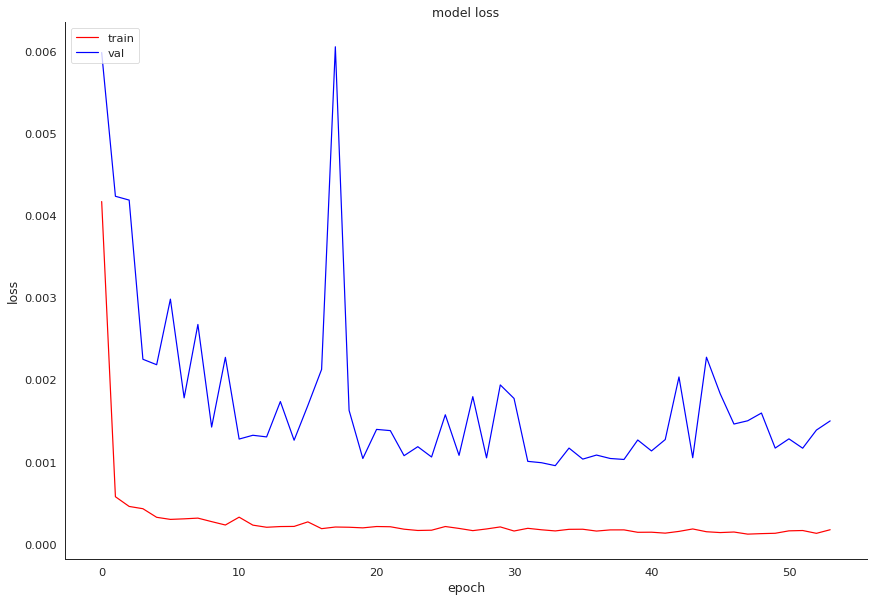

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history26ReLU.history['loss'], 'r')
plt.plot(history26ReLU.history['val_loss'], 'b')
plt.tight_layout()
sns.despine(top=True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

In [ ]:
saved_model_26ReLU=load_model('best_model_26ReLU.h5')
train_predict_26ReLU=saved_model_26ReLU.predict(X_train)
test_predict_26ReLU=saved_model_26ReLU.predict(X_test)

scale=MinMaxScaler() #create new MinMaxScaler and use the values of scaler for our bitcoin close price column
scale.min_,scale.scale_,scale.data_min_,scale.data_max_=scaler.min_[0],scaler.scale_[0],scaler.data_min_[0],scaler.data_max_[0]

train_predict_26ReLU=scale.inverse_transform(train_predict_26ReLU)
y_train=scale.inverse_transform([y_train])
test_predict_26ReLU=scale.inverse_transform(test_predict_26ReLU)
y_test=scale.inverse_transform([y_test])

print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train.transpose(), train_predict_26ReLU[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_26ReLU[:,0])))

Train Root Mean Squared Error: 993.0350047870827
Test Root Mean Squared Error: 2310.740869143989


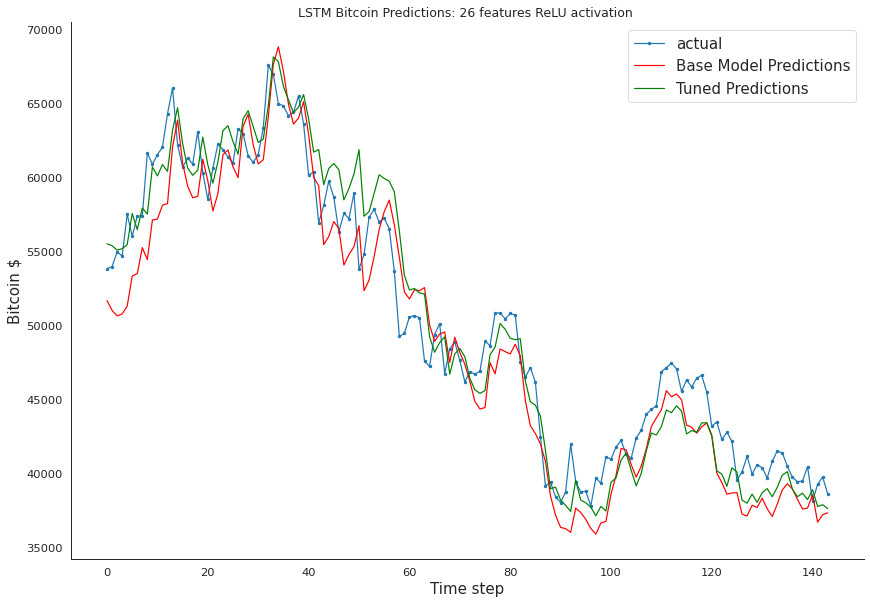

In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict3[:,0][:144], 'r', label="Base Model Predictions")
plt.plot(aa, test_predict_26ReLU[:,0][:144], 'g', label="Tuned Predictions")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 26 features ReLU activation ')
plt.ylabel('Bitcoin $', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
dollarprofits26ReLU=[]
buyselldollar(y_testplot,test_predict_26ReLU,dollarprofits26ReLU)
dollarprofits26ReLU=np.array(dollarprofits26ReLU)

totalpercentageprofits26ReLU=[]
totalbuysellpercentage(y_testplot,test_predict_26ReLU,totalpercentageprofits26ReLU)
totalpercentageprofits26ReLU=np.array(totalpercentageprofits26ReLU)

print('Tuned LSTM ReLU 26 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits26ReLU))
# print('this amounts to daily % profit / loss of', totalpercentageprofits26ReLU)
print('compared with')
print('Base Model LSTM ReLU 26 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits3))
# print('with daily % profit / loss of', totalpercentageprofits3)

Tuned LSTM ReLU 26 features: total return for 143 day period starting 2021-10-08 is $ -11104.676021800908
compared with
Base Model LSTM ReLU 26 features: total return for 143 day period starting 2021-10-08 is $ -4387.183779986153


**Case: Tuned LSTM 58 features TanH**

In [ ]:
dataset58feat = df.drop(['dtime'],axis=1)
dataset58feat = dataset58feat.values
dataset58feat = dataset58feat.astype('float32')
train_size = int(len(dataset58feat) * 0.9)
test_size = len(dataset58feat) - train_size
train, test = dataset58feat[0:train_size, :], dataset58feat[train_size:len(dataset58feat), :]

scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.transform(test)
scaler.min_,scaler.scale_,scaler.data_min_,scaler.data_max_

look_back = 30
X_train, y_train = create_dataset(train, look_back)  
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 58))
X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 58))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min',verbose=0,patience=20) #20 epoch leeway
mc = ModelCheckpoint('best_model_58TanH.h5', monitor='val_loss', mode='min', save_best_only=True)

def create_model(init_mode='lecun_uniform',learn_rate=0.001,decay=0.0,dropout_rate=0.0,weight_constraint=1,neurons=20):
  model=Sequential()
  
  model.add(LSTM(units=neurons,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
  model.add(Dropout(dropout_rate))
  model.add(Dense(units=1,kernel_initializer=init_mode))
  optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
  model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
  return model

model58TanH=create_model()
history58TanH=model58TanH.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=16, callbacks=[es,mc])

# model.summary()

Epoch 1/100
87/87 [==============================] - 3s 9ms/step - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 2/100
87/87 [==============================] - 0s 5ms/step - loss: 8.0089e-04 - mse: 8.0089e-04 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 3/100
87/87 [==============================] - 0s 4ms/step - loss: 4.9161e-04 - mse: 4.9161e-04 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 4/100
87/87 [==============================] - 0s 5ms/step - loss: 3.4451e-04 - mse: 3.4451e-04 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 5/100
87/87 [==============================] - 0s 5ms/step - loss: 2.6347e-04 - mse: 2.6347e-04 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 6/100
87/87 [==============================] - 0s 4ms/step - loss: 2.1946e-04 - mse: 2.1946e-04 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 7/100
87/87 [==============================] - 0s 5ms/step - loss: 1.5782e-04 - mse: 1.5782e-04 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 8/100
87/87 [================

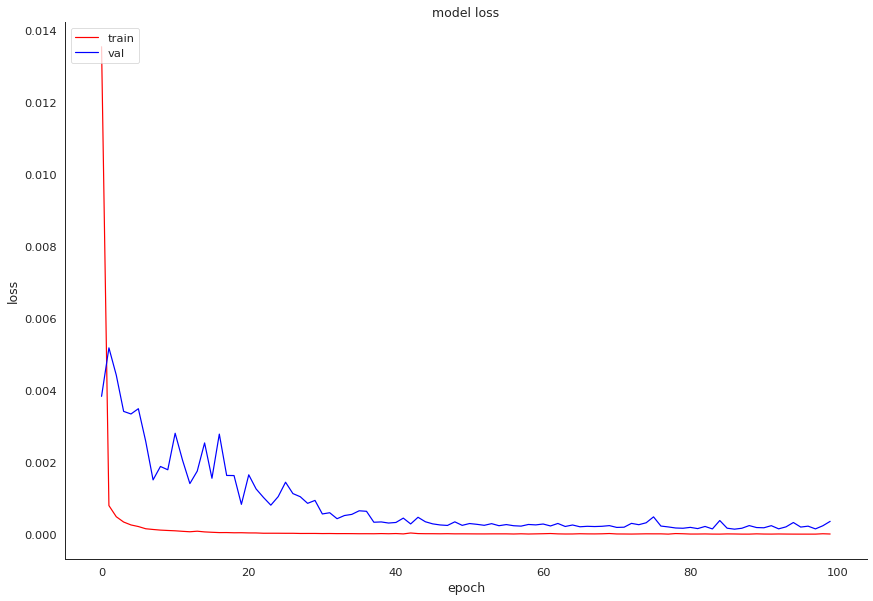

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history58TanH.history['loss'], 'r')
plt.plot(history58TanH.history['val_loss'], 'b')
plt.tight_layout()
sns.despine(top=True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

In [ ]:
saved_model_58TanH=load_model('best_model_58TanH.h5')
train_predict_58TanH=saved_model_58TanH.predict(X_train)
test_predict_58TanH=saved_model_58TanH.predict(X_test)

scale=MinMaxScaler() #create new MinMaxScaler and use the values of scaler for our bitcoin close price column
scale.min_,scale.scale_,scale.data_min_,scale.data_max_=scaler.min_[0],scaler.scale_[0],scaler.data_min_[0],scaler.data_max_[0]

train_predict_58TanH=scale.inverse_transform(train_predict_58TanH)
y_train=scale.inverse_transform([y_train])
test_predict_58TanH=scale.inverse_transform(test_predict_58TanH)
y_test=scale.inverse_transform([y_test])

print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train.transpose(), train_predict_58TanH[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_58TanH[:,0])))

Train Mean Absolute Error: 163.22733749743554
Train Root Mean Squared Error: 278.107742288906
Test Mean Absolute Error: 3124.5566450498322
Test Root Mean Squared Error: 3228.256487007454


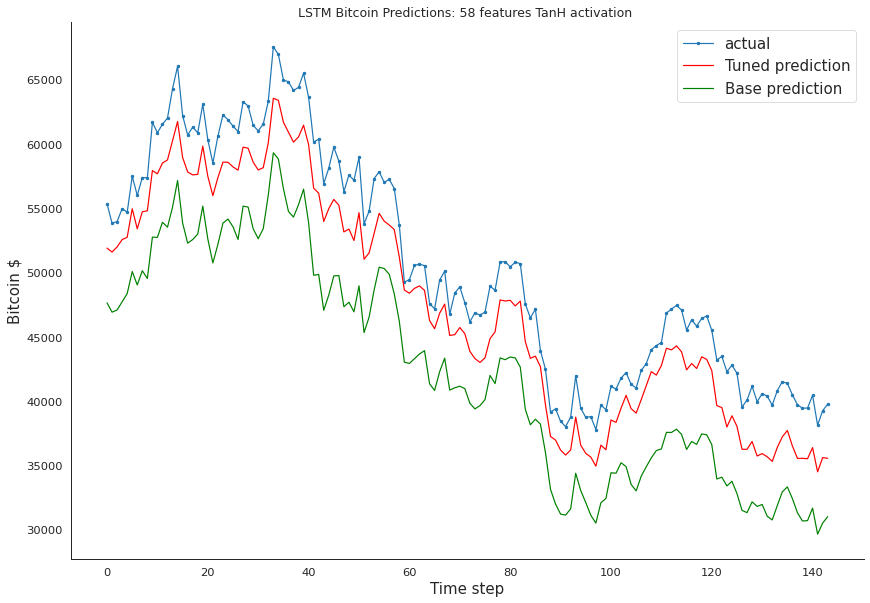

In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_58TanH[:,0][:144], 'r', label="Tuned prediction")
plt.plot(aa, test_predict5[:,0][:144], 'g', label="Base prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 58 features TanH activation ')
plt.ylabel('Bitcoin $', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
dollarprofits58TanH=[]
buyselldollar(y_testplot,test_predict_58TanH,dollarprofits58TanH)
dollarprofits58TanH=np.array(dollarprofits58TanH)

totalpercentageprofits58TanH=[]
totalbuysellpercentage(y_testplot,test_predict_58TanH,totalpercentageprofits58TanH)
totalpercentageprofits58TanH=np.array(totalpercentageprofits58TanH)

print('Tuned LSTM TanH 58 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits58TanH))
# print('this is a daily % profit / loss of', sum(totalpercentageprofits58TanH), '%')
print('compared with')
print('Base LSTM TanH 58 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits5))
# print('with daily % profit / loss of', sum(totalpercentageprofits5), '%')

Tuned LSTM TanH 58 features: total return for 143 day period starting 2021-10-08 is $ 4551.210578480612
compared with
Base LSTM TanH 58 features: total return for 143 day period starting 2021-10-08 is $ -8892.464943154082


**Case: Tuned LSTM 58 features ReLU**

In [ ]:
dataset58feat = df.drop(['dtime'],axis=1)
dataset58feat = dataset58feat.values
dataset58feat = dataset58feat.astype('float32')
train_size = int(len(dataset58feat) * 0.9)
test_size = len(dataset58feat) - train_size
train, test = dataset58feat[0:train_size, :], dataset58feat[train_size:len(dataset58feat), :]

scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.transform(test)
scaler.min_,scaler.scale_,scaler.data_min_,scaler.data_max_

look_back = 30
X_train, y_train = create_dataset(train, look_back)  
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 58))
X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 58))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=20) #20 epoch leeway
mc = ModelCheckpoint('best_model_58ReLU.h5', monitor='val_loss', mode='min', save_best_only=True)

def create_model(init_mode='normal',activation='relu',learn_rate=0.005,decay=0.0,dropout_rate=0.0,weight_constraint=1,neurons=20):
  model=Sequential()
  
  model.add(GRU(units=neurons,kernel_constraint=maxnorm(weight_constraint),input_shape=(X_train.shape[1],X_train.shape[2])))
  model.add(Dropout(dropout_rate))
  model.add(Dense(units=1,kernel_initializer=init_mode))
  optimizer=tf.keras.optimizers.Adam(lr=learn_rate,decay=decay)
  model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
  return model


model58ReLU=create_model()
history58ReLU=model58ReLU.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=16, callbacks=[es,mc])

# model.summary()

Epoch 1/100
87/87 [==============================] - 2s 9ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 2/100
87/87 [==============================] - 0s 5ms/step - loss: 1.1425e-04 - mse: 1.1425e-04 - val_loss: 7.5550e-04 - val_mse: 7.5550e-04
Epoch 3/100
87/87 [==============================] - 0s 5ms/step - loss: 7.2581e-05 - mse: 7.2581e-05 - val_loss: 3.4850e-04 - val_mse: 3.4850e-04
Epoch 4/100
87/87 [==============================] - 0s 5ms/step - loss: 3.9314e-05 - mse: 3.9314e-05 - val_loss: 1.8441e-04 - val_mse: 1.8441e-04
Epoch 5/100
87/87 [==============================] - 0s 4ms/step - loss: 3.8870e-05 - mse: 3.8870e-05 - val_loss: 3.6880e-04 - val_mse: 3.6880e-04
Epoch 6/100
87/87 [==============================] - 0s 4ms/step - loss: 4.9745e-05 - mse: 4.9745e-05 - val_loss: 2.3223e-04 - val_mse: 2.3223e-04
Epoch 7/100
87/87 [==============================] - 0s 5ms/step - loss: 5.0196e-05 - mse: 5.0196e-05 - val_loss: 1.1554e-04 - val_mse

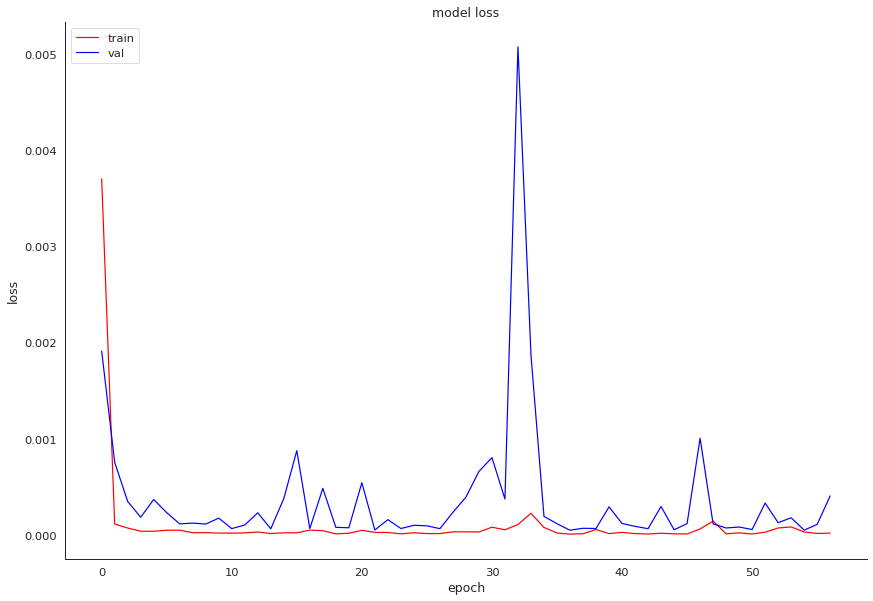

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history58ReLU.history['loss'], 'r')
plt.plot(history58ReLU.history['val_loss'], 'b')
plt.tight_layout()
sns.despine(top=True)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

In [ ]:
saved_model_58ReLU=load_model('best_model_58ReLU.h5')
train_predict_58ReLU=saved_model_58ReLU.predict(X_train)
test_predict_58ReLU=saved_model_58ReLU.predict(X_test)

scale=MinMaxScaler() #create new MinMaxScaler and use the values of scaler for our bitcoin close price column
scale.min_,scale.scale_,scale.data_min_,scale.data_max_=scaler.min_[0],scaler.scale_[0],scaler.data_min_[0],scaler.data_max_[0]

train_predict_58ReLU=scale.inverse_transform(train_predict_58ReLU)
y_train=scale.inverse_transform([y_train])
test_predict_58ReLU=scale.inverse_transform(test_predict_58ReLU)
y_test=scale.inverse_transform([y_test])

print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train.transpose(), train_predict_58ReLU[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_58ReLU[:,0])))

Train Root Mean Squared Error: 230.11487425170182
Test Root Mean Squared Error: 1797.8071671541484


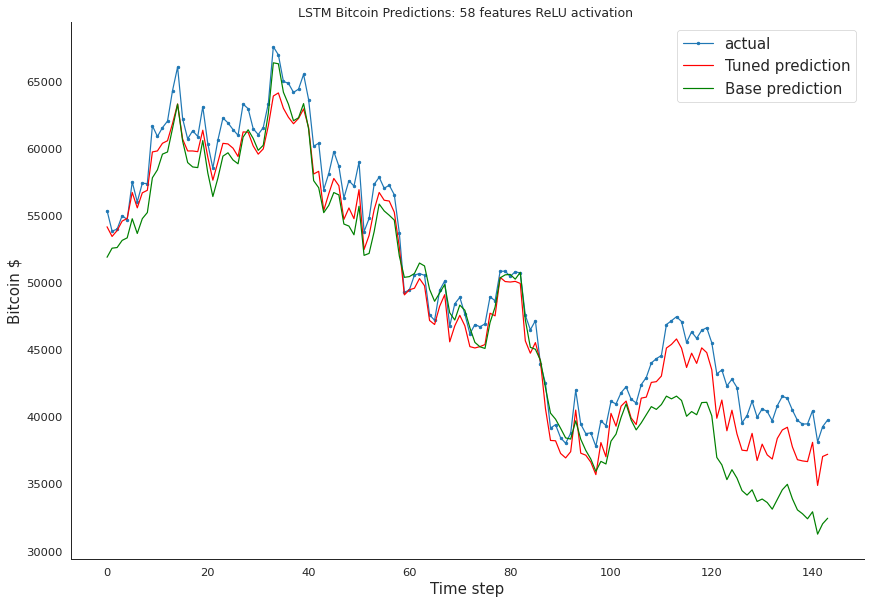

In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_58ReLU[:,0][:144], 'r', label="Tuned prediction")
plt.plot(aa, test_predict2[:,0][:144], 'g', label="Base prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 58 features ReLU activation ')
plt.ylabel('Bitcoin $', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
dollarprofits58ReLU=[]
buyselldollar(y_testplot,test_predict_58ReLU,dollarprofits58ReLU)
dollarprofits58ReLU=np.array(dollarprofits58ReLU)

totalpercentageprofits58ReLU=[]
totalbuysellpercentage(y_testplot,test_predict_58ReLU,totalpercentageprofits58ReLU)
totalpercentageprofits58ReLU=np.array(totalpercentageprofits58ReLU)

print('Tuned LSTM ReLU 58 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits58ReLU))
# print('this amounts to daily % profit / loss of', sum(totalpercentageprofits58ReLU), '%')
print('compared with')
print('Base LSTM ReLU 58 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits2))
# print('with daily % profit / loss of', sum(totalpercentageprofits2), '%')

Tuned LSTM ReLU 58 features: total return for 143 day period starting 2021-10-08 is $ -2455.1851487674794
compared with
Base LSTM ReLU 58 features: total return for 143 day period starting 2021-10-08 is $ -3963.885376905193


In [ ]:
print('Test Root Mean Squared Error for 1 feature ReLU:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_58ReLU[:,0])))
print('Test Root Mean Squared Error for 1 feature TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict2[:,0])))

d_t_list13 = cul_d_t(MSE, y_teststat, test_predict_58ReLU, test_predict2)
#print(d_t_list5)
print('\n the value of our DM test statistic is', cul_DM(d_t_list13))
print(' our p value for our DM test is', cul_P(d_t_list13))
if abs(cul_DM(d_t_list13)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

Test Root Mean Squared Error for 1 feature ReLU: 1797.8071671541484
Test Root Mean Squared Error for 1 feature TanH: 3549.8430038782058

 the value of our DM test statistic is [-7.6490748]
 our p value for our DM test is [2.02430474e-14]

 Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different


**Tuned Model Hypothesis Testing: DM Statistical Test**

Again, 1 feature TanH model was the best on unseen test data, although 58 ReLU closely trailed, and had far better train RMSE, suggesting this model overfit to training data and may have achieved better on test data with further tuning. Nevertheless, 1 feature TanH has hypothesis testing applied.

**Test 1:** Tuned model 1 feature TanH vs. 1 feature ReLU

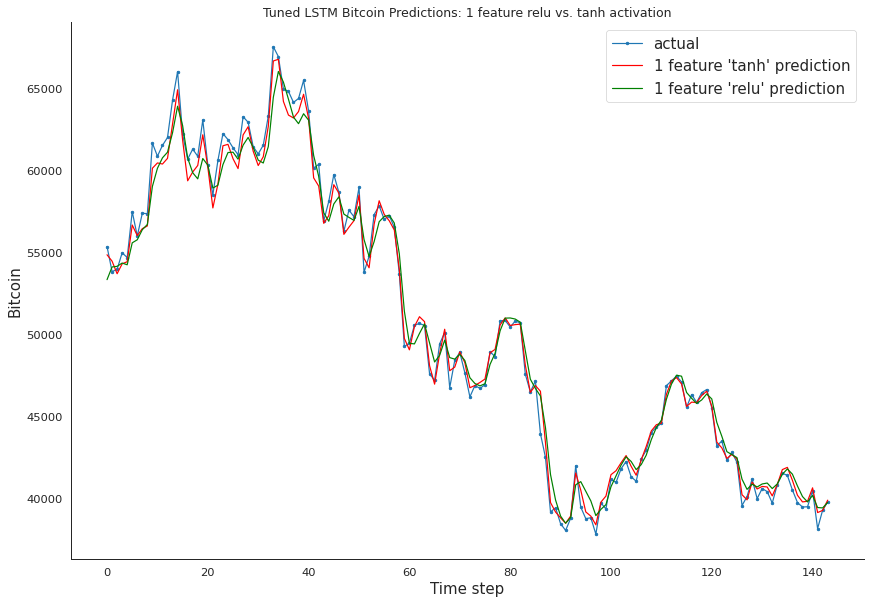

Test Root Mean Squared Error for Tuned 1 feature TanH: 631.6590471375339
Test Root Mean Squared Error for Tuned 1 feature ReLU: 1020.946055038276

Tuned LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $ -493.5766951740079
Tuned LSTM ReLU 1 feature: total return for 143 day period starting 2021-10-08 is $ -11915.607954998057

 the value of our DM test statistic is [-1.72412567]
 our p value for our DM test is [0.08468516]

 Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_1TanH[:,0][:144], 'r', label="1 feature 'tanh' prediction")
plt.plot(aa, test_predict_1ReLU[:,0][:144], 'g', label="1 feature 'relu' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Tuned LSTM Bitcoin Predictions: 1 feature relu vs. tanh activation')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for Tuned 1 feature TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_1TanH[:,0])))
print('Test Root Mean Squared Error for Tuned 1 feature ReLU:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_1ReLU[:,0])))

print('\nTuned LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits1TanH))
print('Tuned LSTM ReLU 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits1ReLU))

d_t_list8 = cul_d_t(MSE, y_teststat, test_predict_1TanH, test_predict_1ReLU)

print('\n the value of our DM test statistic is', cul_DM(d_t_list8))
print(' our p value for our DM test is', cul_P(d_t_list8))
if abs(cul_DM(d_t_list8)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Test 2:** Tuned model 1 feature TanH vs. 26 features TanH

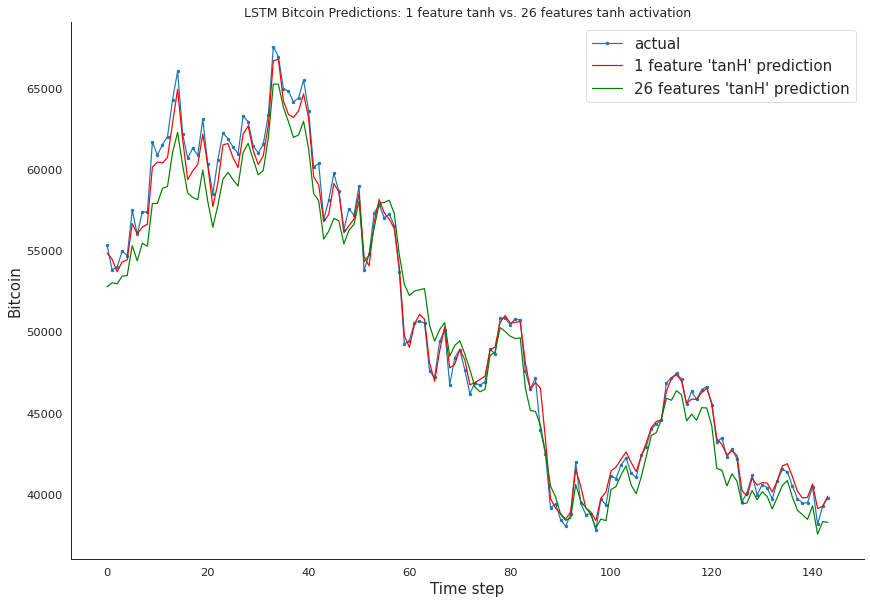

Test Root Mean Squared Error for 1 Feature TanH: 631.6590471375339
Test Root Mean Squared Error for 26 Features TanH: 1592.5530280081302

Tuned LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $ -493.5766951740079
Tuned LSTM ReLU 1 feature: total return for 143 day period starting 2021-10-08 is $ -3035.1795847835747

 the value of our DM test statistic is [-4.46808154]
 our p value for our DM test is [7.89242228e-06]

 Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_1TanH[:,0][:144], 'r', label="1 feature 'tanH' prediction")
plt.plot(aa, test_predict_26TanH[:,0][:144], 'g', label="26 features 'tanH' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 1 feature tanh vs. 26 features tanh activation')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for 1 Feature TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_1TanH[:,0])))
print('Test Root Mean Squared Error for 26 Features TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_26TanH[:,0])))

print('\nTuned LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits1TanH))
print('Tuned LSTM ReLU 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits26TanH))

d_t_list9 = cul_d_t(MSE, y_teststat, test_predict_1TanH, test_predict_26TanH)
#print(d_t_list5)
print('\n the value of our DM test statistic is', cul_DM(d_t_list9))
print(' our p value for our DM test is', cul_P(d_t_list9))
if abs(cul_DM(d_t_list9)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Test 3:** Tuned model 1 feature TanH vs. 58 features TanH

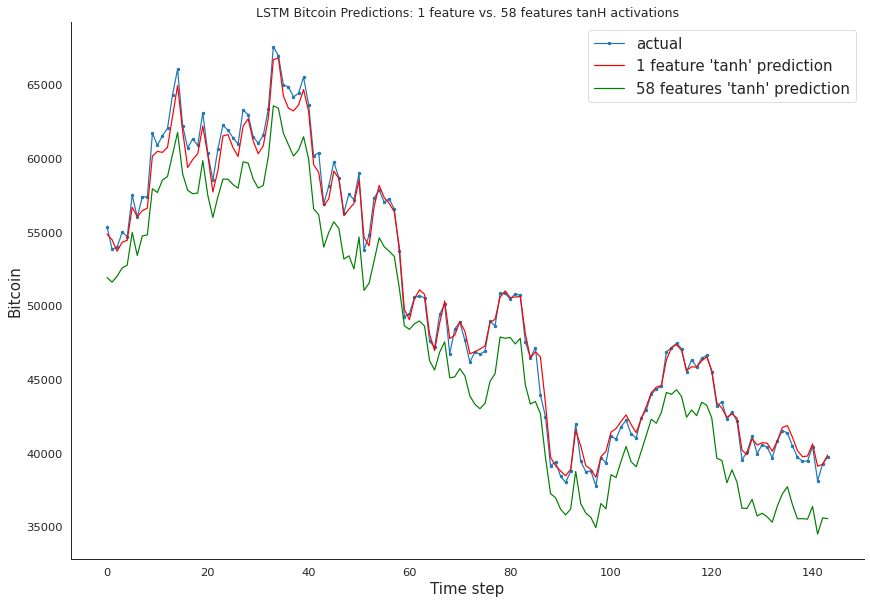

Test Root Mean Squared Error for: Tuned LSTM 1 feature TanH: 631.6590471375339
Test Root Mean Squared Error for: Tuned LSTM 58 features TanH: 3228.256487007454

Tuned LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $ -493.5766951740079
Tuned LSTM TanH 58 features: total return for 143 day period starting 2021-10-08 is $ 4551.210578480612

 the value of our DM test statistic is [-10.6029162]
 our p value for our DM test is [2.88830707e-26]

 Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_1TanH[:,0][:144], 'r', label="1 feature 'tanh' prediction")
plt.plot(aa, test_predict_58TanH[:,0][:144], 'g', label="58 features 'tanh' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 1 feature vs. 58 features tanH activations')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for: Tuned LSTM 1 feature TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_1TanH[:,0])))
print('Test Root Mean Squared Error for: Tuned LSTM 58 features TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_58TanH[:,0])))

print('\nTuned LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits1TanH))
print('Tuned LSTM TanH 58 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits58TanH))

d_t_list10 = cul_d_t(MSE, y_teststat, test_predict_1TanH, test_predict_58TanH)
#print(d_t_list5)
print('\n the value of our DM test statistic is', cul_DM(d_t_list10))
print(' our p value for our DM test is', cul_P(d_t_list10))
if abs(cul_DM(d_t_list10)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Test 4:** Tuned model 1 feature tanh vs. 26 features relu

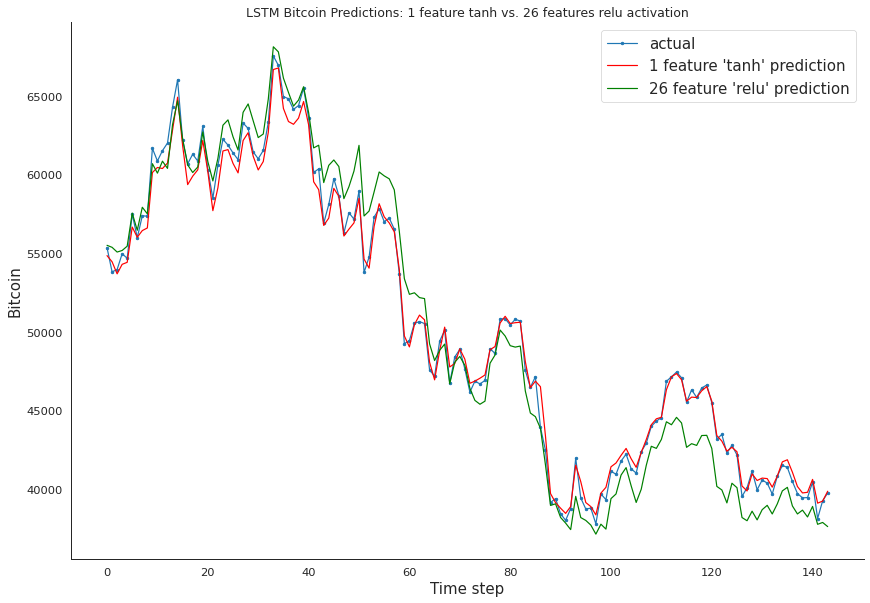

Test Root Mean Squared Error for 1 Feature TanH: 631.6590471375339
Test Root Mean Squared Error for 26 Features ReLU: 1725.1555315046974

Tuned LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $ -493.5766951740079
Tuned LSTM ReLU 26 features: total return for 143 day period starting 2021-10-08 is $ -11104.676021800908

 the value of our DM test statistic is [-3.95612066]
 our p value for our DM test is [7.61766969e-05]

 Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_1TanH[:,0][:144], 'r', label="1 feature 'tanh' prediction")
plt.plot(aa, test_predict_26ReLU[:,0][:144], 'g', label="26 feature 'relu' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 1 feature tanh vs. 26 features relu activation')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for 1 Feature TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_1TanH[:,0])))
print('Test Root Mean Squared Error for 26 Features ReLU:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_26ReLU[:,0])))

print('\nTuned LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits1TanH))
print('Tuned LSTM ReLU 26 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits26ReLU))

d_t_list11 = cul_d_t(MSE, y_teststat, test_predict_1TanH, test_predict_26ReLU)
#print(d_t_list5)
print('\n the value of our DM test statistic is', cul_DM(d_t_list11))
print(' our p value for our DM test is', cul_P(d_t_list11))
if abs(cul_DM(d_t_list11)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Test 5:** Tuned model 1 feature tanh vs. 58 features relu

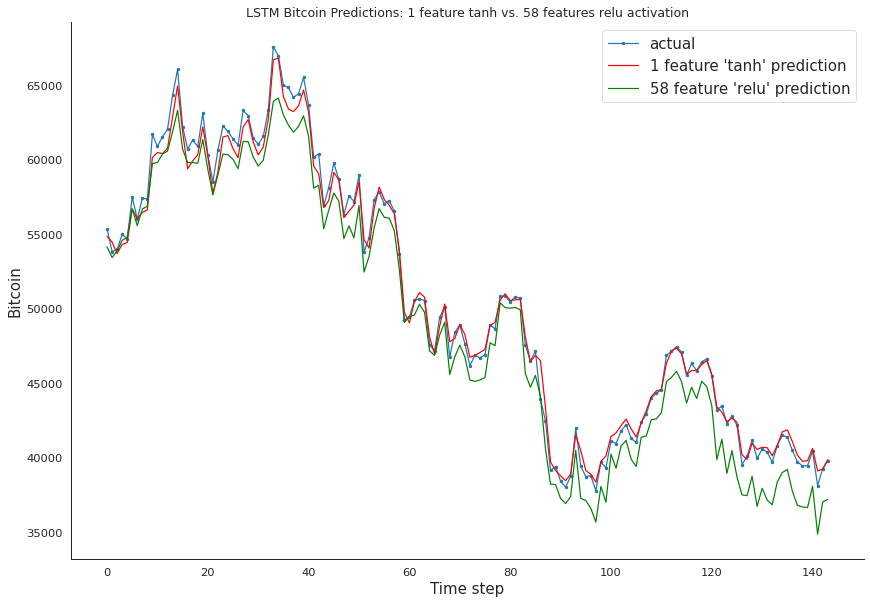

Test Root Mean Squared Error for 1 feature TanH: 631.6590471375339
Test Root Mean Squared Error for 58 feature ReLU: 1797.8071671541484

Tuned LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $ -493.5766951740079
Tuned LSTM ReLU 58 features: total return for 143 day period starting 2021-10-08 is $ -2455.1851487674794

 the value of our DM test statistic is [-4.5193411]
 our p value for our DM test is [6.20323853e-06]

 Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_1TanH[:,0][:144], 'r', label="1 feature 'tanh' prediction")
plt.plot(aa, test_predict_58ReLU[:,0][:144], 'g', label="58 feature 'relu' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 1 feature tanh vs. 58 features relu activation')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for 1 feature TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_1TanH[:,0])))
print('Test Root Mean Squared Error for 58 feature ReLU:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_58ReLU[:,0])))

print('\nTuned LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits1TanH))
print('Tuned LSTM ReLU 58 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits58ReLU))

d_t_list12 = cul_d_t(MSE, y_teststat, test_predict_1TanH, test_predict_58ReLU)
#print(d_t_list5)
print('\n the value of our DM test statistic is', cul_DM(d_t_list12))
print(' our p value for our DM test is', cul_P(d_t_list12))
if abs(cul_DM(d_t_list12)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Test 6:** Tuned model 26 features tanh vs. 26 features relu

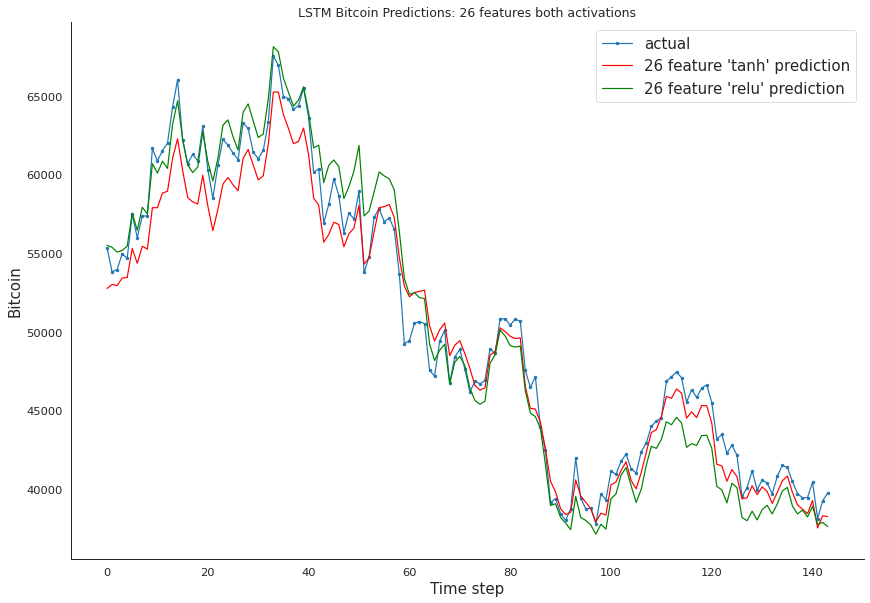

Test Root Mean Squared Error for 26 Features ReLU: 1592.5530280081302
Test Root Mean Squared Error for 26 Features TanH: 1725.1555315046974

Tuned LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $ -3035.1795847835747
Tuned LSTM ReLU 1 feature: total return for 143 day period starting 2021-10-08 is $ -11104.676021800908

 the value of our DM test statistic is [-0.90636125]
 our p value for our DM test is [0.36474468]

 Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_26TanH[:,0][:144], 'r', label="26 feature 'tanh' prediction")
plt.plot(aa, test_predict_26ReLU[:,0][:144], 'g', label="26 feature 'relu' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 26 features both activations')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for 26 Features ReLU:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_26TanH[:,0])))
print('Test Root Mean Squared Error for 26 Features TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_26ReLU[:,0])))

print('\nTuned LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits26TanH))
print('Tuned LSTM ReLU 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits26ReLU))

d_t_list13 = cul_d_t(MSE, y_teststat, test_predict_26TanH, test_predict_26ReLU)
#print(d_t_list13)
print('\n the value of our DM test statistic is', cul_DM(d_t_list13))
print(' our p value for our DM test is', cul_P(d_t_list13))
if abs(cul_DM(d_t_list13)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Test 7:** Tuned model 58 features Tanh vs. 58 features ReLU

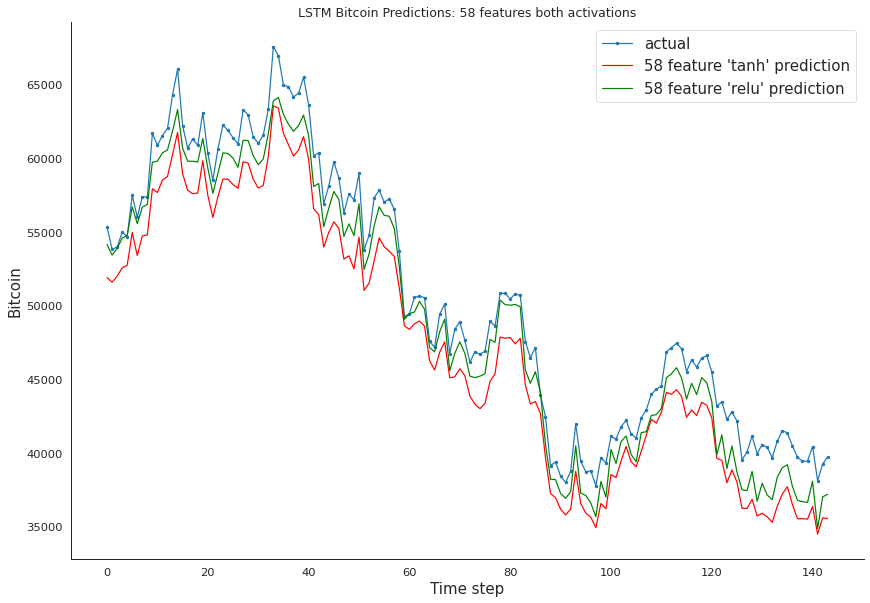

Test Root Mean Squared Error for 58 Features TanH: 3228.256487007454
Test Root Mean Squared Error for 58 Features ReLU: 1797.8071671541484

Tuned LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $ 4551.210578480612
Tuned LSTM ReLU 1 feature: total return for 143 day period starting 2021-10-08 is $ -2455.1851487674794

 the value of our DM test statistic is [13.93744403]
 our p value for our DM test is [3.75135613e-44]

 Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_58TanH[:,0][:144], 'r', label="58 feature 'tanh' prediction")
plt.plot(aa, test_predict_58ReLU[:,0][:144], 'g', label="58 feature 'relu' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 58 features both activations')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for 58 Features TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_58TanH[:,0])))
print('Test Root Mean Squared Error for 58 Features ReLU:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_58ReLU[:,0])))

print('\nTuned LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits58TanH))
print('Tuned LSTM ReLU 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits58ReLU))

d_t_list14 = cul_d_t(MSE, y_teststat, test_predict_58TanH, test_predict_58ReLU)
#print(d_t_list14)
print('\n the value of our DM test statistic is', cul_DM(d_t_list14))
print(' our p value for our DM test is', cul_P(d_t_list14))
if abs(cul_DM(d_t_list14)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Hypothesis testing for base model vs tuned model predictions**

**Case 1: 1 feature tanh, tuned vs. base**

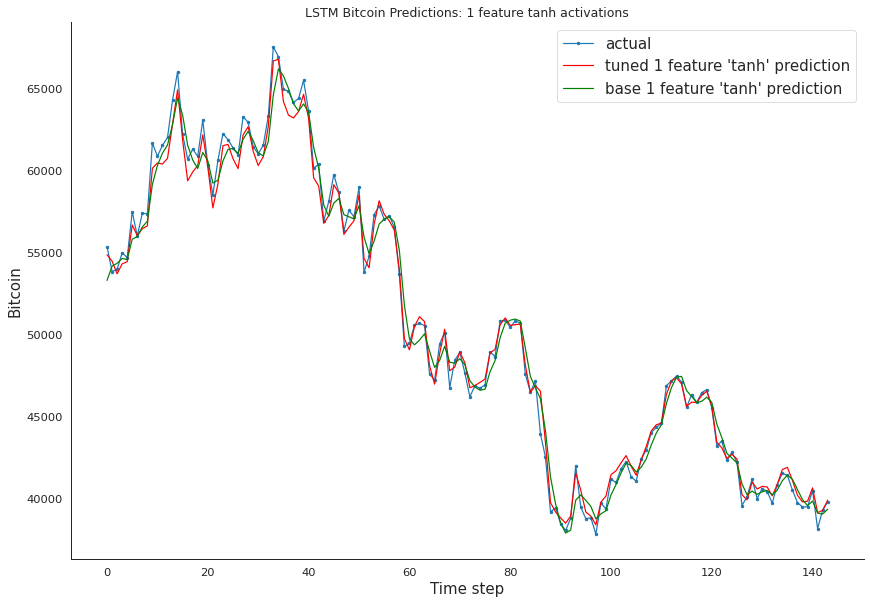

Test Root Mean Squared Error for Tuned 1 Feature TanH: 631.6590471375339
Test Root Mean Squared Error for Base 1 Feature TanH: 944.9296707606942

Tuned LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $ -493.5766951740079
Base LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $ -13560.511895495118

 the value of our DM test statistic is [-0.72480211]
 our p value for our DM test is [0.46857344]

 Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_1TanH[:,0][:144], 'r', label="tuned 1 feature 'tanh' prediction")
plt.plot(aa, test_predict4[:,0][:144], 'g', label="base 1 feature 'tanh' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 1 feature tanh activations')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for Tuned 1 Feature TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_1TanH[:,0])))
print('Test Root Mean Squared Error for Base 1 Feature TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict4[:,0])))

print('\nTuned LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits1TanH))
print('Base LSTM TanH 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits4))

d_t_list15 = cul_d_t(MSE, y_teststat, test_predict_1TanH, test_predict4)
#print(d_t_list15)
print('\n the value of our DM test statistic is', cul_DM(d_t_list15))
print(' our p value for our DM test is', cul_P(d_t_list15))
if abs(cul_DM(d_t_list15)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Case 2: 1 feature relu, tuned vs. base**

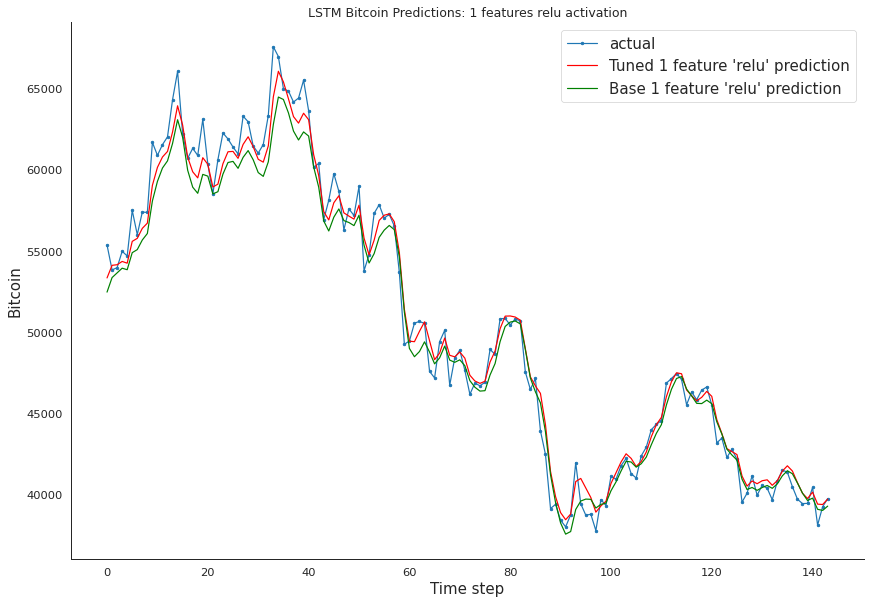

Test Root Mean Squared Error for 58 Features TanH: 1020.946055038276
Test Root Mean Squared Error for 58 Features ReLU: 1386.9834597799718

Tuned LSTM ReLU 1 feature: total return for 143 day period starting 2021-10-08 is $ -11915.607954998057
Base LSTM ReLU 1 feature: total return for 143 day period starting 2021-10-08 is $ -13701.31479928617

 the value of our DM test statistic is [2.44450166]
 our p value for our DM test is [0.01450524]

 Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_1ReLU[:,0][:144], 'r', label="Tuned 1 feature 'relu' prediction")
plt.plot(aa, test_predict1[:,0][:144], 'g', label="Base 1 feature 'relu' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 1 features relu activation')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for 58 Features TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_1ReLU[:,0])))
print('Test Root Mean Squared Error for 58 Features ReLU:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict1[:,0])))

print('\nTuned LSTM ReLU 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits1ReLU))
print('Base LSTM ReLU 1 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits1))

d_t_list16 = cul_d_t(MSE, y_teststat, test_predict_58ReLU, test_predict1)
#print(d_t_list14)
print('\n the value of our DM test statistic is', cul_DM(d_t_list16))
print(' our p value for our DM test is', cul_P(d_t_list16))
if abs(cul_DM(d_t_list16)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Case 3: 26 features TanH, tuned vs. base**

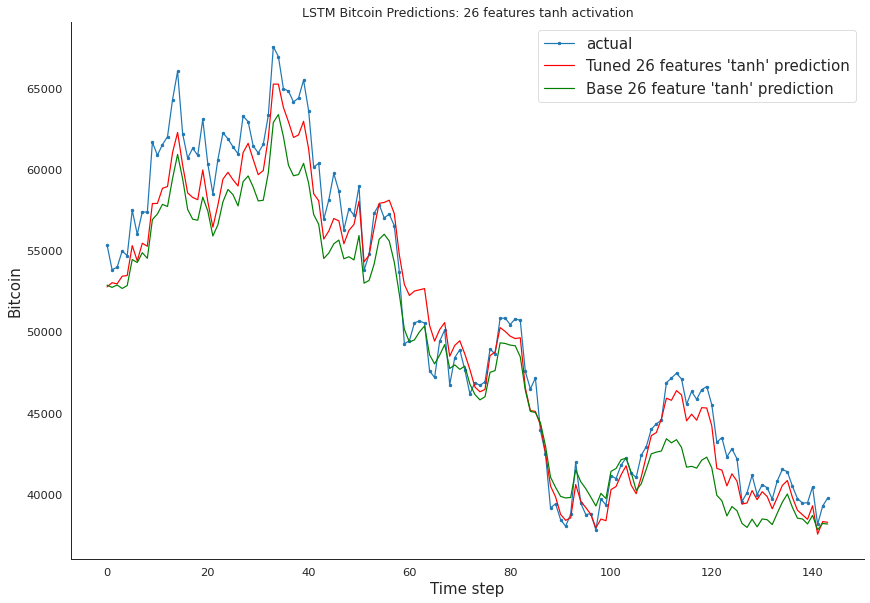

Test Root Mean Squared Error for Tuned 26 Features TanH: 1592.5530280081302
Test Root Mean Squared Error for Base 26 Features TanH: 2652.3249156859897

Tuned LSTM TanH 26 feature: total return for 143 day period starting 2021-10-08 is $ -3035.1795847835747
Base LSTM TanH 26 feature: total return for 143 day period starting 2021-10-08 is $ -8774.970491542852

 the value of our DM test statistic is [-6.29301975]
 our p value for our DM test is [3.11348715e-10]

 Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_26TanH[:,0][:144], 'r', label="Tuned 26 features 'tanh' prediction")
plt.plot(aa, test_predict6[:,0][:144], 'g', label="Base 26 feature 'tanh' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 26 features tanh activation')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for Tuned 26 Features TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_26TanH[:,0])))
print('Test Root Mean Squared Error for Base 26 Features TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict6[:,0])))

print('\nTuned LSTM TanH 26 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits26TanH))
print('Base LSTM TanH 26 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits6))

d_t_list17 = cul_d_t(MSE, y_teststat, test_predict_26TanH, test_predict6)
#print(d_t_list17)
print('\n the value of our DM test statistic is', cul_DM(d_t_list17))
print(' our p value for our DM test is', cul_P(d_t_list17))
if abs(cul_DM(d_t_list17)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Case 4: 26 features ReLU, tuned vs. base**

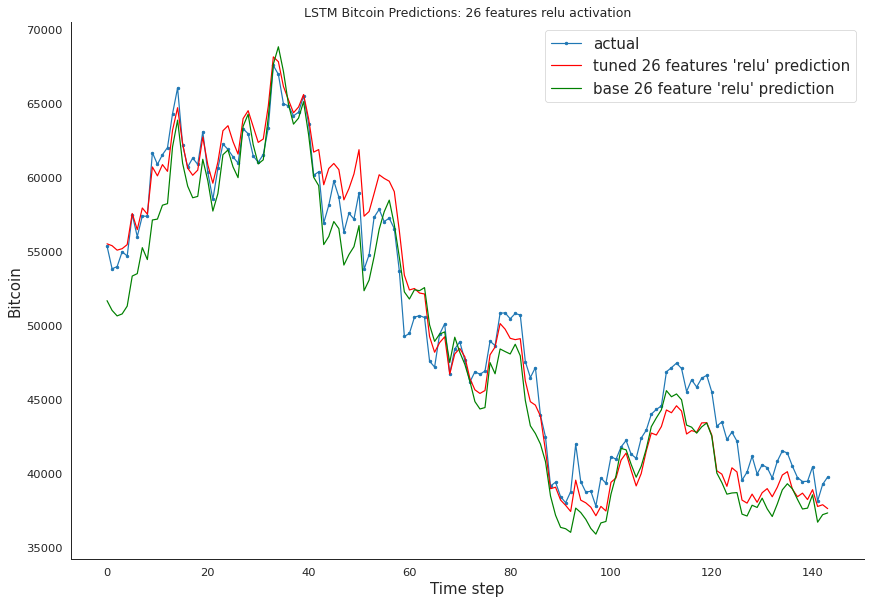

Test Root Mean Squared Error for Tuned 26 Features ReLU: 1725.1555315046974
Test Root Mean Squared Error for Base 26 Features ReLU: 2233.8989538721908

Tuned LSTM ReLU 26 feature: total return for 143 day period starting 2021-10-08 is $ -11104.676021800908
Base LSTM ReLU 26 feature: total return for 143 day period starting 2021-10-08 is $ -4387.183779986153

 the value of our DM test statistic is [-2.61108372]
 our p value for our DM test is [0.00902558]

 Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_26ReLU[:,0][:144], 'r', label="tuned 26 features 'relu' prediction")
plt.plot(aa, test_predict3[:,0][:144], 'g', label="base 26 feature 'relu' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 26 features relu activation')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for Tuned 26 Features ReLU:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_26ReLU[:,0])))
print('Test Root Mean Squared Error for Base 26 Features ReLU:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict3[:,0])))

print('\nTuned LSTM ReLU 26 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits26ReLU))
print('Base LSTM ReLU 26 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits3))

d_t_list18 = cul_d_t(MSE, y_teststat, test_predict_26ReLU, test_predict3)
#print(d_t_list18)
print('\n the value of our DM test statistic is', cul_DM(d_t_list18))
print(' our p value for our DM test is', cul_P(d_t_list18))
if abs(cul_DM(d_t_list18)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Case 5: 58 features tanh, base vs. tuned**

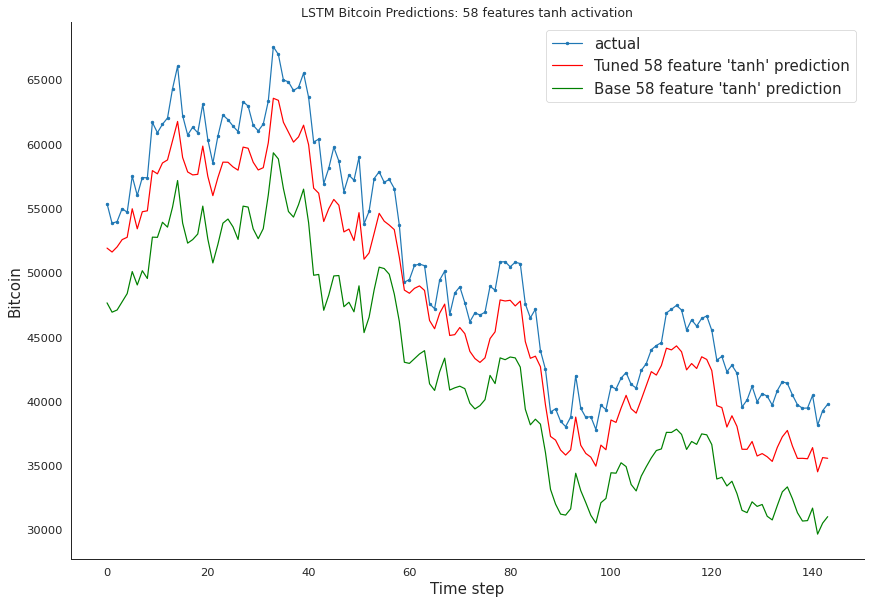

Test Root Mean Squared Error for Tuned 58 Features TanH: 3228.256487007454
Test Root Mean Squared Error for Base 58 Features ReLU: 8141.6648736824745

Tuned LSTM TanH 58 features: total return for 143 day period starting 2021-10-08 is $ 4551.210578480612
Base LSTM TanH 58 feature: total return for 143 day period starting 2021-10-08 is $ -8892.464943154082

 the value of our DM test statistic is [-32.50315354]
 our p value for our DM test is [9.62317053e-232]

 Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_58TanH[:,0][:144], 'r', label="Tuned 58 feature 'tanh' prediction")
plt.plot(aa, test_predict5[:,0][:144], 'g', label="Base 58 feature 'tanh' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 58 features tanh activation')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for Tuned 58 Features TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_58TanH[:,0])))
print('Test Root Mean Squared Error for Base 58 Features ReLU:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict5[:,0])))

print('\nTuned LSTM TanH 58 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits58TanH))
print('Base LSTM TanH 58 feature: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits5))

d_t_list19 = cul_d_t(MSE, y_teststat, test_predict_58TanH, test_predict5)
#print(d_t_list19)
print('\n the value of our DM test statistic is', cul_DM(d_t_list19))
print(' our p value for our DM test is', cul_P(d_t_list19))
if abs(cul_DM(d_t_list19)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Case 6: 58 features relu, tuned vs. base**

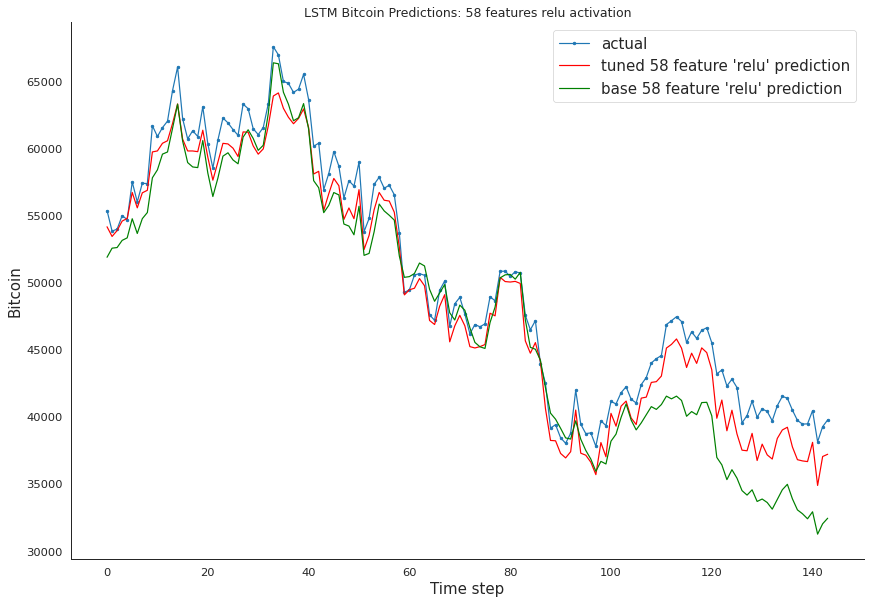

Test Root Mean Squared Error for Tuned 58 Features TanH: 1797.8071671541484
Test Root Mean Squared Error for Base 58 Features ReLU: 3549.8430038782058

Tuned LSTM ReLU 58 features: total return for 143 day period starting 2021-10-08 is $ -2455.1851487674794
Base LSTM ReLU 58 features: total return for 143 day period starting 2021-10-08 is $ -3963.885376905193

 the value of our DM test statistic is [-7.6490748]
 our p value for our DM test is [2.02430474e-14]

 Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different


In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_58ReLU[:,0][:144], 'r', label="tuned 58 feature 'relu' prediction")
plt.plot(aa, test_predict2[:,0][:144], 'g', label="base 58 feature 'relu' prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('LSTM Bitcoin Predictions: 58 features relu activation')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

print('Test Root Mean Squared Error for Tuned 58 Features TanH:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict_58ReLU[:,0])))
print('Test Root Mean Squared Error for Base 58 Features ReLU:',np.sqrt(mean_squared_error(y_test.transpose(), test_predict2[:,0])))

print('\nTuned LSTM ReLU 58 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits58ReLU))
print('Base LSTM ReLU 58 features: total return for 143 day period starting 2021-10-08 is $', sum(dollarprofits2))

d_t_list20 = cul_d_t(MSE, y_teststat, test_predict_58ReLU, test_predict2)
#print(d_t_list20)
print('\n the value of our DM test statistic is', cul_DM(d_t_list20))
print(' our p value for our DM test is', cul_P(d_t_list20))
if abs(cul_DM(d_t_list20)) > 2.58:
  print('\n Null Hypothesis H0 is rejected at 1% significance level, model results are statistically different')
else:
  print('\n Null Hypothesis H0 is accepted at 1% significance level, model results are not statistically different')

**Graph tuned model all predictions**

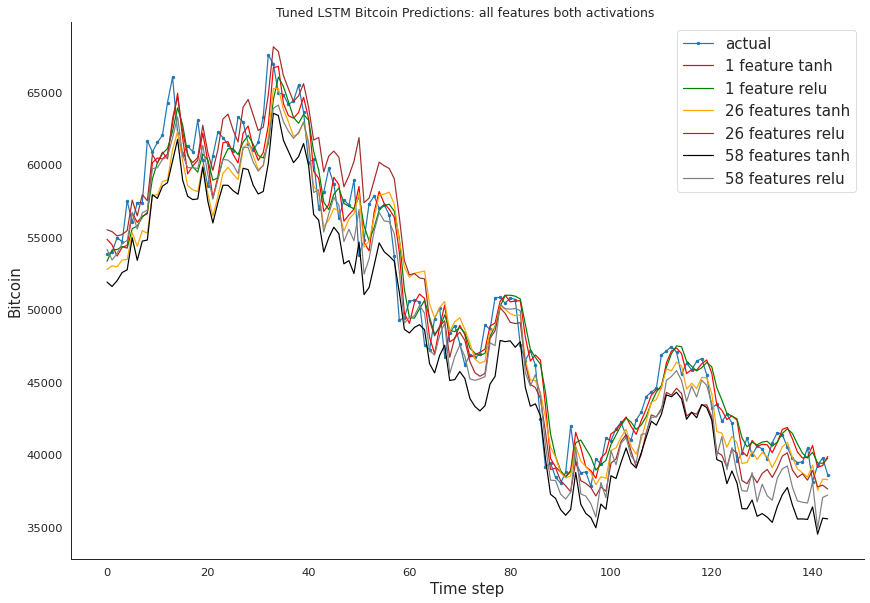

In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test3[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_1TanH[:,0][:144], 'r', label="1 feature tanh")
plt.plot(aa, test_predict_1ReLU[:,0][:144], 'g', label="1 feature relu")
plt.plot(aa, test_predict_26TanH[:,0][:144], 'orange', label="26 features tanh")
plt.plot(aa, test_predict_26ReLU[:,0][:144], 'brown', label="26 features relu")
plt.plot(aa, test_predict_58TanH[:,0][:144], 'black', label="58 features tanh")
plt.plot(aa, test_predict_58ReLU[:,0][:144], 'grey', label="58 features relu")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Tuned LSTM Bitcoin Predictions: all features both activations ')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

**Graph tuned model ReLU predictions**

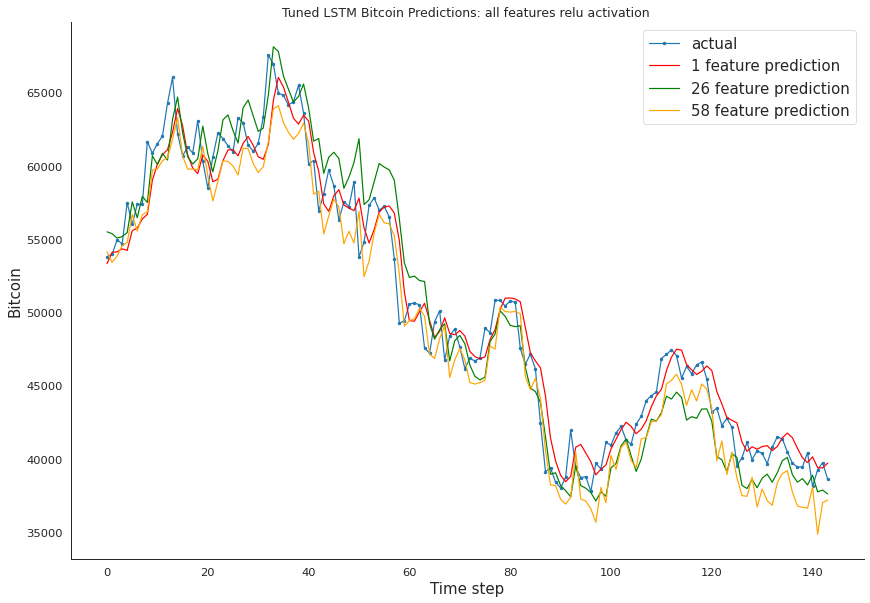

In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test3[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_1ReLU[:,0][:144], 'r', label="1 feature prediction")
plt.plot(aa, test_predict_26ReLU[:,0][:144], 'g', label="26 feature prediction")
plt.plot(aa, test_predict_58ReLU[:,0][:144], 'orange', label="58 feature prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Tuned LSTM Bitcoin Predictions: all features relu activation ')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

**Graph tuned model TanH predictions**

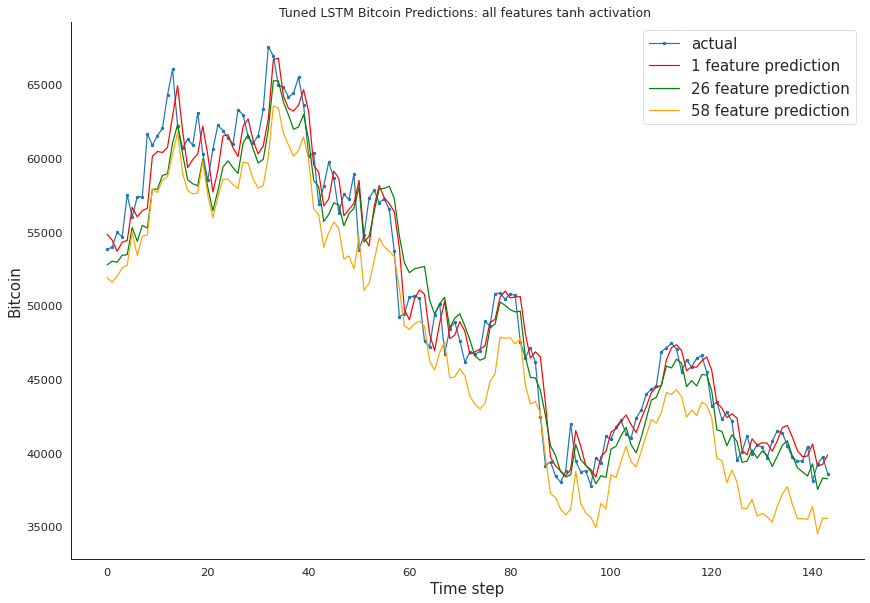

In [ ]:
aa=[x for x in range(144)]
plt.figure(figsize=(12,8))
plt.plot(aa, y_test3[0][:144], marker='.', label="actual")
plt.plot(aa, test_predict_1TanH[:,0][:144], 'r', label="1 feature prediction")
plt.plot(aa, test_predict_26TanH[:,0][:144], 'g', label="26 feature prediction")
plt.plot(aa, test_predict_58TanH[:,0][:144], 'orange', label="58 feature prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Tuned LSTM Bitcoin Predictions: all features tanh activation ')
plt.ylabel('Bitcoin', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

**References**

Much of the code used here was found online. Both GitHub and Machine Learning blogs provide useful solutions for the main aspect of this data analysis task. All the code I found and used is referenced here. 

The first link below is the **initial github** I found and inspected. It provides code as well as a blog style walk through of each stage. This was useful initially as it helped me understand aspects of the task. Their graph plots are quite advanced, something I could improve on.

https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb

--------

This was the **main github** I followed, it was written recently and provided some statisitcal tests useful for my data exploration. Whilst exploring this task I realised they made a few errors. For instance, they failed to split train and test before scaling and therefore introduced bias in their models. They also collected market data (NASDAQ, Gold, SP500 etc.) but only used one feature for prediction (Close Price). They also omitted the use of a validation set and callbacks on model training. They did not include any statistical testing on forecast losses or hyperparameter tuning.

https://github.com/saransh317/Cryptocurrency-Price-Prediction-using-LSTM-GRU-and-Random-Forest-Regressor/blob/main/Multivariate_Prediction.ipynb

--------

The link below provides more code that pertains to **econometric testing**. ADF test (used in mine) is complemented by **ACF** and **PACF** plots. These plots are used for traditional linear econometric regressions where correlation in our predictor variables leads to spurious results. This is still good stuff to explore as looking at ACF and PACF may still be an effective way to decrease loss.  Data pre-processing is very important, therefore this is an area that could warrant further research. By taking the logarithm of each of our series we could have smoothed our data which may have potentially helped smooth the loss curve on our models validation sets. Maybe then our models would have found it easier to predict on test sets? Of course this is hypothetical and needs work to prove. This github also looks at **social media sentiment** (news headlines using vader) as a predictor of price.

https://github.com/nityam007/Stock-Price-Prediction-with-Sentiment-Analysis/blob/main/Stock-Price-Prediction-with-Sentiment-Analysis.ipynb

Another **sentiment** (twitter sentiment) based github, we could use something similar for further NLP based feature research (where social media sentiment has been found as a useful predictor of price).

https://github.com/kaushikjadhav01/Stock-Market-Prediction-Web-App-using-Machine-Learning-And-Sentiment-Analysis

--------

Some **technical indicators** created here, there are many other sources that provide similar code online

https://towardsdatascience.com/forecasting-with-technical-indicators-and-gru-lstm-rnn-multivariate-time-series-a3244dcbc38b

--------

The link below describes these and **many more indicators** that could be explored as features for input into these or other models:

https://www.tradingtechnologies.com/xtrader-help/x-study/technical-indicator-definitions/list-of-technical-indicators/

--------

**Variance Inflation Factor**

https://etav.github.io/python/vif_factor_python.html

--------

**LSTM AutoEncoders** are another way to reduce features. They use the LSTMs themselves to find out which features are useful for prediction. Re-doing this task again I would certainly explore LSTM AutoEncoders and compare results to VIF.

https://machinelearningmastery.com/lstm-autoencoders/

--------

Although feature selection methods may provide application into what should be included / excluded from our model they do not provide much insight. **SHAP** - **SH**apeley **A**dditive ex**P**lanations uses game theory to help visualise feature importance for our models. It is supported for tensorflow and therefore can be used with keras. It also supports use of 3D tensors (i.e., for our LSTM and GRU) instead of just 2D for more traditional models. I found out about this too late on to be able to implement and explore.

https://shap.readthedocs.io/en/latest/index.html

https://github.com/marcotcr/lime

https://medium.datadriveninvestor.com/time-step-wise-feature-importance-in-deep-learning-using-shap-e1c46a655455

--------

**Model Checkpoints / Early Stopping**

https://machinelearningmastery.com/check-point-deep-learning-models-keras/

--------

**Hyperparameter / Network tuning**

Background reading

https://medium.com/analytics-vidhya/comparison-of-hyperparameter-tuning-algorithms-grid-search-random-search-bayesian-optimization-5326aaef1bd1#:~:text=Bayesian%20optimization%20methods%20are%20efficient,grid%20search%20and%20random%20search.

https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4

--------

GridSearch / Randomized Search Cross-Validation

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

---------

Pipelining for deeper networks

https://www.kaggle.com/code/hendraherviawan/regression-with-kerasregressor/notebook

---------

Bayesian Optimization - Given more time this is an area I would definitely like to explore

https://datascience.stackexchange.com/questions/73605/opinions-on-an-lstm-hyper-parameter-tuning-process-i-am-using

https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

https://machinelearningmastery.com/what-is-bayesian-optimization/

---------

**Statistical Tests** for comparing our models. Given the volatile testing data and the stochastic nature of our models (weights are randomly initialized) we can assume some uncertainty in our results. Statistical tests work out within some confidence boundary whether the a models improved skill is in fact true.

https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/

-------

**Implementing a strategy** based on model predictions can be done through Python using for instance, our kraken API. Our strategy is a heuristic, but maybe more advanced strategies could give better results.

https://towardsdatascience.com/machine-learning-for-day-trading-27c08274df54

https://medium.com/auquan/https-medium-com-auquan-machine-learning-techniques-trading-b7120cee4f05

---------